In [1]:
import fitz  # PyMuPDF
import pandas as pd
import numpy as np
import re
import os
from PIL import Image
import io
import matplotlib.pyplot as plt

In [2]:
pdf_file = '/Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2024/NEUROCIRUGÍA.pdf'

In [3]:
def extract_questions(pdf_path):
    doc = fitz.open(pdf_path)
    questions_data = []  # List to store questions

    # Updated regular expression: handle questions with or without a '?'
    #question_pattern = re.compile(r"(\d+)\.\s(.*?)(?:\?)?\s*(?=A\.)", re.DOTALL)
    question_pattern = re.compile(r"(\d+)\.\s(.*?\??)\s*(?=A\.)", re.DOTALL)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        
        # Find all questions in the text using findall()
        questions = question_pattern.findall(text)
        
        # Append all the questions to the questions_data list
        for _, question in questions:
            questions_data.append(question.strip())  # Store the cleaned question text

    # Convert extracted questions to DataFrame
    questions_df = pd.DataFrame(questions_data, columns=["question"])
    return questions_df

In [4]:
def extract_answers(pdf_path):
    doc = fitz.open(pdf_path)
    answers_data = []  # List to store answers for each question

    # Regular expression for extracting answers
    answer_pattern = re.compile(r"^(A|B|C|D)\.\s(.+)", re.MULTILINE)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines for structured parsing

        current_answers = []  # List to store answers for a given question
        for line in lines:
            answer_match = answer_pattern.match(line)
            if answer_match:
                opt, ans_text = answer_match.groups()
                current_answers.append(ans_text.strip())

            # After four options are found, store them as one row in answers_data
            if len(current_answers) == 4:
                answers_data.append(current_answers)
                current_answers = []  # Reset for next question

    # Convert extracted answers to DataFrame with four columns
    answers_df = pd.DataFrame(answers_data, columns = ["option_A", "option_B", "option_C", "option_D"])
    return answers_df

In [5]:
def get_largest_rectangle(rects):
    """Return the largest rectangle from a list of rectangles."""
    if not rects:
        return None
    
    # Calculate area for each rectangle and store with index
    areas = [(abs((rect.br.x - rect.tl.x) * (rect.br.y - rect.tl.y)), idx) 
             for idx, rect in enumerate(rects)]
    
    # Sort by area (first element of tuple)
    areas.sort(key=lambda x: x[0], reverse=True)
    
    # Return the rectangle with largest area
    return rects[areas[0][1]]

def extract_correct_answers(pdf_path):
    doc = fitz.open(pdf_path)
    correct_answers = []
    missing_questions = []  # Track questions that were skipped
    
    # Flexible regex for answer choices (handles missing spaces like "A." and "A. ")
    answer_pattern = re.compile(r"^(A|B|C|D)\.\s(.+)", re.MULTILINE)
    
    for page_num, page in enumerate(doc, start=1):
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines
        
        # Extract valid answer positions using regex
        answer_positions = {key: [] for key in ["A", "B", "C", "D"]}
        
        for line in lines:
            match = answer_pattern.match(line)
            if match:
                answer_letter, answer_text = match.groups()
                
                # Try different search variations to find the best match
                search_texts = [
                    match.group(0),  # Original matched text
                    match.group(0).strip(),  # Stripped version
                    answer_letter + '.' + answer_text,  # Without space after period
                    answer_letter.upper() + '. ' + answer_text,  # Different case
                ]
                
                rects = None
                used_search_text = ""
                
                # Find the first successful search
                for search_text in search_texts:
                    rects = page.search_for(search_text)
                    if rects:
                        used_search_text = search_text
                        break
                
                if rects:
                    # Select the largest rectangle
                    largest_rect = get_largest_rectangle(rects)
                    if largest_rect:
                        answer_positions[answer_letter].append(largest_rect)
        
        # Find the maximum number of questions on the page
        num_questions = max(len(answer_positions["A"]), len(answer_positions["B"]),
                          len(answer_positions["C"]), len(answer_positions["D"]))
        
        # Debugging: Show how many answers were found
        print(f"\nPage {page_num}: Found {num_questions} questions")
        
        for idx in range(num_questions):
            best_answer = None
            best_yellow_pixels = 0  # Track the highest number of yellow pixels
            has_all_options = True  # Flag to check if we have all 4 options
            
            for answer_letter in ["A", "B", "C", "D"]:
                rects = answer_positions[answer_letter]
                if idx >= len(rects):
                    has_all_options = False  # Missing one or more options
                    continue
                
                rect = rects[idx]
                
                # Debugging: Print detected answer positions
                print(f"Page {page_num}, Q{idx+1} - {answer_letter}: Detected box: "
                      f"x0={rect.x0:.1f}, y0={rect.y0:.1f}, x1={rect.x1:.1f}, y1={rect.y1:.1f}")
                
                # Expand bounding box only to the right
                expanded_rect = fitz.Rect(rect.x0, rect.y0, rect.x1 + 50, rect.y1)
                
                # Extract pixels from the expanded region
                pixmap = page.get_pixmap(clip=expanded_rect)
                img = np.frombuffer(pixmap.samples, dtype=np.uint8).reshape(pixmap.h, pixmap.w, pixmap.n)
                
                # Count yellow pixels (pixels with high red and green, low blue)
                yellow_mask = (
                    (img[:, :, 0] > 200) &  # High red
                    (img[:, :, 1] > 200) &  # High green
                    (img[:, :, 2] < 150)    # Low blue
                )
                yellow_pixels = np.sum(yellow_mask)
                
                # Count total non-white pixels
                nonwhite_mask = ~np.all(img > 250, axis=2)
                total_pixels = np.sum(nonwhite_mask)
                
                # Debug information
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow pixels: {yellow_pixels}")
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Total non-white pixels: {total_pixels}")
                
                if total_pixels > 0:
                    yellow_percentage = (yellow_pixels / total_pixels) * 100
                    print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow percentage: {yellow_percentage:.1f}%")
                
                # Display the box in the notebook
                plt.figure(figsize=(8, 4))
                plt.imshow(img)
                plt.gca().add_patch(plt.Rectangle((0, 0), expanded_rect.width, expanded_rect.height,
                                                fill=False, color='red', linewidth=2))
                plt.title(f'Page {page_num}, Q{idx+1}, Answer {answer_letter}\nYellow pixels: {yellow_pixels}')
                plt.axis('off')
                plt.show()
                
                # Store the best answer based on the highest number of yellow pixels
                if yellow_pixels > best_yellow_pixels:
                    best_yellow_pixels = yellow_pixels
                    best_answer = answer_letter
            
            # If missing options, log missing questions
            if not has_all_options:
                missing_questions.append(f"Page {page_num}, Q{idx+1}")
            
            if best_answer:
                correct_answers.append(best_answer)
                print(f"\nPage {page_num}, Q{idx+1} - Selected Answer: {best_answer} (based on yellow pixel count)")
    
    # Debugging: Print missing questions
    if missing_questions:
        print("\n⚠️ The following questions were skipped due to missing options:")
        for q in missing_questions:
            print(q)
    
    return pd.DataFrame(correct_answers, columns=["correct_answer"])


Page 1: Found 10 questions
Page 1, Q1 - A: Detected box: x0=56.6, y0=127.2, x1=149.1, y1=139.9
Page 1, Q1, A: Yellow pixels: 0
Page 1, Q1, A: Total non-white pixels: 443
Page 1, Q1, A: Yellow percentage: 0.0%


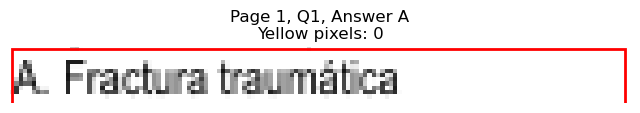

Page 1, Q1 - B: Detected box: x0=56.6, y0=139.9, x1=173.7, y1=152.6
Page 1, Q1, B: Yellow pixels: 1743
Page 1, Q1, B: Total non-white pixels: 2352
Page 1, Q1, B: Yellow percentage: 74.1%


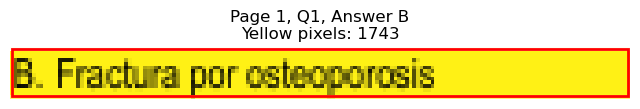

Page 1, Q1 - C: Detected box: x0=315.4, y0=127.2, x1=373.3, y1=139.9
Page 1, Q1, C: Yellow pixels: 0
Page 1, Q1, C: Total non-white pixels: 284
Page 1, Q1, C: Yellow percentage: 0.0%


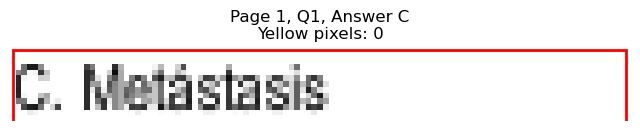

Page 1, Q1 - D: Detected box: x0=315.4, y0=139.9, x1=420.3, y1=152.6
Page 1, Q1, D: Yellow pixels: 0
Page 1, Q1, D: Total non-white pixels: 487
Page 1, Q1, D: Yellow percentage: 0.0%


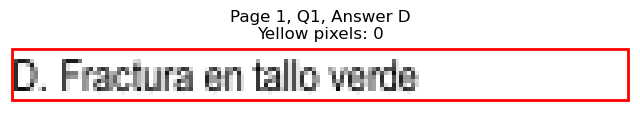


Page 1, Q1 - Selected Answer: B (based on yellow pixel count)
Page 1, Q2 - A: Detected box: x0=56.6, y0=177.7, x1=103.9, y1=190.4
Page 1, Q2, A: Yellow pixels: 98
Page 1, Q2, A: Total non-white pixels: 307
Page 1, Q2, A: Yellow percentage: 31.9%


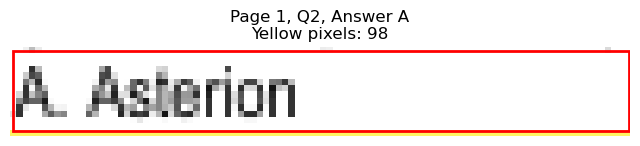

Page 1, Q2 - B: Detected box: x0=56.6, y0=190.3, x1=126.5, y1=203.0
Page 1, Q2, B: Yellow pixels: 1288
Page 1, Q2, B: Total non-white pixels: 1573
Page 1, Q2, B: Yellow percentage: 81.9%


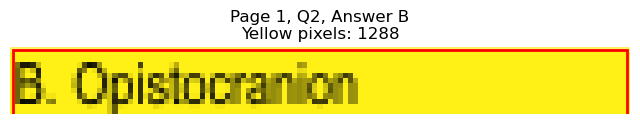

Page 1, Q2 - C: Detected box: x0=315.4, y0=177.7, x1=349.6, y1=190.4
Page 1, Q2, C: Yellow pixels: 0
Page 1, Q2, C: Total non-white pixels: 145
Page 1, Q2, C: Yellow percentage: 0.0%


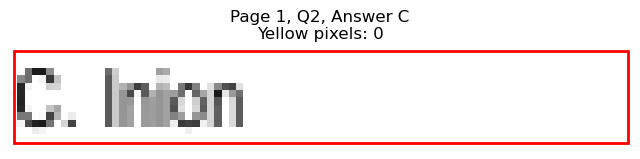

Page 1, Q2 - D: Detected box: x0=315.4, y0=190.3, x1=358.6, y1=203.0
Page 1, Q2, D: Yellow pixels: 0
Page 1, Q2, D: Total non-white pixels: 197
Page 1, Q2, D: Yellow percentage: 0.0%


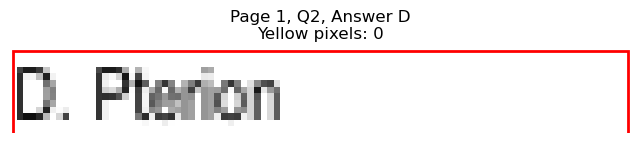


Page 1, Q2 - Selected Answer: B (based on yellow pixel count)
Page 1, Q3 - A: Detected box: x0=56.6, y0=228.2, x1=93.9, y1=240.9
Page 1, Q3, A: Yellow pixels: 1022
Page 1, Q3, A: Total non-white pixels: 1144
Page 1, Q3, A: Yellow percentage: 89.3%


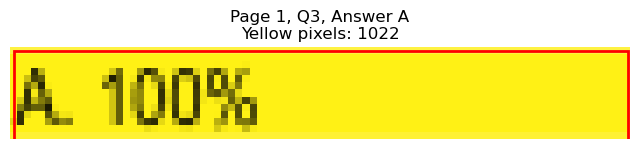

Page 1, Q3 - B: Detected box: x0=56.6, y0=240.8, x1=88.8, y1=253.5
Page 1, Q3, B: Yellow pixels: 83
Page 1, Q3, B: Total non-white pixels: 229
Page 1, Q3, B: Yellow percentage: 36.2%


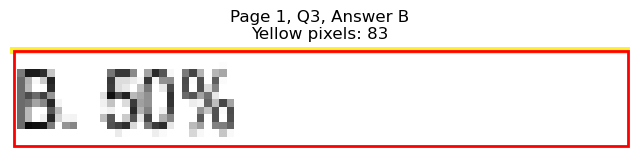

Page 1, Q3 - C: Detected box: x0=315.4, y0=228.2, x1=348.1, y1=240.9
Page 1, Q3, C: Yellow pixels: 0
Page 1, Q3, C: Total non-white pixels: 135
Page 1, Q3, C: Yellow percentage: 0.0%


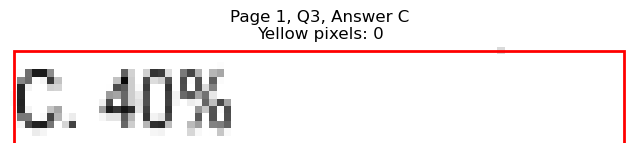

Page 1, Q3 - D: Detected box: x0=315.4, y0=240.8, x1=348.1, y1=253.5
Page 1, Q3, D: Yellow pixels: 0
Page 1, Q3, D: Total non-white pixels: 139
Page 1, Q3, D: Yellow percentage: 0.0%


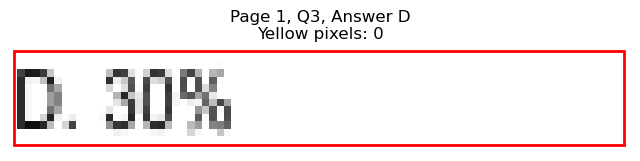


Page 1, Q3 - Selected Answer: A (based on yellow pixel count)
Page 1, Q4 - A: Detected box: x0=56.6, y0=304.0, x1=161.1, y1=316.6
Page 1, Q4, A: Yellow pixels: 1618
Page 1, Q4, A: Total non-white pixels: 2038
Page 1, Q4, A: Yellow percentage: 79.4%


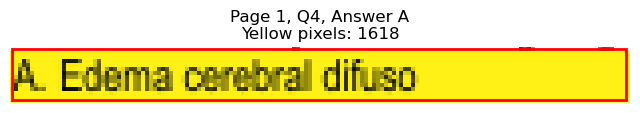

Page 1, Q4 - B: Detected box: x0=56.6, y0=316.6, x1=153.0, y1=329.2
Page 1, Q4, B: Yellow pixels: 148
Page 1, Q4, B: Total non-white pixels: 605
Page 1, Q4, B: Yellow percentage: 24.5%


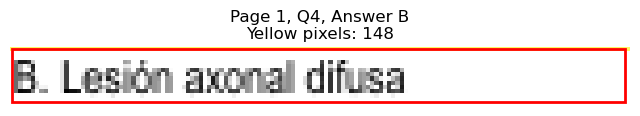

Page 1, Q4 - C: Detected box: x0=315.4, y0=304.0, x1=387.8, y1=316.6
Page 1, Q4, C: Yellow pixels: 0
Page 1, Q4, C: Total non-white pixels: 341
Page 1, Q4, C: Yellow percentage: 0.0%


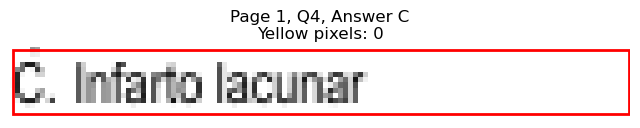

Page 1, Q4 - D: Detected box: x0=315.4, y0=316.6, x1=403.3, y1=329.2
Page 1, Q4, D: Yellow pixels: 0
Page 1, Q4, D: Total non-white pixels: 412
Page 1, Q4, D: Yellow percentage: 0.0%


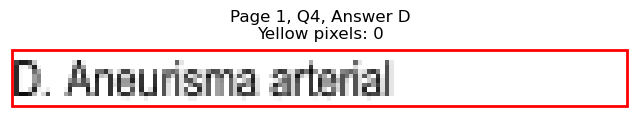


Page 1, Q4 - Selected Answer: A (based on yellow pixel count)
Page 1, Q5 - A: Detected box: x0=56.6, y0=392.3, x1=129.5, y1=405.0
Page 1, Q5, A: Yellow pixels: 0
Page 1, Q5, A: Total non-white pixels: 358
Page 1, Q5, A: Yellow percentage: 0.0%


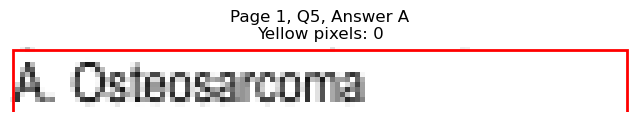

Page 1, Q5 - B: Detected box: x0=56.6, y0=404.9, x1=138.5, y1=417.6
Page 1, Q5, B: Yellow pixels: 0
Page 1, Q5, B: Total non-white pixels: 388
Page 1, Q5, B: Yellow percentage: 0.0%


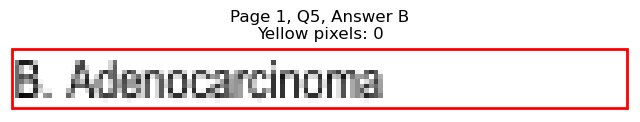

Page 1, Q5 - C: Detected box: x0=315.4, y0=392.3, x1=362.1, y1=405.0
Page 1, Q5, C: Yellow pixels: 0
Page 1, Q5, C: Total non-white pixels: 280
Page 1, Q5, C: Yellow percentage: 0.0%


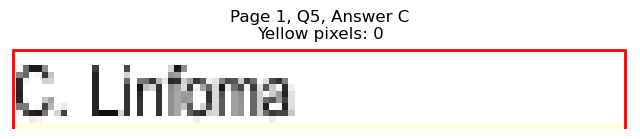

Page 1, Q5 - D: Detected box: x0=315.4, y0=404.9, x1=372.2, y1=417.6
Page 1, Q5, D: Yellow pixels: 1183
Page 1, Q5, D: Total non-white pixels: 1512
Page 1, Q5, D: Yellow percentage: 78.2%


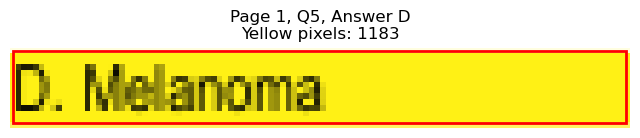


Page 1, Q5 - Selected Answer: D (based on yellow pixel count)
Page 1, Q6 - A: Detected box: x0=56.6, y0=442.8, x1=101.1, y1=455.5
Page 1, Q6, A: Yellow pixels: 0
Page 1, Q6, A: Total non-white pixels: 206
Page 1, Q6, A: Yellow percentage: 0.0%


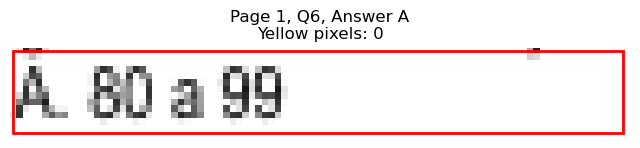

Page 1, Q6 - B: Detected box: x0=56.6, y0=455.5, x1=110.9, y1=468.1
Page 1, Q6, B: Yellow pixels: 0
Page 1, Q6, B: Total non-white pixels: 237
Page 1, Q6, B: Yellow percentage: 0.0%


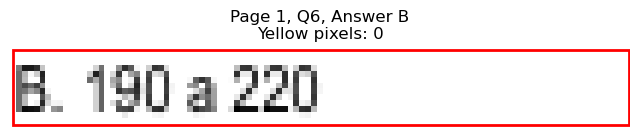

Page 1, Q6 - C: Detected box: x0=315.4, y0=442.8, x1=370.3, y1=455.5
Page 1, Q6, C: Yellow pixels: 1211
Page 1, Q6, C: Total non-white pixels: 1484
Page 1, Q6, C: Yellow percentage: 81.6%


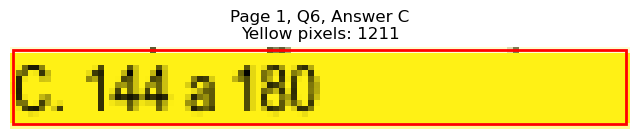

Page 1, Q6 - D: Detected box: x0=315.4, y0=455.5, x1=365.2, y1=468.1
Page 1, Q6, D: Yellow pixels: 0
Page 1, Q6, D: Total non-white pixels: 214
Page 1, Q6, D: Yellow percentage: 0.0%


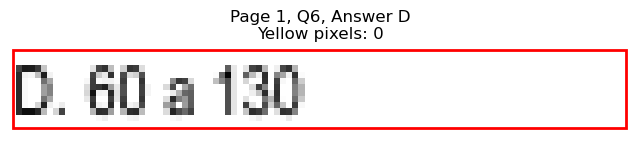


Page 1, Q6 - Selected Answer: C (based on yellow pixel count)
Page 1, Q7 - A: Detected box: x0=56.6, y0=506.0, x1=118.0, y1=518.6
Page 1, Q7, A: Yellow pixels: 1217
Page 1, Q7, A: Total non-white pixels: 1568
Page 1, Q7, A: Yellow percentage: 77.6%


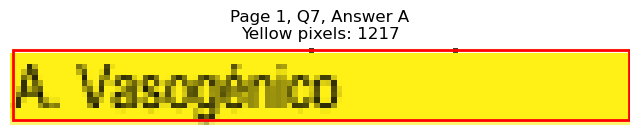

Page 1, Q7 - B: Detected box: x0=56.6, y0=518.6, x1=121.9, y1=531.2
Page 1, Q7, B: Yellow pixels: 115
Page 1, Q7, B: Total non-white pixels: 453
Page 1, Q7, B: Yellow percentage: 25.4%


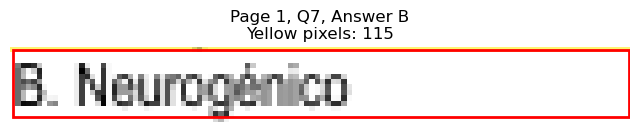

Page 1, Q7 - C: Detected box: x0=315.4, y0=506.0, x1=370.6, y1=518.6
Page 1, Q7, C: Yellow pixels: 0
Page 1, Q7, C: Total non-white pixels: 271
Page 1, Q7, C: Yellow percentage: 0.0%


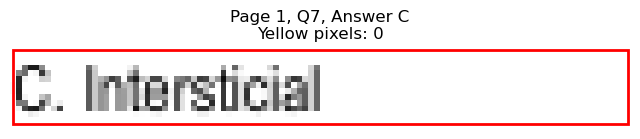

Page 1, Q7 - D: Detected box: x0=315.4, y0=518.6, x1=369.7, y1=531.2
Page 1, Q7, D: Yellow pixels: 0
Page 1, Q7, D: Total non-white pixels: 262
Page 1, Q7, D: Yellow percentage: 0.0%


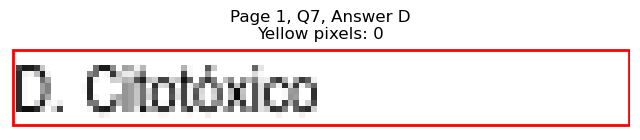


Page 1, Q7 - Selected Answer: A (based on yellow pixel count)
Page 1, Q8 - A: Detected box: x0=56.6, y0=569.1, x1=262.5, y1=581.7
Page 1, Q8, A: Yellow pixels: 0
Page 1, Q8, A: Total non-white pixels: 1016
Page 1, Q8, A: Yellow percentage: 0.0%


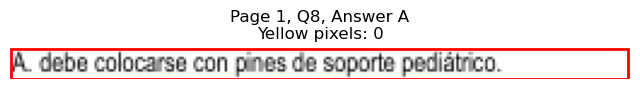

Page 1, Q8 - B: Detected box: x0=56.6, y0=581.7, x1=259.0, y1=594.3
Page 1, Q8, B: Yellow pixels: 0
Page 1, Q8, B: Total non-white pixels: 974
Page 1, Q8, B: Yellow percentage: 0.0%


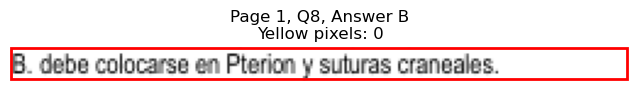

Page 1, Q8 - C: Detected box: x0=315.4, y0=569.1, x1=492.1, y1=581.7
Page 1, Q8, C: Yellow pixels: 1
Page 1, Q8, C: Total non-white pixels: 1120
Page 1, Q8, C: Yellow percentage: 0.1%


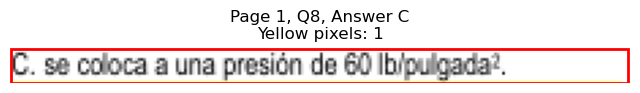

Page 1, Q8 - D: Detected box: x0=315.4, y0=581.7, x1=522.2, y1=594.3
Page 1, Q8, D: Yellow pixels: 1976
Page 1, Q8, D: Total non-white pixels: 3164
Page 1, Q8, D: Yellow percentage: 62.5%


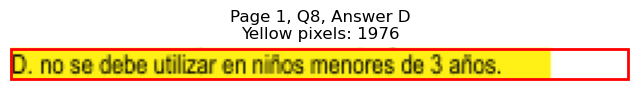


Page 1, Q8 - Selected Answer: D (based on yellow pixel count)
Page 1, Q9 - A: Detected box: x0=56.6, y0=632.2, x1=94.3, y1=644.9
Page 1, Q9, A: Yellow pixels: 0
Page 1, Q9, A: Total non-white pixels: 173
Page 1, Q9, A: Yellow percentage: 0.0%


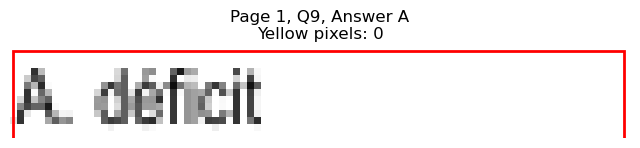

Page 1, Q9 - B: Detected box: x0=56.6, y0=644.8, x1=100.9, y1=657.5
Page 1, Q9, B: Yellow pixels: 0
Page 1, Q9, B: Total non-white pixels: 206
Page 1, Q9, B: Yellow percentage: 0.0%


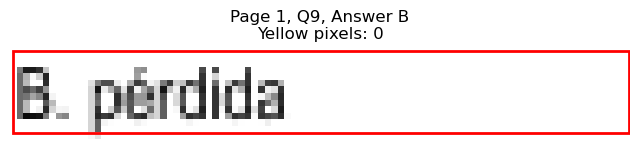

Page 1, Q9 - C: Detected box: x0=315.4, y0=632.2, x1=377.7, y1=644.9
Page 1, Q9, C: Yellow pixels: 0
Page 1, Q9, C: Total non-white pixels: 386
Page 1, Q9, C: Yellow percentage: 0.0%


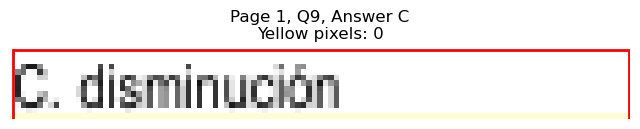

Page 1, Q9 - D: Detected box: x0=315.4, y0=644.8, x1=365.2, y1=657.5
Page 1, Q9, D: Yellow pixels: 1150
Page 1, Q9, D: Total non-white pixels: 1414
Page 1, Q9, D: Yellow percentage: 81.3%


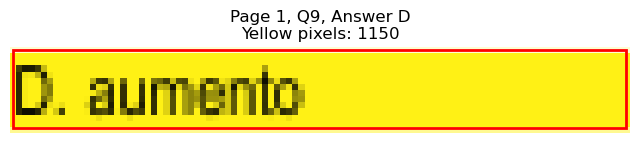


Page 1, Q9 - Selected Answer: D (based on yellow pixel count)
Page 1, Q10 - A: Detected box: x0=56.6, y0=708.0, x1=121.5, y1=720.6
Page 1, Q10, A: Yellow pixels: 0
Page 1, Q10, A: Total non-white pixels: 324
Page 1, Q10, A: Yellow percentage: 0.0%


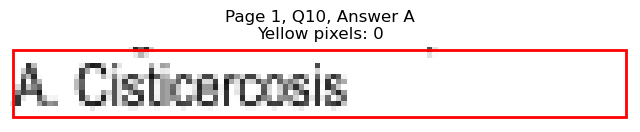

Page 1, Q10 - B: Detected box: x0=56.6, y0=720.6, x1=176.1, y1=733.2
Page 1, Q10, B: Yellow pixels: 0
Page 1, Q10, B: Total non-white pixels: 600
Page 1, Q10, B: Yellow percentage: 0.0%


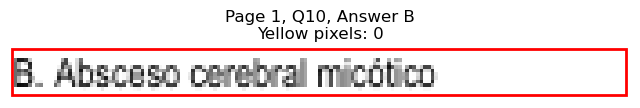

Page 1, Q10 - C: Detected box: x0=315.4, y0=708.0, x1=433.9, y1=720.6
Page 1, Q10, C: Yellow pixels: 1750
Page 1, Q10, C: Total non-white pixels: 2366
Page 1, Q10, C: Yellow percentage: 74.0%


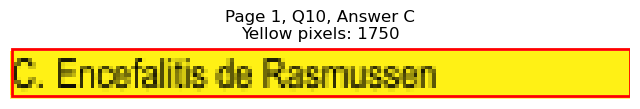

Page 1, Q10 - D: Detected box: x0=315.4, y0=720.6, x1=385.7, y1=733.2
Page 1, Q10, D: Yellow pixels: 121
Page 1, Q10, D: Total non-white pixels: 459
Page 1, Q10, D: Yellow percentage: 26.4%


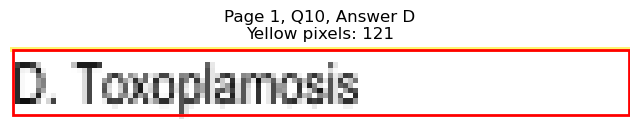


Page 1, Q10 - Selected Answer: C (based on yellow pixel count)

Page 2: Found 10 questions
Page 2, Q1 - A: Detected box: x0=56.6, y0=114.6, x1=310.0, y1=127.3
Page 2, Q1, A: Yellow pixels: 0
Page 2, Q1, A: Total non-white pixels: 1256
Page 2, Q1, A: Yellow percentage: 0.0%


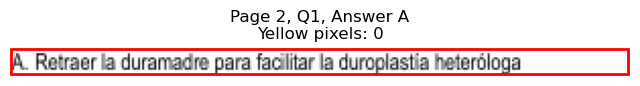

Page 2, Q1 - B: Detected box: x0=56.6, y0=127.2, x1=265.8, y1=139.9
Page 2, Q1, B: Yellow pixels: 0
Page 2, Q1, B: Total non-white pixels: 1024
Page 2, Q1, B: Yellow percentage: 0.0%


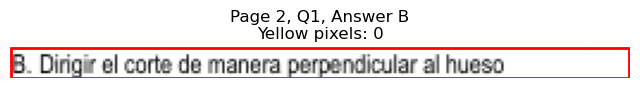

Page 2, Q1 - C: Detected box: x0=56.6, y0=139.9, x1=212.8, y1=152.6
Page 2, Q1, C: Yellow pixels: 207
Page 2, Q1, C: Total non-white pixels: 976
Page 2, Q1, C: Yellow percentage: 21.2%


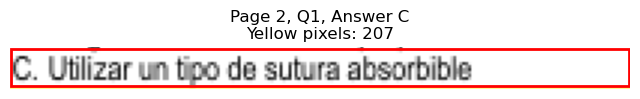

Page 2, Q1 - D: Detected box: x0=56.6, y0=152.5, x1=315.2, y1=165.2
Page 2, Q1, D: Yellow pixels: 3059
Page 2, Q1, D: Total non-white pixels: 4340
Page 2, Q1, D: Yellow percentage: 70.5%


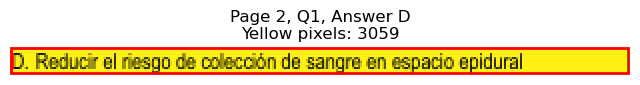


Page 2, Q1 - Selected Answer: D (based on yellow pixel count)
Page 2, Q2 - A: Detected box: x0=56.6, y0=190.3, x1=137.1, y1=203.0
Page 2, Q2, A: Yellow pixels: 0
Page 2, Q2, A: Total non-white pixels: 559
Page 2, Q2, A: Yellow percentage: 0.0%


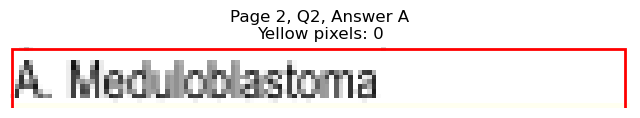

Page 2, Q2 - B: Detected box: x0=56.6, y0=202.9, x1=168.1, y1=215.6
Page 2, Q2, B: Yellow pixels: 1677
Page 2, Q2, B: Total non-white pixels: 2282
Page 2, Q2, B: Yellow percentage: 73.5%


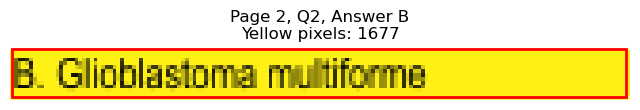

Page 2, Q2 - C: Detected box: x0=315.4, y0=190.3, x1=413.3, y1=203.0
Page 2, Q2, C: Yellow pixels: 0
Page 2, Q2, C: Total non-white pixels: 497
Page 2, Q2, C: Yellow percentage: 0.0%


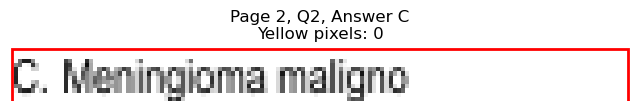

Page 2, Q2 - D: Detected box: x0=315.4, y0=202.9, x1=412.9, y1=215.6
Page 2, Q2, D: Yellow pixels: 0
Page 2, Q2, D: Total non-white pixels: 476
Page 2, Q2, D: Yellow percentage: 0.0%


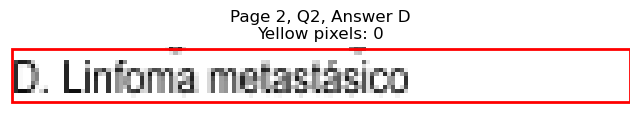


Page 2, Q2 - Selected Answer: B (based on yellow pixel count)
Page 2, Q3 - A: Detected box: x0=56.6, y0=266.0, x1=227.8, y1=278.7
Page 2, Q3, A: Yellow pixels: 0
Page 2, Q3, A: Total non-white pixels: 870
Page 2, Q3, A: Yellow percentage: 0.0%


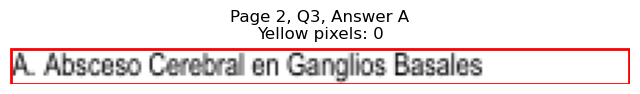

Page 2, Q3 - B: Detected box: x0=56.6, y0=278.8, x1=173.5, y1=291.4
Page 2, Q3, B: Yellow pixels: 0
Page 2, Q3, B: Total non-white pixels: 547
Page 2, Q3, B: Yellow percentage: 0.0%


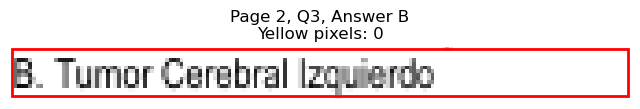

Page 2, Q3 - C: Detected box: x0=315.4, y0=266.0, x1=444.4, y1=278.7
Page 2, Q3, C: Yellow pixels: 1837
Page 2, Q3, C: Total non-white pixels: 2340
Page 2, Q3, C: Yellow percentage: 78.5%


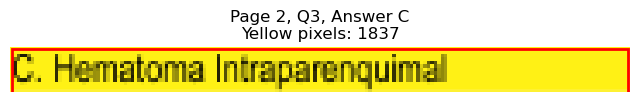

Page 2, Q3 - D: Detected box: x0=315.4, y0=278.8, x1=469.9, y1=291.4
Page 2, Q3, D: Yellow pixels: 205
Page 2, Q3, D: Total non-white pixels: 935
Page 2, Q3, D: Yellow percentage: 21.9%


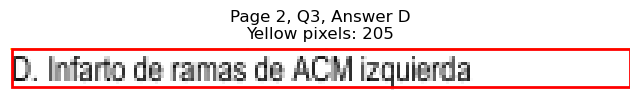


Page 2, Q3 - Selected Answer: C (based on yellow pixel count)
Page 2, Q4 - A: Detected box: x0=56.6, y0=316.6, x1=219.8, y1=329.2
Page 2, Q4, A: Yellow pixels: 0
Page 2, Q4, A: Total non-white pixels: 790
Page 2, Q4, A: Yellow percentage: 0.0%


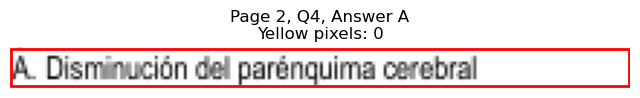

Page 2, Q4 - B: Detected box: x0=56.6, y0=329.2, x1=230.3, y1=341.8
Page 2, Q4, B: Yellow pixels: 0
Page 2, Q4, B: Total non-white pixels: 836
Page 2, Q4, B: Yellow percentage: 0.0%


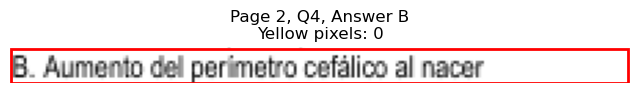

Page 2, Q4 - C: Detected box: x0=56.6, y0=341.9, x1=305.6, y1=354.6
Page 2, Q4, C: Yellow pixels: 3037
Page 2, Q4, C: Total non-white pixels: 4200
Page 2, Q4, C: Yellow percentage: 72.3%


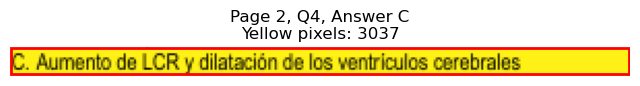

Page 2, Q4 - D: Detected box: x0=56.6, y0=354.5, x1=195.7, y1=367.2
Page 2, Q4, D: Yellow pixels: 189
Page 2, Q4, D: Total non-white pixels: 884
Page 2, Q4, D: Yellow percentage: 21.4%


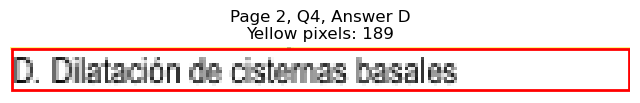


Page 2, Q4 - Selected Answer: C (based on yellow pixel count)
Page 2, Q5 - A: Detected box: x0=56.6, y0=392.3, x1=107.9, y1=405.0
Page 2, Q5, A: Yellow pixels: 0
Page 2, Q5, A: Total non-white pixels: 234
Page 2, Q5, A: Yellow percentage: 0.0%


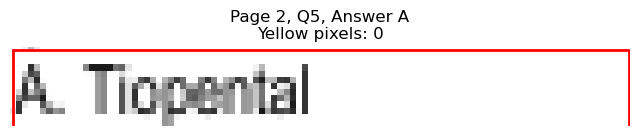

Page 2, Q5 - B: Detected box: x0=56.6, y0=404.9, x1=104.4, y1=417.6
Page 2, Q5, B: Yellow pixels: 0
Page 2, Q5, B: Total non-white pixels: 239
Page 2, Q5, B: Yellow percentage: 0.0%


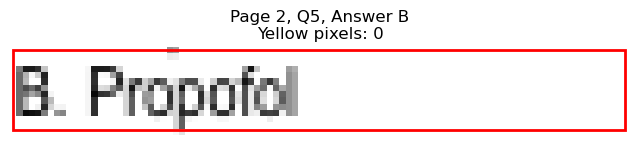

Page 2, Q5 - C: Detected box: x0=315.4, y0=392.3, x1=368.2, y1=405.0
Page 2, Q5, C: Yellow pixels: 1175
Page 2, Q5, C: Total non-white pixels: 1352
Page 2, Q5, C: Yellow percentage: 86.9%


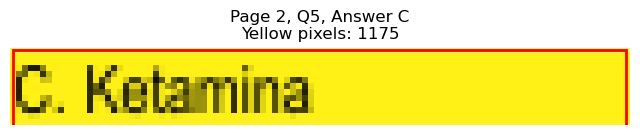

Page 2, Q5 - D: Detected box: x0=315.4, y0=404.9, x1=370.6, y1=417.6
Page 2, Q5, D: Yellow pixels: 106
Page 2, Q5, D: Total non-white pixels: 366
Page 2, Q5, D: Yellow percentage: 29.0%


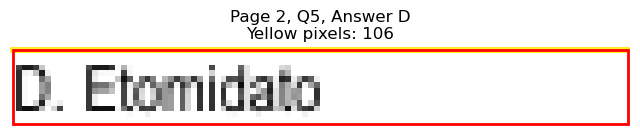


Page 2, Q5 - Selected Answer: C (based on yellow pixel count)
Page 2, Q6 - A: Detected box: x0=56.6, y0=455.5, x1=127.5, y1=468.1
Page 2, Q6, A: Yellow pixels: 122
Page 2, Q6, A: Total non-white pixels: 484
Page 2, Q6, A: Yellow percentage: 25.2%


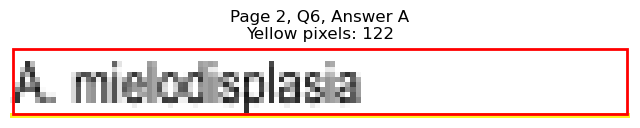

Page 2, Q6 - B: Detected box: x0=56.6, y0=468.1, x1=123.5, y1=480.7
Page 2, Q6, B: Yellow pixels: 1271
Page 2, Q6, B: Total non-white pixels: 1534
Page 2, Q6, B: Yellow percentage: 82.9%


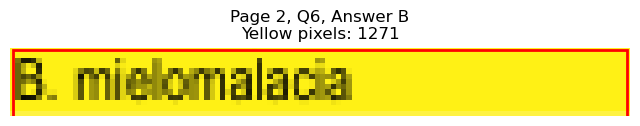

Page 2, Q6 - C: Detected box: x0=315.4, y0=455.5, x1=395.7, y1=468.1
Page 2, Q6, C: Yellow pixels: 0
Page 2, Q6, C: Total non-white pixels: 388
Page 2, Q6, C: Yellow percentage: 0.0%


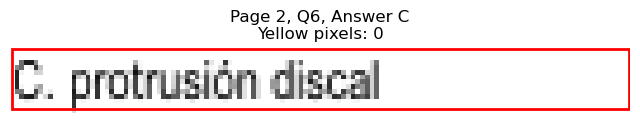

Page 2, Q6 - D: Detected box: x0=315.4, y0=468.1, x1=392.2, y1=480.7
Page 2, Q6, D: Yellow pixels: 0
Page 2, Q6, D: Total non-white pixels: 380
Page 2, Q6, D: Yellow percentage: 0.0%


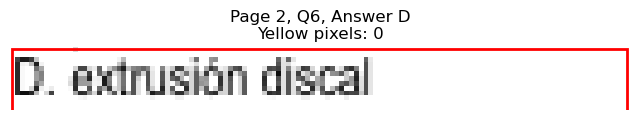


Page 2, Q6 - Selected Answer: B (based on yellow pixel count)
Page 2, Q7 - A: Detected box: x0=56.6, y0=506.0, x1=99.9, y1=518.6
Page 2, Q7, A: Yellow pixels: 94
Page 2, Q7, A: Total non-white pixels: 296
Page 2, Q7, A: Yellow percentage: 31.8%


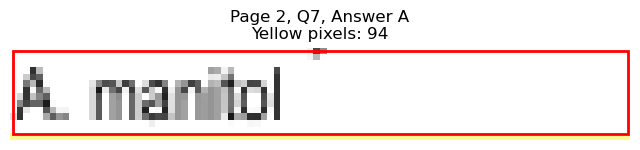

Page 2, Q7 - B: Detected box: x0=56.6, y0=518.6, x1=130.5, y1=531.2
Page 2, Q7, B: Yellow pixels: 1349
Page 2, Q7, B: Total non-white pixels: 1750
Page 2, Q7, B: Yellow percentage: 77.1%


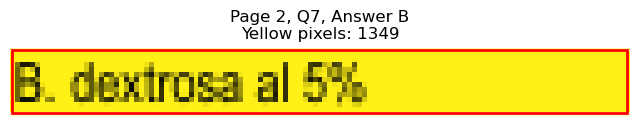

Page 2, Q7 - C: Detected box: x0=315.4, y0=506.0, x1=409.9, y1=518.6
Page 2, Q7, C: Yellow pixels: 0
Page 2, Q7, C: Total non-white pixels: 485
Page 2, Q7, C: Yellow percentage: 0.0%


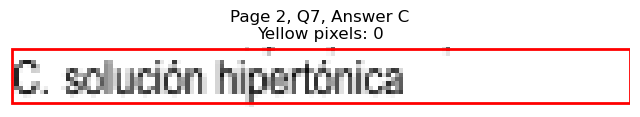

Page 2, Q7 - D: Detected box: x0=315.4, y0=518.6, x1=373.1, y1=531.2
Page 2, Q7, D: Yellow pixels: 0
Page 2, Q7, D: Total non-white pixels: 281
Page 2, Q7, D: Yellow percentage: 0.0%


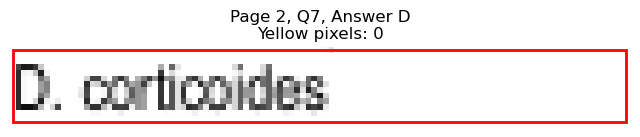


Page 2, Q7 - Selected Answer: B (based on yellow pixel count)
Page 2, Q8 - A: Detected box: x0=56.6, y0=569.1, x1=135.0, y1=581.7
Page 2, Q8, A: Yellow pixels: 1395
Page 2, Q8, A: Total non-white pixels: 1690
Page 2, Q8, A: Yellow percentage: 82.5%


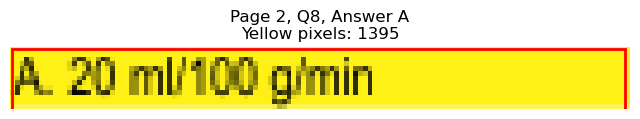

Page 2, Q8 - B: Detected box: x0=56.6, y0=581.7, x1=130.0, y1=594.3
Page 2, Q8, B: Yellow pixels: 122
Page 2, Q8, B: Total non-white pixels: 433
Page 2, Q8, B: Yellow percentage: 28.2%


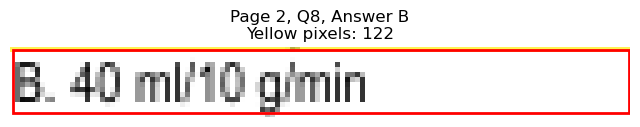

Page 2, Q8 - C: Detected box: x0=315.4, y0=569.1, x1=394.3, y1=581.7
Page 2, Q8, C: Yellow pixels: 0
Page 2, Q8, C: Total non-white pixels: 371
Page 2, Q8, C: Yellow percentage: 0.0%


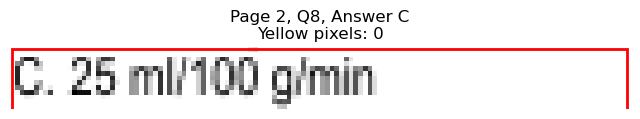

Page 2, Q8 - D: Detected box: x0=315.4, y0=581.7, x1=394.3, y1=594.3
Page 2, Q8, D: Yellow pixels: 0
Page 2, Q8, D: Total non-white pixels: 378
Page 2, Q8, D: Yellow percentage: 0.0%


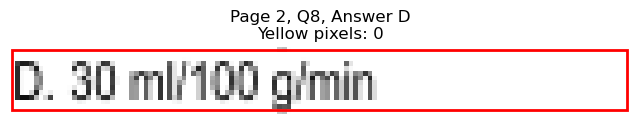


Page 2, Q8 - Selected Answer: A (based on yellow pixel count)
Page 2, Q9 - A: Detected box: x0=56.6, y0=632.2, x1=118.0, y1=644.9
Page 2, Q9, A: Yellow pixels: 0
Page 2, Q9, A: Total non-white pixels: 411
Page 2, Q9, A: Yellow percentage: 0.0%


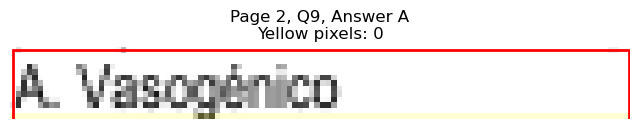

Page 2, Q9 - B: Detected box: x0=56.6, y0=644.8, x1=111.4, y1=657.5
Page 2, Q9, B: Yellow pixels: 1160
Page 2, Q9, B: Total non-white pixels: 1484
Page 2, Q9, B: Yellow percentage: 78.2%


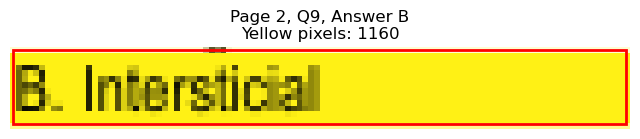

Page 2, Q9 - C: Detected box: x0=315.4, y0=632.2, x1=369.7, y1=644.9
Page 2, Q9, C: Yellow pixels: 0
Page 2, Q9, C: Total non-white pixels: 258
Page 2, Q9, C: Yellow percentage: 0.0%


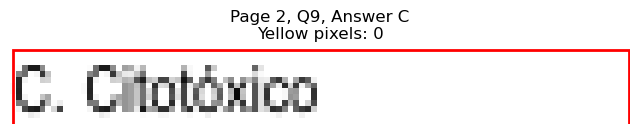

Page 2, Q9 - D: Detected box: x0=315.4, y0=644.8, x1=377.2, y1=657.5
Page 2, Q9, D: Yellow pixels: 0
Page 2, Q9, D: Total non-white pixels: 304
Page 2, Q9, D: Yellow percentage: 0.0%


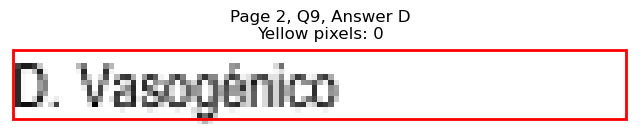


Page 2, Q9 - Selected Answer: B (based on yellow pixel count)
Page 2, Q10 - A: Detected box: x0=56.6, y0=708.0, x1=156.6, y1=720.6
Page 2, Q10, A: Yellow pixels: 1591
Page 2, Q10, A: Total non-white pixels: 2114
Page 2, Q10, A: Yellow percentage: 75.3%


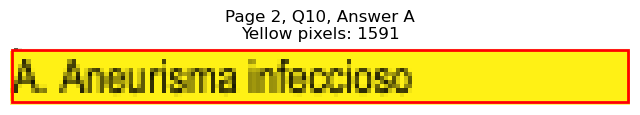

Page 2, Q10 - B: Detected box: x0=56.6, y0=720.6, x1=179.2, y1=733.2
Page 2, Q10, B: Yellow pixels: 174
Page 2, Q10, B: Total non-white pixels: 759
Page 2, Q10, B: Yellow percentage: 22.9%


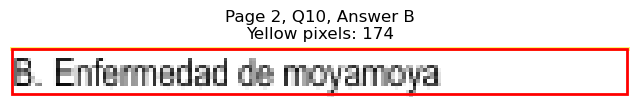

Page 2, Q10 - C: Detected box: x0=315.4, y0=708.0, x1=417.3, y1=720.6
Page 2, Q10, C: Yellow pixels: 0
Page 2, Q10, C: Total non-white pixels: 531
Page 2, Q10, C: Yellow percentage: 0.0%


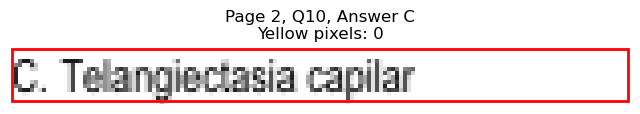

Page 2, Q10 - D: Detected box: x0=315.4, y0=720.6, x1=414.3, y1=733.2
Page 2, Q10, D: Yellow pixels: 0
Page 2, Q10, D: Total non-white pixels: 482
Page 2, Q10, D: Yellow percentage: 0.0%


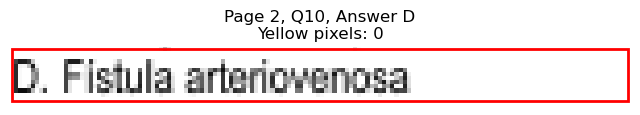


Page 2, Q10 - Selected Answer: A (based on yellow pixel count)

Page 3: Found 12 questions
Page 3, Q1 - A: Detected box: x0=56.6, y0=89.4, x1=229.8, y1=102.1
Page 3, Q1, A: Yellow pixels: 224
Page 3, Q1, A: Total non-white pixels: 1048
Page 3, Q1, A: Yellow percentage: 21.4%


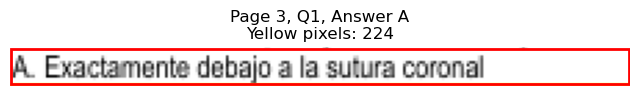

Page 3, Q1 - B: Detected box: x0=56.6, y0=102.0, x1=239.3, y1=114.7
Page 3, Q1, B: Yellow pixels: 2230
Page 3, Q1, B: Total non-white pixels: 2938
Page 3, Q1, B: Yellow percentage: 75.9%


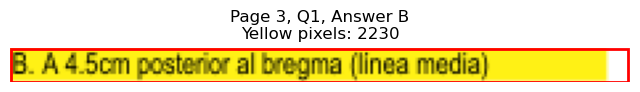

Page 3, Q1 - C: Detected box: x0=315.4, y0=89.4, x1=449.9, y1=102.1
Page 3, Q1, C: Yellow pixels: 0
Page 3, Q1, C: Total non-white pixels: 604
Page 3, Q1, C: Yellow percentage: 0.0%


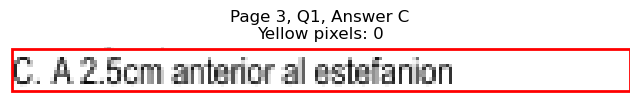

Page 3, Q1 - D: Detected box: x0=315.4, y0=102.0, x1=428.3, y1=114.7
Page 3, Q1, D: Yellow pixels: 0
Page 3, Q1, D: Total non-white pixels: 515
Page 3, Q1, D: Yellow percentage: 0.0%


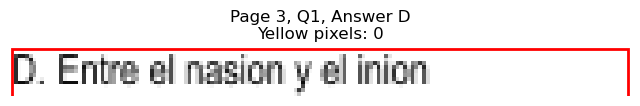


Page 3, Q1 - Selected Answer: B (based on yellow pixel count)
Page 3, Q2 - A: Detected box: x0=56.6, y0=152.5, x1=284.9, y1=165.2
Page 3, Q2, A: Yellow pixels: 0
Page 3, Q2, A: Total non-white pixels: 1052
Page 3, Q2, A: Yellow percentage: 0.0%


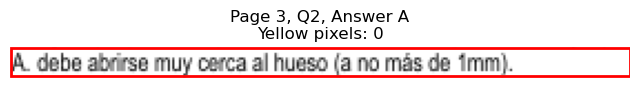

Page 3, Q2 - B: Detected box: x0=56.6, y0=165.1, x1=237.8, y1=177.8
Page 3, Q2, B: Yellow pixels: 0
Page 3, Q2, B: Total non-white pixels: 812
Page 3, Q2, B: Yellow percentage: 0.0%


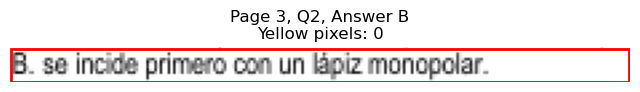

Page 3, Q2 - C: Detected box: x0=56.6, y0=177.7, x1=278.4, y1=190.4
Page 3, Q2, C: Yellow pixels: 273
Page 3, Q2, C: Total non-white pixels: 1314
Page 3, Q2, C: Yellow percentage: 20.8%


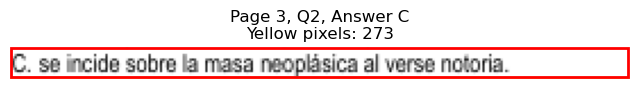

Page 3, Q2 - D: Detected box: x0=56.6, y0=190.3, x1=316.6, y1=203.0
Page 3, Q2, D: Yellow pixels: 3111
Page 3, Q2, D: Total non-white pixels: 4043
Page 3, Q2, D: Yellow percentage: 76.9%


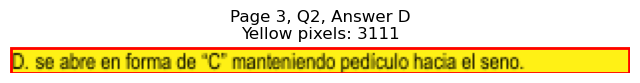


Page 3, Q2 - Selected Answer: D (based on yellow pixel count)
Page 3, Q3 - A: Detected box: x0=56.6, y0=228.2, x1=153.0, y1=240.9
Page 3, Q3, A: Yellow pixels: 0
Page 3, Q3, A: Total non-white pixels: 464
Page 3, Q3, A: Yellow percentage: 0.0%


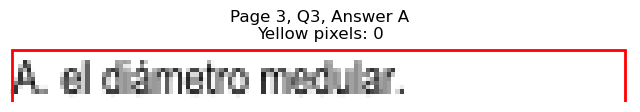

Page 3, Q3 - B: Detected box: x0=56.6, y0=240.8, x1=178.7, y1=253.5
Page 3, Q3, B: Yellow pixels: 0
Page 3, Q3, B: Total non-white pixels: 561
Page 3, Q3, B: Yellow percentage: 0.0%


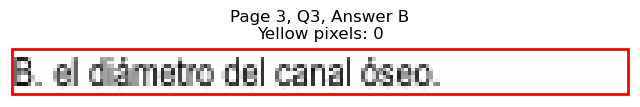

Page 3, Q3 - C: Detected box: x0=315.4, y0=228.2, x1=392.7, y1=240.9
Page 3, Q3, C: Yellow pixels: 1414
Page 3, Q3, C: Total non-white pixels: 1664
Page 3, Q3, C: Yellow percentage: 85.0%


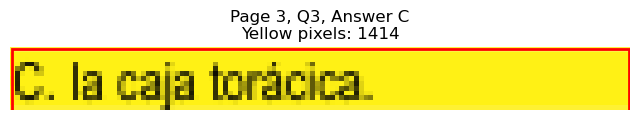

Page 3, Q3 - D: Detected box: x0=315.4, y0=240.8, x1=419.8, y1=253.5
Page 3, Q3, D: Yellow pixels: 153
Page 3, Q3, D: Total non-white pixels: 658
Page 3, Q3, D: Yellow percentage: 23.3%


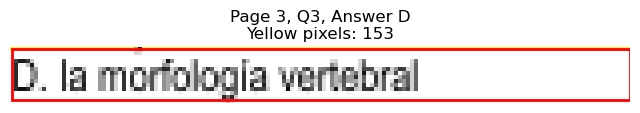


Page 3, Q3 - Selected Answer: C (based on yellow pixel count)
Page 3, Q4 - A: Detected box: x0=56.6, y0=278.8, x1=182.2, y1=291.4
Page 3, Q4, A: Yellow pixels: 0
Page 3, Q4, A: Total non-white pixels: 630
Page 3, Q4, A: Yellow percentage: 0.0%


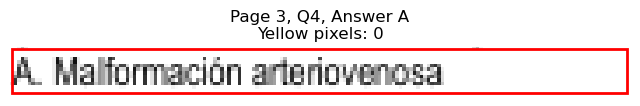

Page 3, Q4 - B: Detected box: x0=56.6, y0=291.4, x1=214.2, y1=304.0
Page 3, Q4, B: Yellow pixels: 0
Page 3, Q4, B: Total non-white pixels: 735
Page 3, Q4, B: Yellow percentage: 0.0%


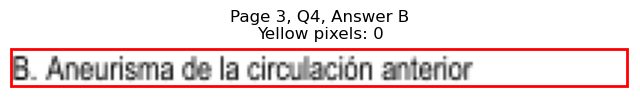

Page 3, Q4 - C: Detected box: x0=315.4, y0=278.8, x1=446.5, y1=291.4
Page 3, Q4, C: Yellow pixels: 182
Page 3, Q4, C: Total non-white pixels: 839
Page 3, Q4, C: Yellow percentage: 21.7%


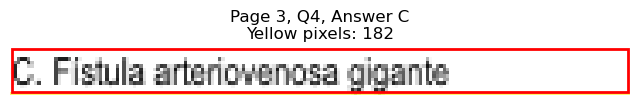

Page 3, Q4 - D: Detected box: x0=315.4, y0=291.4, x1=409.7, y1=304.0
Page 3, Q4, D: Yellow pixels: 1555
Page 3, Q4, D: Total non-white pixels: 2030
Page 3, Q4, D: Yellow percentage: 76.6%


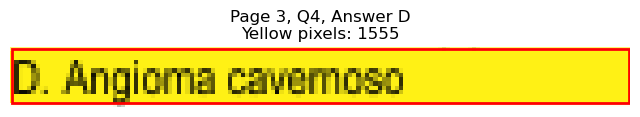


Page 3, Q4 - Selected Answer: D (based on yellow pixel count)
Page 3, Q5 - A: Detected box: x0=56.6, y0=733.2, x1=99.9, y1=745.8
Page 3, Q5, A: Yellow pixels: 0
Page 3, Q5, A: Total non-white pixels: 215
Page 3, Q5, A: Yellow percentage: 0.0%


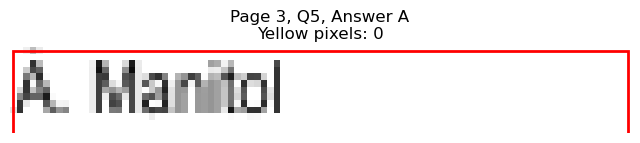

Page 3, Q5 - B: Detected box: x0=56.6, y0=341.9, x1=178.1, y1=354.6
Page 3, Q5, B: Yellow pixels: 0
Page 3, Q5, B: Total non-white pixels: 606
Page 3, Q5, B: Yellow percentage: 0.0%


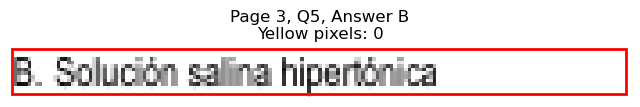

Page 3, Q5 - C: Detected box: x0=315.4, y0=329.2, x1=372.7, y1=341.8
Page 3, Q5, C: Yellow pixels: 1206
Page 3, Q5, C: Total non-white pixels: 1404
Page 3, Q5, C: Yellow percentage: 85.9%


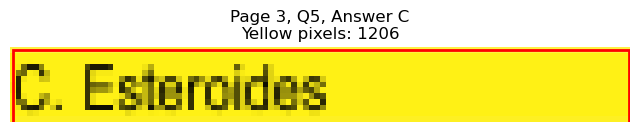

Page 3, Q5 - D: Detected box: x0=315.4, y0=341.9, x1=392.2, y1=354.6
Page 3, Q5, D: Yellow pixels: 128
Page 3, Q5, D: Total non-white pixels: 491
Page 3, Q5, D: Yellow percentage: 26.1%


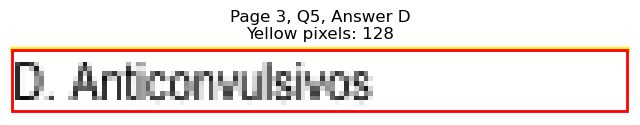


Page 3, Q5 - Selected Answer: C (based on yellow pixel count)
Page 3, Q6 - A: Detected box: x0=56.6, y0=379.7, x1=153.0, y1=392.4
Page 3, Q6, A: Yellow pixels: 0
Page 3, Q6, A: Total non-white pixels: 460
Page 3, Q6, A: Yellow percentage: 0.0%


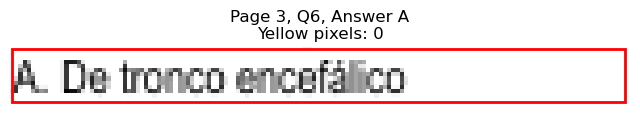

Page 3, Q6 - B: Detected box: x0=56.6, y0=392.3, x1=119.4, y1=405.0
Page 3, Q6, B: Yellow pixels: 0
Page 3, Q6, B: Total non-white pixels: 299
Page 3, Q6, B: Yellow percentage: 0.0%


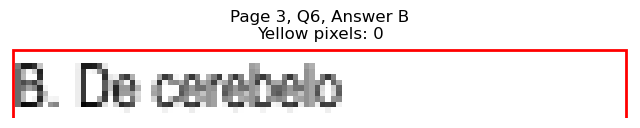

Page 3, Q6 - C: Detected box: x0=315.4, y0=379.7, x1=398.8, y1=392.4
Page 3, Q6, C: Yellow pixels: 134
Page 3, Q6, C: Total non-white pixels: 531
Page 3, Q6, C: Yellow percentage: 25.2%


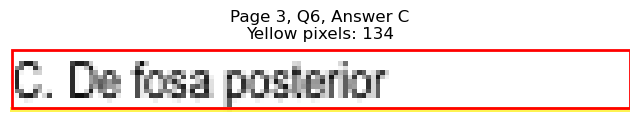

Page 3, Q6 - D: Detected box: x0=315.4, y0=392.3, x1=395.7, y1=405.0
Page 3, Q6, D: Yellow pixels: 1411
Page 3, Q6, D: Total non-white pixels: 1703
Page 3, Q6, D: Yellow percentage: 82.9%


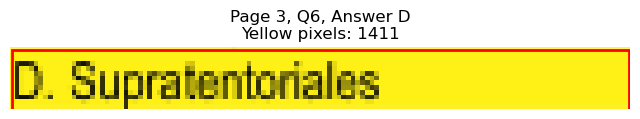


Page 3, Q6 - Selected Answer: D (based on yellow pixel count)
Page 3, Q7 - A: Detected box: x0=56.6, y0=430.2, x1=118.9, y1=442.9
Page 3, Q7, A: Yellow pixels: 0
Page 3, Q7, A: Total non-white pixels: 272
Page 3, Q7, A: Yellow percentage: 0.0%


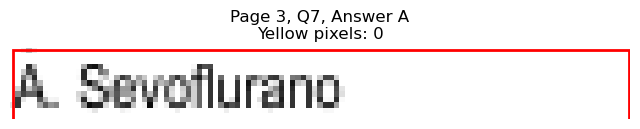

Page 3, Q7 - B: Detected box: x0=56.6, y0=442.8, x1=114.5, y1=455.5
Page 3, Q7, B: Yellow pixels: 0
Page 3, Q7, B: Total non-white pixels: 285
Page 3, Q7, B: Yellow percentage: 0.0%


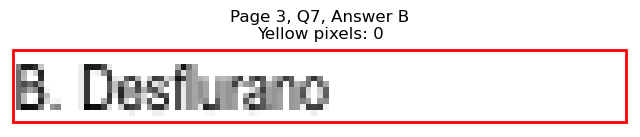

Page 3, Q7 - C: Detected box: x0=315.4, y0=430.2, x1=368.2, y1=442.9
Page 3, Q7, C: Yellow pixels: 0
Page 3, Q7, C: Total non-white pixels: 354
Page 3, Q7, C: Yellow percentage: 0.0%


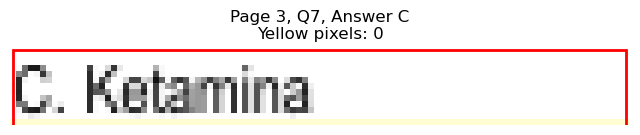

Page 3, Q7 - D: Detected box: x0=315.4, y0=442.8, x1=363.7, y1=455.5
Page 3, Q7, D: Yellow pixels: 1119
Page 3, Q7, D: Total non-white pixels: 1386
Page 3, Q7, D: Yellow percentage: 80.7%


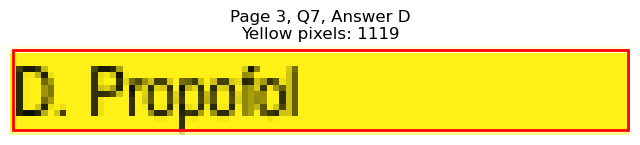


Page 3, Q7 - Selected Answer: D (based on yellow pixel count)
Page 3, Q8 - A: Detected box: x0=56.6, y0=480.8, x1=192.1, y1=493.4
Page 3, Q8, A: Yellow pixels: 0
Page 3, Q8, A: Total non-white pixels: 628
Page 3, Q8, A: Yellow percentage: 0.0%


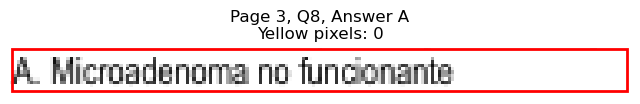

Page 3, Q8 - B: Detected box: x0=56.6, y0=493.4, x1=195.3, y1=506.0
Page 3, Q8, B: Yellow pixels: 0
Page 3, Q8, B: Total non-white pixels: 642
Page 3, Q8, B: Yellow percentage: 0.0%


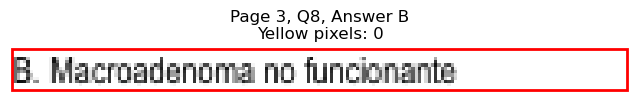

Page 3, Q8 - C: Detected box: x0=315.4, y0=480.8, x1=417.8, y1=493.4
Page 3, Q8, C: Yellow pixels: 1466
Page 3, Q8, C: Total non-white pixels: 2142
Page 3, Q8, C: Yellow percentage: 68.4%


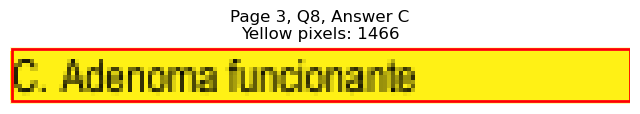

Page 3, Q8 - D: Detected box: x0=315.4, y0=493.4, x1=491.1, y1=506.0
Page 3, Q8, D: Yellow pixels: 0
Page 3, Q8, D: Total non-white pixels: 1034
Page 3, Q8, D: Yellow percentage: 0.0%


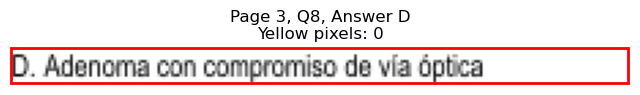


Page 3, Q8 - Selected Answer: C (based on yellow pixel count)
Page 3, Q9 - A: Detected box: x0=56.6, y0=531.2, x1=407.9, y1=543.8
Page 3, Q9, A: Yellow pixels: 3909
Page 3, Q9, A: Total non-white pixels: 5226
Page 3, Q9, A: Yellow percentage: 74.8%


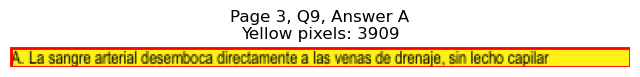

Page 3, Q9 - B: Detected box: x0=56.6, y0=543.8, x1=410.9, y1=556.4
Page 3, Q9, B: Yellow pixels: 397
Page 3, Q9, B: Total non-white pixels: 2082
Page 3, Q9, B: Yellow percentage: 19.1%


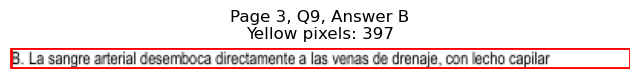

Page 3, Q9 - C: Detected box: x0=56.6, y0=556.5, x1=281.9, y1=569.1
Page 3, Q9, C: Yellow pixels: 0
Page 3, Q9, C: Total non-white pixels: 1110
Page 3, Q9, C: Yellow percentage: 0.0%


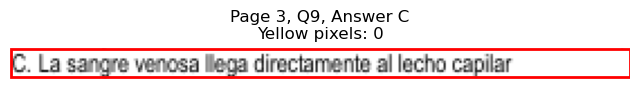

Page 3, Q9 - D: Detected box: x0=56.6, y0=569.1, x1=280.4, y1=581.7
Page 3, Q9, D: Yellow pixels: 0
Page 3, Q9, D: Total non-white pixels: 1131
Page 3, Q9, D: Yellow percentage: 0.0%


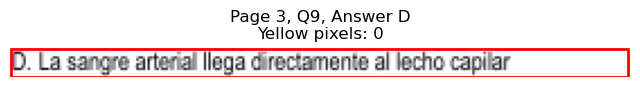


Page 3, Q9 - Selected Answer: A (based on yellow pixel count)
Page 3, Q10 - A: Detected box: x0=56.6, y0=606.9, x1=142.6, y1=619.5
Page 3, Q10, A: Yellow pixels: 0
Page 3, Q10, A: Total non-white pixels: 379
Page 3, Q10, A: Yellow percentage: 0.0%


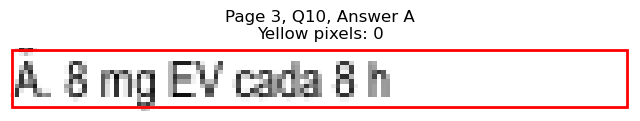

Page 3, Q10 - B: Detected box: x0=56.6, y0=619.6, x1=216.3, y1=632.3
Page 3, Q10, B: Yellow pixels: 0
Page 3, Q10, B: Total non-white pixels: 717
Page 3, Q10, B: Yellow percentage: 0.0%


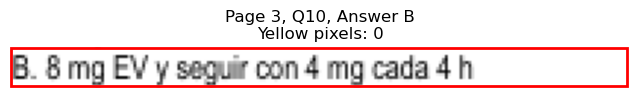

Page 3, Q10 - C: Detected box: x0=315.4, y0=606.9, x1=387.2, y1=619.5
Page 3, Q10, C: Yellow pixels: 0
Page 3, Q10, C: Total non-white pixels: 314
Page 3, Q10, C: Yellow percentage: 0.0%


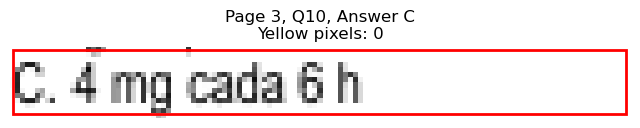

Page 3, Q10 - D: Detected box: x0=315.4, y0=619.6, x1=406.3, y1=632.3
Page 3, Q10, D: Yellow pixels: 1389
Page 3, Q10, D: Total non-white pixels: 1988
Page 3, Q10, D: Yellow percentage: 69.9%


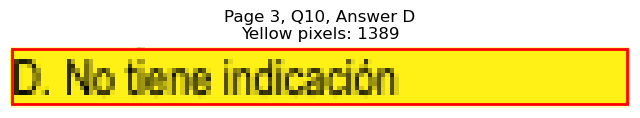


Page 3, Q10 - Selected Answer: D (based on yellow pixel count)
Page 3, Q11 - A: Detected box: x0=56.6, y0=657.4, x1=399.3, y1=670.1
Page 3, Q11, A: Yellow pixels: 3755
Page 3, Q11, A: Total non-white pixels: 5516
Page 3, Q11, A: Yellow percentage: 68.1%


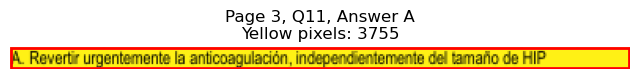

Page 3, Q11 - B: Detected box: x0=56.6, y0=670.0, x1=383.8, y1=682.7
Page 3, Q11, B: Yellow pixels: 0
Page 3, Q11, B: Total non-white pixels: 1913
Page 3, Q11, B: Yellow percentage: 0.0%


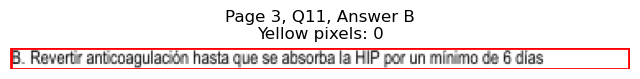

Page 3, Q11 - C: Detected box: x0=56.6, y0=682.6, x1=229.2, y1=695.3
Page 3, Q11, C: Yellow pixels: 0
Page 3, Q11, C: Total non-white pixels: 838
Page 3, Q11, C: Yellow percentage: 0.0%


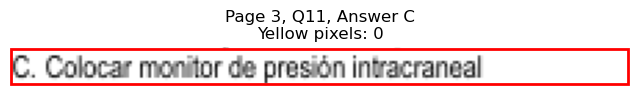

Page 3, Q11 - D: Detected box: x0=56.6, y0=695.4, x1=274.5, y1=708.0
Page 3, Q11, D: Yellow pixels: 0
Page 3, Q11, D: Total non-white pixels: 1043
Page 3, Q11, D: Yellow percentage: 0.0%


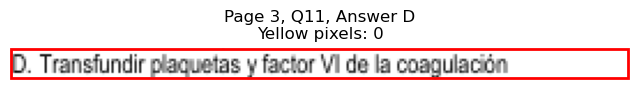


Page 3, Q11 - Selected Answer: A (based on yellow pixel count)
Page 3, Q12 - A: Detected box: x0=56.6, y0=733.2, x1=99.9, y1=745.8
Page 3, Q12, A: Yellow pixels: 0
Page 3, Q12, A: Total non-white pixels: 215
Page 3, Q12, A: Yellow percentage: 0.0%


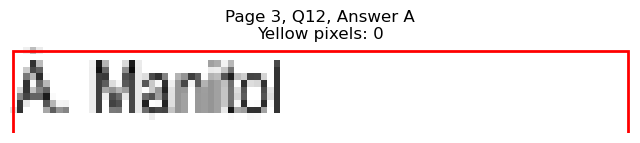

Page 3, Q12 - B: Detected box: x0=56.6, y0=745.8, x1=171.1, y1=758.4
Page 3, Q12, B: Yellow pixels: 0
Page 3, Q12, B: Total non-white pixels: 583
Page 3, Q12, B: Yellow percentage: 0.0%


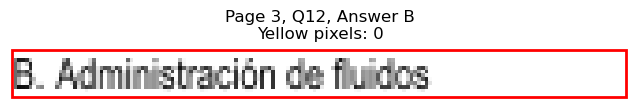

Page 3, Q12 - C: Detected box: x0=315.4, y0=733.2, x1=399.3, y1=745.8
Page 3, Q12, C: Yellow pixels: 0
Page 3, Q12, C: Total non-white pixels: 547
Page 3, Q12, C: Yellow percentage: 0.0%


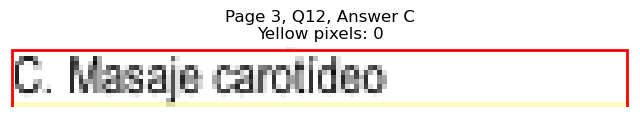

Page 3, Q12 - D: Detected box: x0=315.4, y0=745.8, x1=536.3, y1=758.4
Page 3, Q12, D: Yellow pixels: 2093
Page 3, Q12, D: Total non-white pixels: 3164
Page 3, Q12, D: Yellow percentage: 66.2%


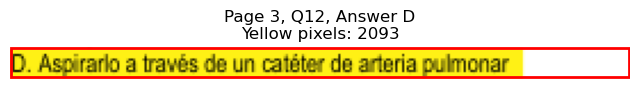


Page 3, Q12 - Selected Answer: D (based on yellow pixel count)

Page 4: Found 11 questions
Page 4, Q1 - A: Detected box: x0=56.6, y0=89.4, x1=79.3, y1=102.1
Page 4, Q1, A: Yellow pixels: 0
Page 4, Q1, A: Total non-white pixels: 73
Page 4, Q1, A: Yellow percentage: 0.0%


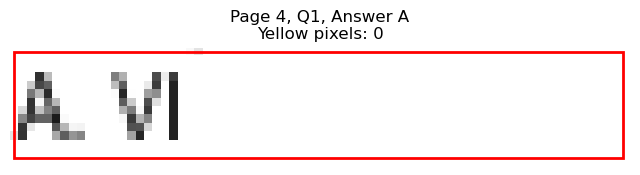

Page 4, Q1 - B: Detected box: x0=56.6, y0=102.0, x1=79.3, y1=114.7
Page 4, Q1, B: Yellow pixels: 0
Page 4, Q1, B: Total non-white pixels: 78
Page 4, Q1, B: Yellow percentage: 0.0%


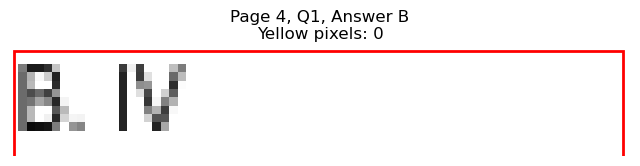

Page 4, Q1 - C: Detected box: x0=315.4, y0=89.4, x1=337.6, y1=102.1
Page 4, Q1, C: Yellow pixels: 883
Page 4, Q1, C: Total non-white pixels: 1022
Page 4, Q1, C: Yellow percentage: 86.4%


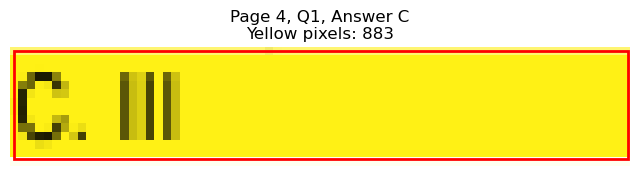

Page 4, Q1 - D: Detected box: x0=315.4, y0=102.0, x1=335.1, y1=114.7
Page 4, Q1, D: Yellow pixels: 0
Page 4, Q1, D: Total non-white pixels: 143
Page 4, Q1, D: Yellow percentage: 0.0%


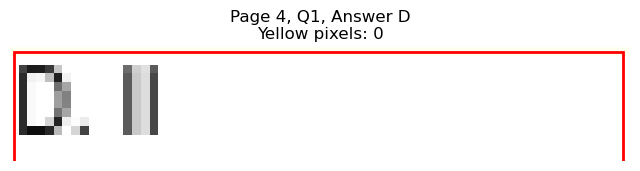


Page 4, Q1 - Selected Answer: C (based on yellow pixel count)
Page 4, Q2 - A: Detected box: x0=56.6, y0=165.1, x1=296.4, y1=177.8
Page 4, Q2, A: Yellow pixels: 0
Page 4, Q2, A: Total non-white pixels: 1447
Page 4, Q2, A: Yellow percentage: 0.0%


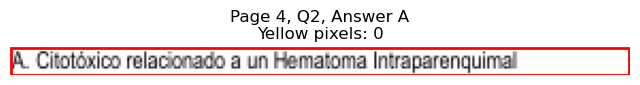

Page 4, Q2 - B: Detected box: x0=56.6, y0=177.7, x1=263.4, y1=190.4
Page 4, Q2, B: Yellow pixels: 2320
Page 4, Q2, B: Total non-white pixels: 3612
Page 4, Q2, B: Yellow percentage: 64.2%


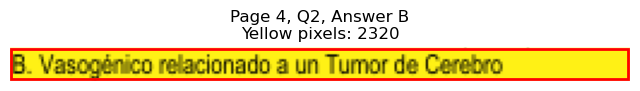

Page 4, Q2 - C: Detected box: x0=56.6, y0=190.3, x1=316.5, y1=203.0
Page 4, Q2, C: Yellow pixels: 1
Page 4, Q2, C: Total non-white pixels: 1572
Page 4, Q2, C: Yellow percentage: 0.1%


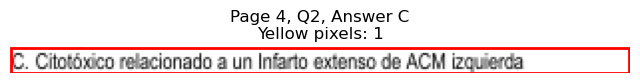

Page 4, Q2 - D: Detected box: x0=56.6, y0=202.9, x1=309.0, y1=215.6
Page 4, Q2, D: Yellow pixels: 0
Page 4, Q2, D: Total non-white pixels: 1206
Page 4, Q2, D: Yellow percentage: 0.0%


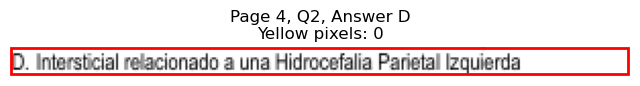


Page 4, Q2 - Selected Answer: B (based on yellow pixel count)
Page 4, Q3 - A: Detected box: x0=56.6, y0=240.8, x1=130.5, y1=253.5
Page 4, Q3, A: Yellow pixels: 0
Page 4, Q3, A: Total non-white pixels: 338
Page 4, Q3, A: Yellow percentage: 0.0%


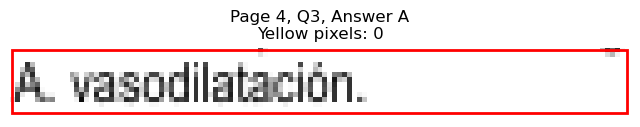

Page 4, Q3 - B: Detected box: x0=56.6, y0=253.4, x1=153.5, y1=266.1
Page 4, Q3, B: Yellow pixels: 0
Page 4, Q3, B: Total non-white pixels: 476
Page 4, Q3, B: Yellow percentage: 0.0%


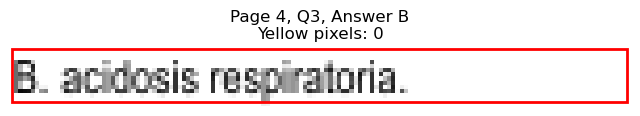

Page 4, Q3 - C: Detected box: x0=315.4, y0=240.8, x1=399.3, y1=253.5
Page 4, Q3, C: Yellow pixels: 1450
Page 4, Q3, C: Total non-white pixels: 1890
Page 4, Q3, C: Yellow percentage: 76.7%


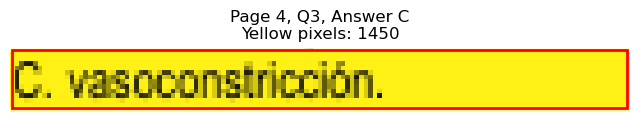

Page 4, Q3 - D: Detected box: x0=315.4, y0=253.4, x1=382.3, y1=266.1
Page 4, Q3, D: Yellow pixels: 118
Page 4, Q3, D: Total non-white pixels: 417
Page 4, Q3, D: Yellow percentage: 28.3%


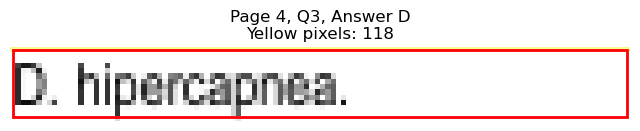


Page 4, Q3 - Selected Answer: C (based on yellow pixel count)
Page 4, Q4 - A: Detected box: x0=56.6, y0=304.0, x1=90.9, y1=316.6
Page 4, Q4, A: Yellow pixels: 0
Page 4, Q4, A: Total non-white pixels: 204
Page 4, Q4, A: Yellow percentage: 0.0%


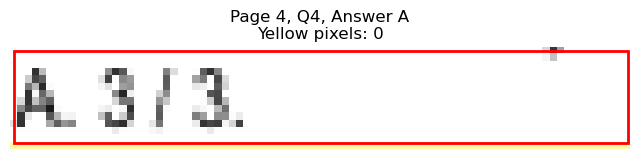

Page 4, Q4 - B: Detected box: x0=56.6, y0=316.6, x1=90.9, y1=329.2
Page 4, Q4, B: Yellow pixels: 927
Page 4, Q4, B: Total non-white pixels: 1190
Page 4, Q4, B: Yellow percentage: 77.9%


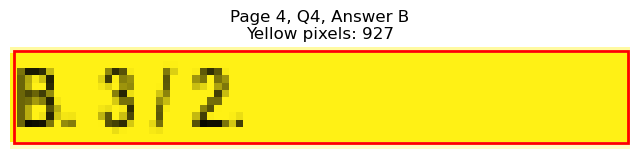

Page 4, Q4 - C: Detected box: x0=315.4, y0=304.0, x1=350.1, y1=316.6
Page 4, Q4, C: Yellow pixels: 0
Page 4, Q4, C: Total non-white pixels: 116
Page 4, Q4, C: Yellow percentage: 0.0%


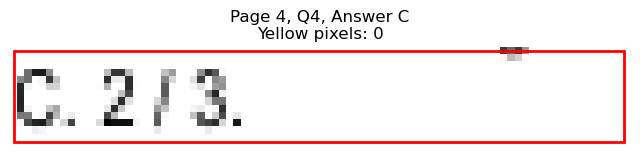

Page 4, Q4 - D: Detected box: x0=315.4, y0=316.6, x1=350.1, y1=329.2
Page 4, Q4, D: Yellow pixels: 0
Page 4, Q4, D: Total non-white pixels: 109
Page 4, Q4, D: Yellow percentage: 0.0%


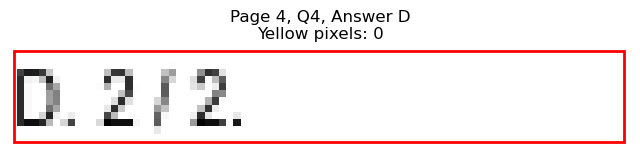


Page 4, Q4 - Selected Answer: B (based on yellow pixel count)
Page 4, Q5 - A: Detected box: x0=56.6, y0=354.5, x1=96.9, y1=367.2
Page 4, Q5, A: Yellow pixels: 0
Page 4, Q5, A: Total non-white pixels: 171
Page 4, Q5, A: Yellow percentage: 0.0%


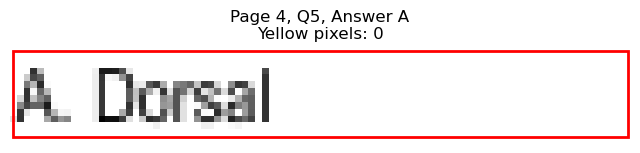

Page 4, Q5 - B: Detected box: x0=56.6, y0=367.1, x1=103.3, y1=379.8
Page 4, Q5, B: Yellow pixels: 0
Page 4, Q5, B: Total non-white pixels: 219
Page 4, Q5, B: Yellow percentage: 0.0%


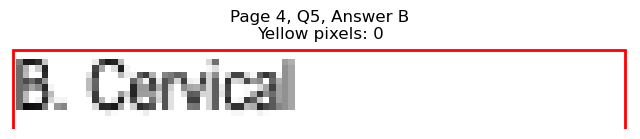

Page 4, Q5 - C: Detected box: x0=315.4, y0=354.5, x1=380.2, y1=367.2
Page 4, Q5, C: Yellow pixels: 1296
Page 4, Q5, C: Total non-white pixels: 1624
Page 4, Q5, C: Yellow percentage: 79.8%


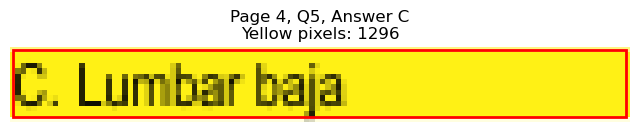

Page 4, Q5 - D: Detected box: x0=315.4, y0=367.1, x1=381.7, y1=379.8
Page 4, Q5, D: Yellow pixels: 0
Page 4, Q5, D: Total non-white pixels: 428
Page 4, Q5, D: Yellow percentage: 0.0%


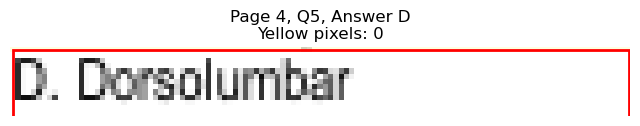


Page 4, Q5 - Selected Answer: C (based on yellow pixel count)
Page 4, Q6 - A: Detected box: x0=56.6, y0=404.9, x1=216.3, y1=417.6
Page 4, Q6, A: Yellow pixels: 0
Page 4, Q6, A: Total non-white pixels: 792
Page 4, Q6, A: Yellow percentage: 0.0%


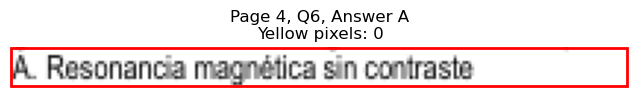

Page 4, Q6 - B: Detected box: x0=56.6, y0=417.6, x1=173.7, y1=430.3
Page 4, Q6, B: Yellow pixels: 0
Page 4, Q6, B: Total non-white pixels: 553
Page 4, Q6, B: Yellow percentage: 0.0%


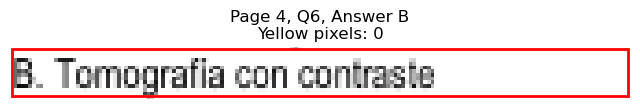

Page 4, Q6 - C: Detected box: x0=315.4, y0=404.9, x1=478.5, y1=417.6
Page 4, Q6, C: Yellow pixels: 2190
Page 4, Q6, C: Total non-white pixels: 2996
Page 4, Q6, C: Yellow percentage: 73.1%


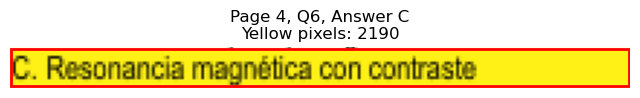

Page 4, Q6 - D: Detected box: x0=315.4, y0=417.6, x1=374.7, y1=430.3
Page 4, Q6, D: Yellow pixels: 109
Page 4, Q6, D: Total non-white pixels: 416
Page 4, Q6, D: Yellow percentage: 26.2%


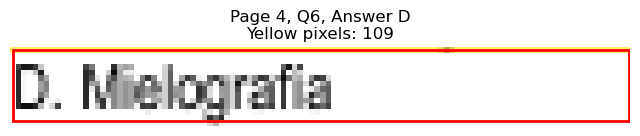


Page 4, Q6 - Selected Answer: C (based on yellow pixel count)
Page 4, Q7 - A: Detected box: x0=56.6, y0=455.5, x1=162.1, y1=468.1
Page 4, Q7, A: Yellow pixels: 0
Page 4, Q7, A: Total non-white pixels: 530
Page 4, Q7, A: Yellow percentage: 0.0%


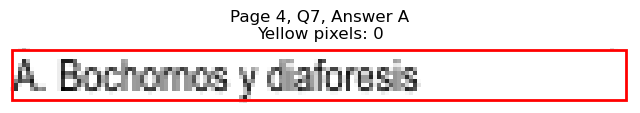

Page 4, Q7 - B: Detected box: x0=56.6, y0=468.1, x1=124.5, y1=480.7
Page 4, Q7, B: Yellow pixels: 0
Page 4, Q7, B: Total non-white pixels: 335
Page 4, Q7, B: Yellow percentage: 0.0%


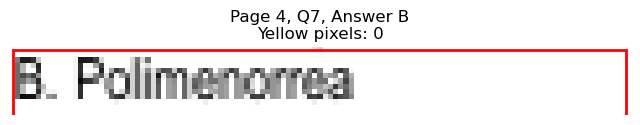

Page 4, Q7 - C: Detected box: x0=315.4, y0=455.5, x1=462.5, y1=468.1
Page 4, Q7, C: Yellow pixels: 198
Page 4, Q7, C: Total non-white pixels: 908
Page 4, Q7, C: Yellow percentage: 21.8%


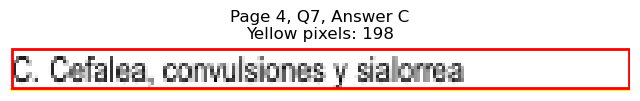

Page 4, Q7 - D: Detected box: x0=315.4, y0=468.1, x1=476.0, y1=480.7
Page 4, Q7, D: Yellow pixels: 2136
Page 4, Q7, D: Total non-white pixels: 2756
Page 4, Q7, D: Yellow percentage: 77.5%


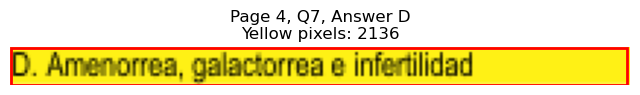


Page 4, Q7 - Selected Answer: D (based on yellow pixel count)
Page 4, Q8 - A: Detected box: x0=56.6, y0=518.6, x1=223.2, y1=531.2
Page 4, Q8, A: Yellow pixels: 218
Page 4, Q8, A: Total non-white pixels: 1029
Page 4, Q8, A: Yellow percentage: 21.2%


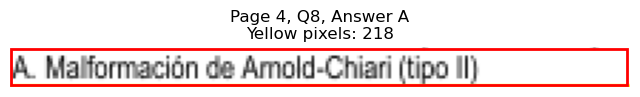

Page 4, Q8 - B: Detected box: x0=56.6, y0=531.2, x1=198.3, y1=543.8
Page 4, Q8, B: Yellow pixels: 1975
Page 4, Q8, B: Total non-white pixels: 2509
Page 4, Q8, B: Yellow percentage: 78.7%


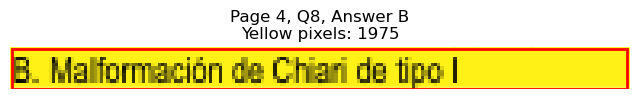

Page 4, Q8 - C: Detected box: x0=315.4, y0=518.6, x1=456.4, y1=531.2
Page 4, Q8, C: Yellow pixels: 0
Page 4, Q8, C: Total non-white pixels: 681
Page 4, Q8, C: Yellow percentage: 0.0%


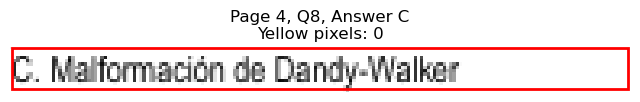

Page 4, Q8 - D: Detected box: x0=315.4, y0=531.2, x1=414.3, y1=543.8
Page 4, Q8, D: Yellow pixels: 0
Page 4, Q8, D: Total non-white pixels: 473
Page 4, Q8, D: Yellow percentage: 0.0%


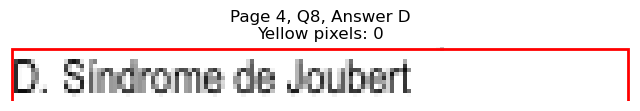


Page 4, Q8 - Selected Answer: B (based on yellow pixel count)
Page 4, Q9 - A: Detected box: x0=56.6, y0=581.7, x1=183.6, y1=594.3
Page 4, Q9, A: Yellow pixels: 0
Page 4, Q9, A: Total non-white pixels: 629
Page 4, Q9, A: Yellow percentage: 0.0%


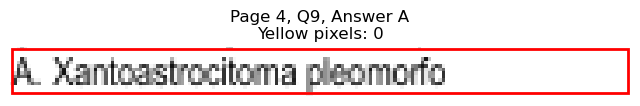

Page 4, Q9 - B: Detected box: x0=56.6, y0=594.3, x1=164.1, y1=606.9
Page 4, Q9, B: Yellow pixels: 0
Page 4, Q9, B: Total non-white pixels: 531
Page 4, Q9, B: Yellow percentage: 0.0%


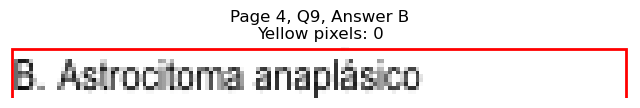

Page 4, Q9 - C: Detected box: x0=315.4, y0=581.7, x1=448.9, y1=594.3
Page 4, Q9, C: Yellow pixels: 184
Page 4, Q9, C: Total non-white pixels: 837
Page 4, Q9, C: Yellow percentage: 22.0%


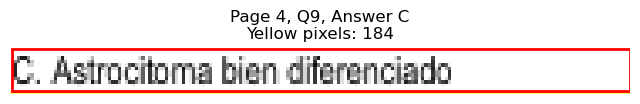

Page 4, Q9 - D: Detected box: x0=315.4, y0=594.3, x1=443.3, y1=606.9
Page 4, Q9, D: Yellow pixels: 1857
Page 4, Q9, D: Total non-white pixels: 2327
Page 4, Q9, D: Yellow percentage: 79.8%


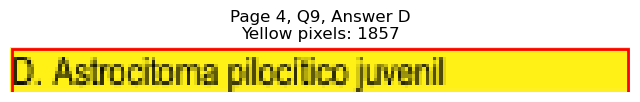


Page 4, Q9 - Selected Answer: D (based on yellow pixel count)
Page 4, Q10 - A: Detected box: x0=56.6, y0=632.2, x1=221.3, y1=644.9
Page 4, Q10, A: Yellow pixels: 2181
Page 4, Q10, A: Total non-white pixels: 2808
Page 4, Q10, A: Yellow percentage: 77.7%


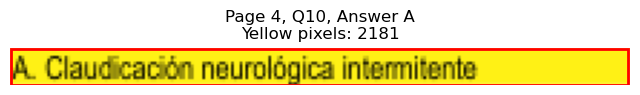

Page 4, Q10 - B: Detected box: x0=56.6, y0=644.8, x1=209.7, y1=657.5
Page 4, Q10, B: Yellow pixels: 0
Page 4, Q10, B: Total non-white pixels: 815
Page 4, Q10, B: Yellow percentage: 0.0%


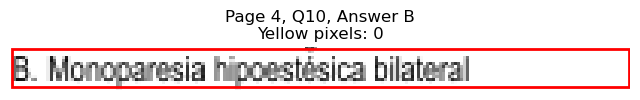

Page 4, Q10 - C: Detected box: x0=315.4, y0=632.2, x1=474.9, y1=644.9
Page 4, Q10, C: Yellow pixels: 0
Page 4, Q10, C: Total non-white pixels: 787
Page 4, Q10, C: Yellow percentage: 0.0%


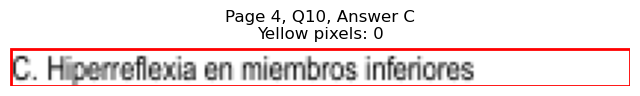

Page 4, Q10 - D: Detected box: x0=315.4, y0=644.8, x1=455.9, y1=657.5
Page 4, Q10, D: Yellow pixels: 0
Page 4, Q10, D: Total non-white pixels: 692
Page 4, Q10, D: Yellow percentage: 0.0%


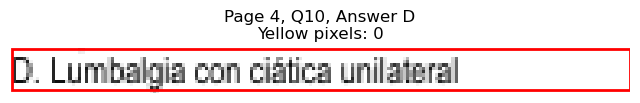


Page 4, Q10 - Selected Answer: A (based on yellow pixel count)
Page 4, Q11 - A: Detected box: x0=56.6, y0=695.4, x1=429.1, y1=708.0
Page 4, Q11, A: Yellow pixels: 4080
Page 4, Q11, A: Total non-white pixels: 5523
Page 4, Q11, A: Yellow percentage: 73.9%


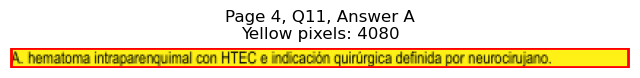

Page 4, Q11 - B: Detected box: x0=56.6, y0=708.0, x1=305.6, y1=720.6
Page 4, Q11, B: Yellow pixels: 290
Page 4, Q11, B: Total non-white pixels: 1485
Page 4, Q11, B: Yellow percentage: 19.5%


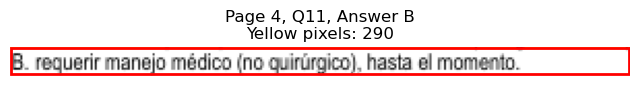

Page 4, Q11 - C: Detected box: x0=56.6, y0=720.6, x1=264.4, y1=733.2
Page 4, Q11, C: Yellow pixels: 0
Page 4, Q11, C: Total non-white pixels: 991
Page 4, Q11, C: Yellow percentage: 0.0%


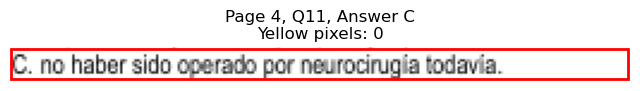

Page 4, Q11 - D: Detected box: x0=56.6, y0=733.2, x1=254.9, y1=745.8
Page 4, Q11, D: Yellow pixels: 0
Page 4, Q11, D: Total non-white pixels: 971
Page 4, Q11, D: Yellow percentage: 0.0%


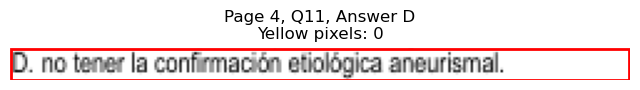


Page 4, Q11 - Selected Answer: A (based on yellow pixel count)

Page 5: Found 10 questions
Page 5, Q1 - A: Detected box: x0=56.6, y0=102.0, x1=105.9, y1=114.7
Page 5, Q1, A: Yellow pixels: 0
Page 5, Q1, A: Total non-white pixels: 231
Page 5, Q1, A: Yellow percentage: 0.0%


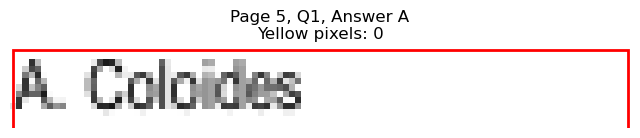

Page 5, Q1 - B: Detected box: x0=56.6, y0=114.6, x1=118.6, y1=127.3
Page 5, Q1, B: Yellow pixels: 0
Page 5, Q1, B: Total non-white pixels: 293
Page 5, Q1, B: Yellow percentage: 0.0%


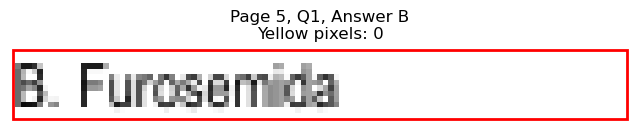

Page 5, Q1 - C: Detected box: x0=315.4, y0=102.0, x1=420.8, y1=114.7
Page 5, Q1, C: Yellow pixels: 1649
Page 5, Q1, C: Total non-white pixels: 2028
Page 5, Q1, C: Yellow percentage: 81.3%


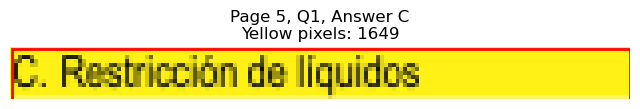

Page 5, Q1 - D: Detected box: x0=315.4, y0=114.6, x1=390.8, y1=127.3
Page 5, Q1, D: Yellow pixels: 126
Page 5, Q1, D: Total non-white pixels: 483
Page 5, Q1, D: Yellow percentage: 26.1%


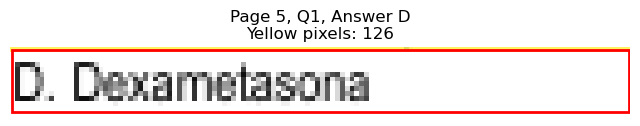


Page 5, Q1 - Selected Answer: C (based on yellow pixel count)
Page 5, Q2 - A: Detected box: x0=56.6, y0=165.1, x1=158.5, y1=177.8
Page 5, Q2, A: Yellow pixels: 0
Page 5, Q2, A: Total non-white pixels: 497
Page 5, Q2, A: Yellow percentage: 0.0%


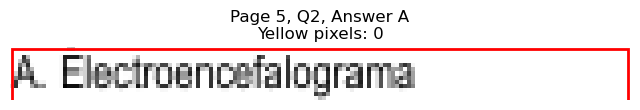

Page 5, Q2 - B: Detected box: x0=56.6, y0=177.7, x1=194.2, y1=190.4
Page 5, Q2, B: Yellow pixels: 0
Page 5, Q2, B: Total non-white pixels: 678
Page 5, Q2, B: Yellow percentage: 0.0%


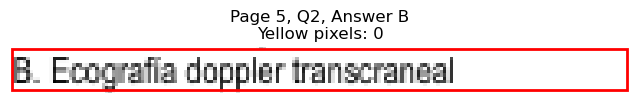

Page 5, Q2 - C: Detected box: x0=315.4, y0=165.1, x1=530.7, y1=177.8
Page 5, Q2, C: Yellow pixels: 1
Page 5, Q2, C: Total non-white pixels: 1264
Page 5, Q2, C: Yellow percentage: 0.1%


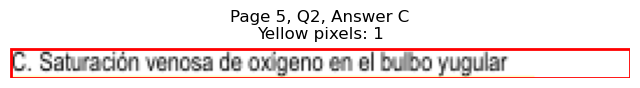

Page 5, Q2 - D: Detected box: x0=315.4, y0=177.7, x1=404.2, y1=190.4
Page 5, Q2, D: Yellow pixels: 1353
Page 5, Q2, D: Total non-white pixels: 1960
Page 5, Q2, D: Yellow percentage: 69.0%


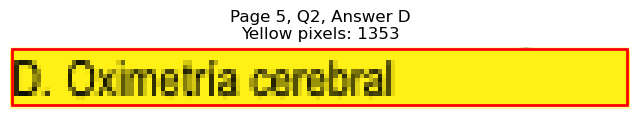


Page 5, Q2 - Selected Answer: D (based on yellow pixel count)
Page 5, Q3 - A: Detected box: x0=56.6, y0=215.6, x1=75.9, y1=228.3
Page 5, Q3, A: Yellow pixels: 0
Page 5, Q3, A: Total non-white pixels: 73
Page 5, Q3, A: Yellow percentage: 0.0%


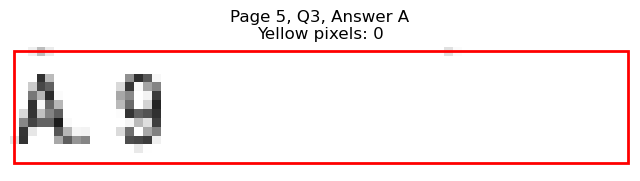

Page 5, Q3 - B: Detected box: x0=56.6, y0=228.2, x1=80.9, y1=240.9
Page 5, Q3, B: Yellow pixels: 0
Page 5, Q3, B: Total non-white pixels: 93
Page 5, Q3, B: Yellow percentage: 0.0%


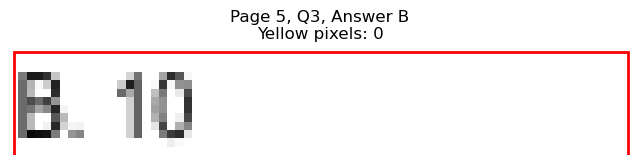

Page 5, Q3 - C: Detected box: x0=315.4, y0=215.6, x1=340.1, y1=228.3
Page 5, Q3, C: Yellow pixels: 76
Page 5, Q3, C: Total non-white pixels: 139
Page 5, Q3, C: Yellow percentage: 54.7%


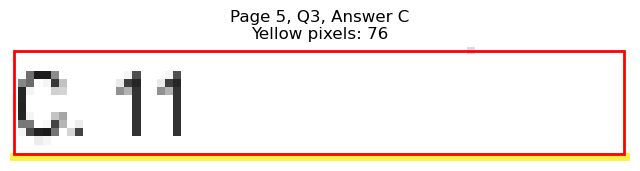

Page 5, Q3 - D: Detected box: x0=315.4, y0=228.2, x1=335.1, y1=240.9
Page 5, Q3, D: Yellow pixels: 869
Page 5, Q3, D: Total non-white pixels: 923
Page 5, Q3, D: Yellow percentage: 94.1%


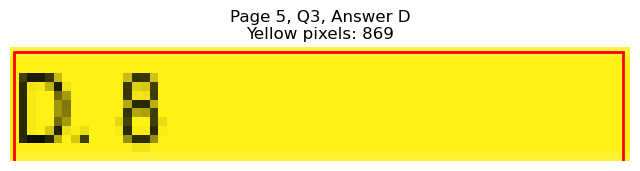


Page 5, Q3 - Selected Answer: D (based on yellow pixel count)
Page 5, Q4 - A: Detected box: x0=56.6, y0=266.0, x1=160.6, y1=278.7
Page 5, Q4, A: Yellow pixels: 0
Page 5, Q4, A: Total non-white pixels: 491
Page 5, Q4, A: Yellow percentage: 0.0%


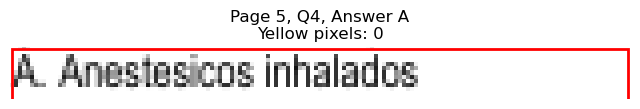

Page 5, Q4 - B: Detected box: x0=56.6, y0=278.8, x1=117.4, y1=291.4
Page 5, Q4, B: Yellow pixels: 0
Page 5, Q4, B: Total non-white pixels: 305
Page 5, Q4, B: Yellow percentage: 0.0%


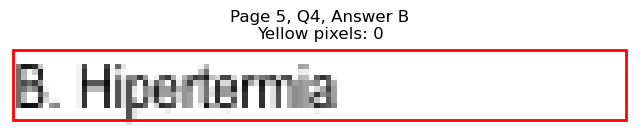

Page 5, Q4 - C: Detected box: x0=315.4, y0=266.0, x1=437.3, y1=278.7
Page 5, Q4, C: Yellow pixels: 1788
Page 5, Q4, C: Total non-white pixels: 2249
Page 5, Q4, C: Yellow percentage: 79.5%


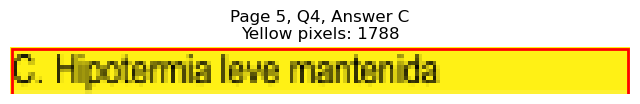

Page 5, Q4 - D: Detected box: x0=315.4, y0=278.8, x1=421.3, y1=291.4
Page 5, Q4, D: Yellow pixels: 157
Page 5, Q4, D: Total non-white pixels: 691
Page 5, Q4, D: Yellow percentage: 22.7%


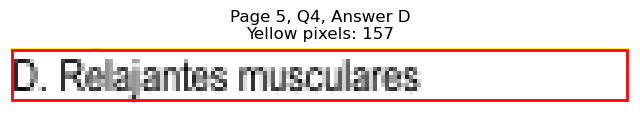


Page 5, Q4 - Selected Answer: C (based on yellow pixel count)
Page 5, Q5 - A: Detected box: x0=56.6, y0=316.6, x1=109.0, y1=329.2
Page 5, Q5, A: Yellow pixels: 1056
Page 5, Q5, A: Total non-white pixels: 1442
Page 5, Q5, A: Yellow percentage: 73.2%


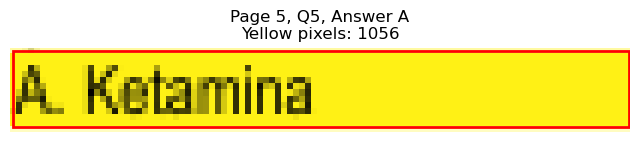

Page 5, Q5 - B: Detected box: x0=56.6, y0=329.2, x1=104.4, y1=341.8
Page 5, Q5, B: Yellow pixels: 0
Page 5, Q5, B: Total non-white pixels: 332
Page 5, Q5, B: Yellow percentage: 0.0%


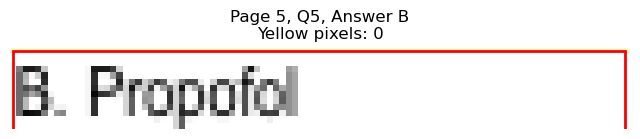

Page 5, Q5 - C: Detected box: x0=315.4, y0=316.6, x1=398.9, y1=329.2
Page 5, Q5, C: Yellow pixels: 0
Page 5, Q5, C: Total non-white pixels: 417
Page 5, Q5, C: Yellow percentage: 0.0%


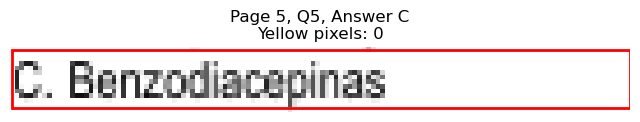

Page 5, Q5 - D: Detected box: x0=315.4, y0=329.2, x1=377.7, y1=341.8
Page 5, Q5, D: Yellow pixels: 0
Page 5, Q5, D: Total non-white pixels: 293
Page 5, Q5, D: Yellow percentage: 0.0%


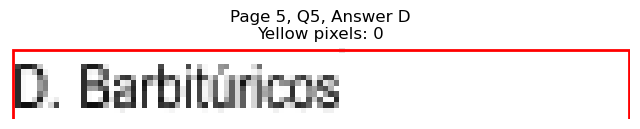


Page 5, Q5 - Selected Answer: A (based on yellow pixel count)
Page 5, Q6 - A: Detected box: x0=56.6, y0=392.3, x1=119.9, y1=405.0
Page 5, Q6, A: Yellow pixels: 0
Page 5, Q6, A: Total non-white pixels: 324
Page 5, Q6, A: Yellow percentage: 0.0%


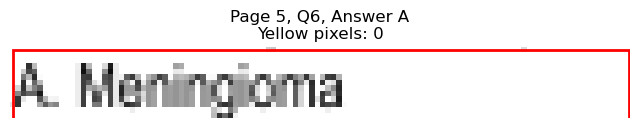

Page 5, Q6 - B: Detected box: x0=56.6, y0=404.9, x1=128.5, y1=417.6
Page 5, Q6, B: Yellow pixels: 0
Page 5, Q6, B: Total non-white pixels: 345
Page 5, Q6, B: Yellow percentage: 0.0%


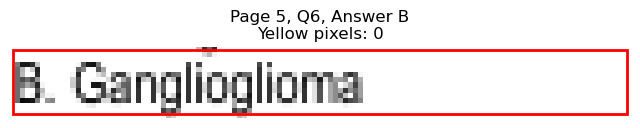

Page 5, Q6 - C: Detected box: x0=315.4, y0=392.3, x1=396.3, y1=405.0
Page 5, Q6, C: Yellow pixels: 0
Page 5, Q6, C: Total non-white pixels: 548
Page 5, Q6, C: Yellow percentage: 0.0%


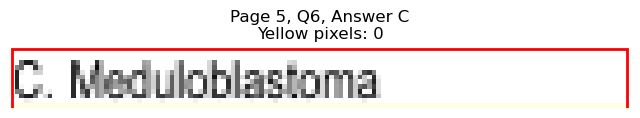

Page 5, Q6 - D: Detected box: x0=315.4, y0=404.9, x1=405.8, y1=417.6
Page 5, Q6, D: Yellow pixels: 1511
Page 5, Q6, D: Total non-white pixels: 1974
Page 5, Q6, D: Yellow percentage: 76.5%


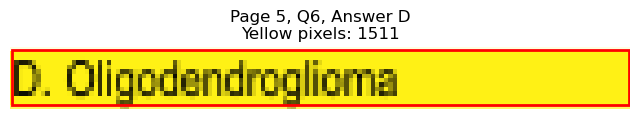


Page 5, Q6 - Selected Answer: D (based on yellow pixel count)
Page 5, Q7 - A: Detected box: x0=56.6, y0=468.1, x1=264.3, y1=480.7
Page 5, Q7, A: Yellow pixels: 0
Page 5, Q7, A: Total non-white pixels: 1035
Page 5, Q7, A: Yellow percentage: 0.0%


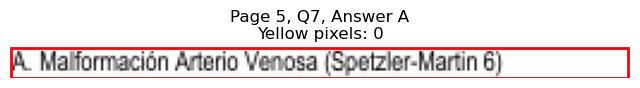

Page 5, Q7 - B: Detected box: x0=56.6, y0=480.8, x1=264.3, y1=493.4
Page 5, Q7, B: Yellow pixels: 12
Page 5, Q7, B: Total non-white pixels: 1070
Page 5, Q7, B: Yellow percentage: 1.1%


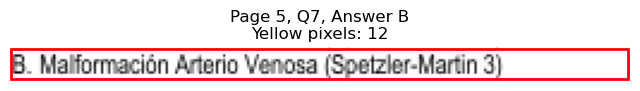

Page 5, Q7 - C: Detected box: x0=315.4, y0=468.1, x1=443.2, y1=480.7
Page 5, Q7, C: Yellow pixels: 0
Page 5, Q7, C: Total non-white pixels: 573
Page 5, Q7, C: Yellow percentage: 0.0%


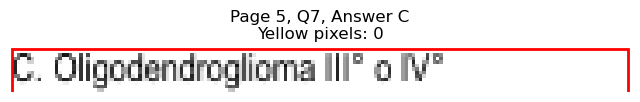

Page 5, Q7 - D: Detected box: x0=315.4, y0=480.8, x1=523.5, y1=493.4
Page 5, Q7, D: Yellow pixels: 1901
Page 5, Q7, D: Total non-white pixels: 3164
Page 5, Q7, D: Yellow percentage: 60.1%


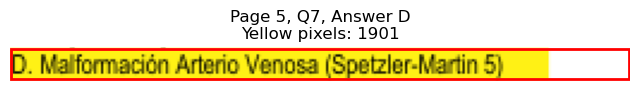


Page 5, Q7 - Selected Answer: D (based on yellow pixel count)
Page 5, Q8 - A: Detected box: x0=56.6, y0=556.5, x1=287.1, y1=569.1
Page 5, Q8, A: Yellow pixels: 282
Page 5, Q8, A: Total non-white pixels: 1414
Page 5, Q8, A: Yellow percentage: 19.9%


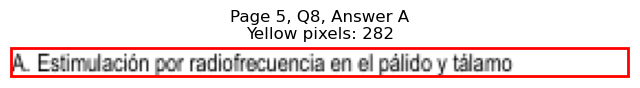

Page 5, Q8 - B: Detected box: x0=56.6, y0=569.1, x1=355.3, y1=581.7
Page 5, Q8, B: Yellow pixels: 3384
Page 5, Q8, B: Total non-white pixels: 4550
Page 5, Q8, B: Yellow percentage: 74.4%


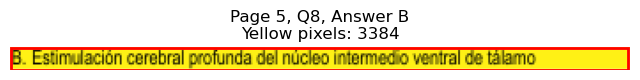

Page 5, Q8 - C: Detected box: x0=56.6, y0=581.7, x1=280.5, y1=594.3
Page 5, Q8, C: Yellow pixels: 275
Page 5, Q8, C: Total non-white pixels: 1389
Page 5, Q8, C: Yellow percentage: 19.8%


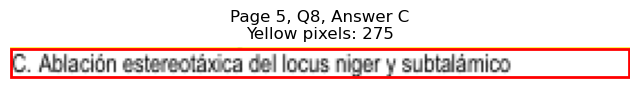

Page 5, Q8 - D: Detected box: x0=56.6, y0=594.3, x1=188.2, y1=606.9
Page 5, Q8, D: Yellow pixels: 0
Page 5, Q8, D: Total non-white pixels: 640
Page 5, Q8, D: Yellow percentage: 0.0%


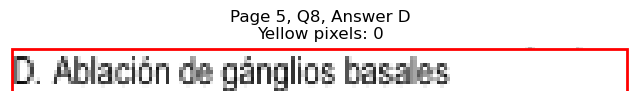


Page 5, Q8 - Selected Answer: B (based on yellow pixel count)
Page 5, Q9 - A: Detected box: x0=56.6, y0=644.8, x1=238.4, y1=657.5
Page 5, Q9, A: Yellow pixels: 0
Page 5, Q9, A: Total non-white pixels: 891
Page 5, Q9, A: Yellow percentage: 0.0%


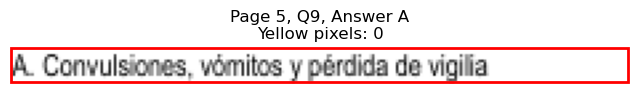

Page 5, Q9 - B: Detected box: x0=56.6, y0=657.4, x1=162.1, y1=670.1
Page 5, Q9, B: Yellow pixels: 0
Page 5, Q9, B: Total non-white pixels: 522
Page 5, Q9, B: Yellow percentage: 0.0%


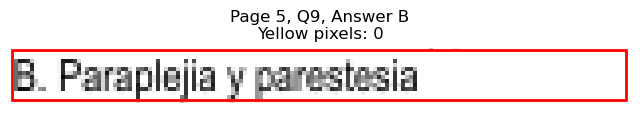

Page 5, Q9 - C: Detected box: x0=315.4, y0=644.8, x1=483.6, y1=657.5
Page 5, Q9, C: Yellow pixels: 2211
Page 5, Q9, C: Total non-white pixels: 3066
Page 5, Q9, C: Yellow percentage: 72.1%


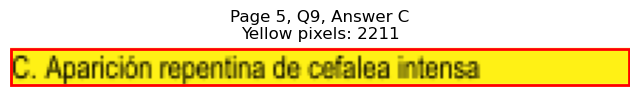

Page 5, Q9 - D: Detected box: x0=315.4, y0=657.4, x1=427.4, y1=670.1
Page 5, Q9, D: Yellow pixels: 163
Page 5, Q9, D: Total non-white pixels: 721
Page 5, Q9, D: Yellow percentage: 22.6%


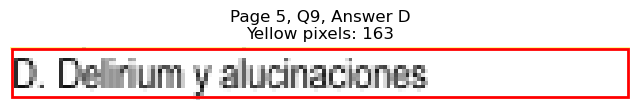


Page 5, Q9 - Selected Answer: C (based on yellow pixel count)
Page 5, Q10 - A: Detected box: x0=56.6, y0=720.6, x1=73.3, y1=733.2
Page 5, Q10, A: Yellow pixels: 0
Page 5, Q10, A: Total non-white pixels: 46
Page 5, Q10, A: Yellow percentage: 0.0%


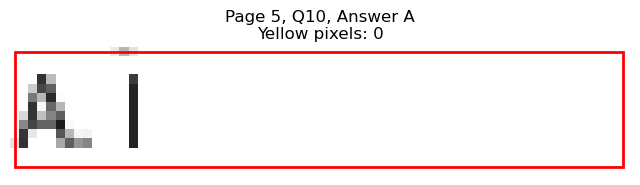

Page 5, Q10 - B: Detected box: x0=56.6, y0=733.2, x1=75.9, y1=745.8
Page 5, Q10, B: Yellow pixels: 0
Page 5, Q10, B: Total non-white pixels: 66
Page 5, Q10, B: Yellow percentage: 0.0%


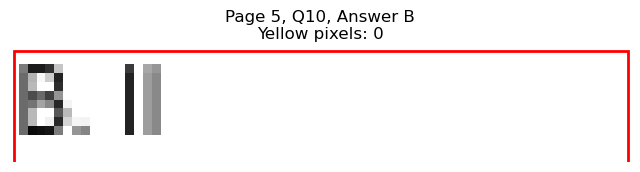

Page 5, Q10 - C: Detected box: x0=315.4, y0=720.6, x1=338.6, y1=733.2
Page 5, Q10, C: Yellow pixels: 74
Page 5, Q10, C: Total non-white pixels: 152
Page 5, Q10, C: Yellow percentage: 48.7%


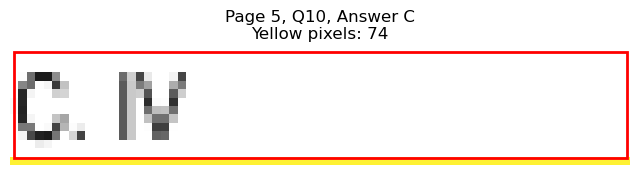

Page 5, Q10 - D: Detected box: x0=315.4, y0=733.2, x1=337.6, y1=745.8
Page 5, Q10, D: Yellow pixels: 879
Page 5, Q10, D: Total non-white pixels: 949
Page 5, Q10, D: Yellow percentage: 92.6%


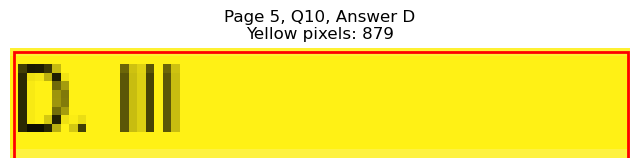


Page 5, Q10 - Selected Answer: D (based on yellow pixel count)

Page 6: Found 10 questions
Page 6, Q1 - A: Detected box: x0=56.6, y0=89.4, x1=126.1, y1=102.1
Page 6, Q1, A: Yellow pixels: 121
Page 6, Q1, A: Total non-white pixels: 449
Page 6, Q1, A: Yellow percentage: 26.9%


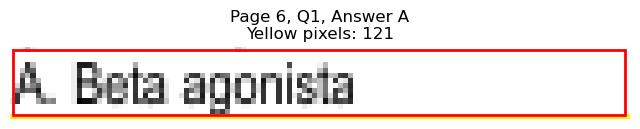

Page 6, Q1 - B: Detected box: x0=56.6, y0=102.0, x1=130.5, y1=114.7
Page 6, Q1, B: Yellow pixels: 1333
Page 6, Q1, B: Total non-white pixels: 1625
Page 6, Q1, B: Yellow percentage: 82.0%


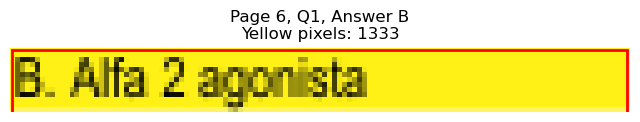

Page 6, Q1 - C: Detected box: x0=315.4, y0=89.4, x1=386.7, y1=102.1
Page 6, Q1, C: Yellow pixels: 0
Page 6, Q1, C: Total non-white pixels: 356
Page 6, Q1, C: Yellow percentage: 0.0%


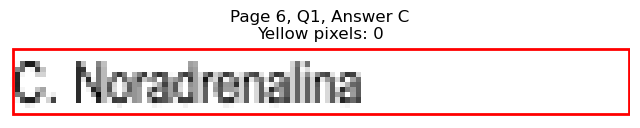

Page 6, Q1 - D: Detected box: x0=315.4, y0=102.0, x1=373.1, y1=114.7
Page 6, Q1, D: Yellow pixels: 0
Page 6, Q1, D: Total non-white pixels: 264
Page 6, Q1, D: Yellow percentage: 0.0%


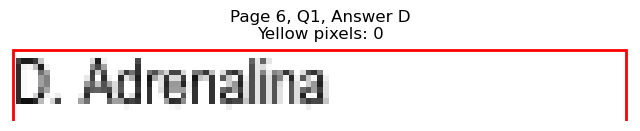


Page 6, Q1 - Selected Answer: B (based on yellow pixel count)
Page 6, Q2 - A: Detected box: x0=56.6, y0=165.1, x1=121.5, y1=177.8
Page 6, Q2, A: Yellow pixels: 1240
Page 6, Q2, A: Total non-white pixels: 1508
Page 6, Q2, A: Yellow percentage: 82.2%


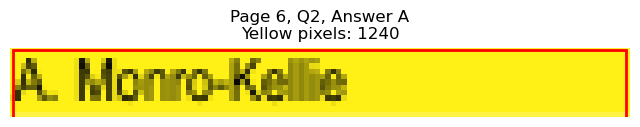

Page 6, Q2 - B: Detected box: x0=56.6, y0=177.7, x1=119.4, y1=190.4
Page 6, Q2, B: Yellow pixels: 114
Page 6, Q2, B: Total non-white pixels: 413
Page 6, Q2, B: Yellow percentage: 27.6%


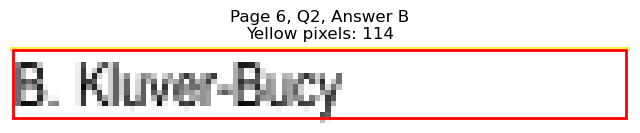

Page 6, Q2 - C: Detected box: x0=315.4, y0=165.1, x1=386.7, y1=177.8
Page 6, Q2, C: Yellow pixels: 0
Page 6, Q2, C: Total non-white pixels: 356
Page 6, Q2, C: Yellow percentage: 0.0%


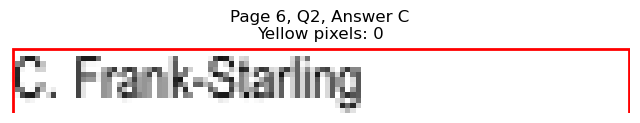

Page 6, Q2 - D: Detected box: x0=315.4, y0=177.7, x1=360.7, y1=190.4
Page 6, Q2, D: Yellow pixels: 0
Page 6, Q2, D: Total non-white pixels: 207
Page 6, Q2, D: Yellow percentage: 0.0%


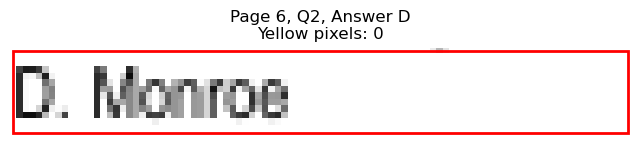


Page 6, Q2 - Selected Answer: A (based on yellow pixel count)
Page 6, Q3 - A: Detected box: x0=56.6, y0=228.2, x1=211.8, y1=240.9
Page 6, Q3, A: Yellow pixels: 0
Page 6, Q3, A: Total non-white pixels: 736
Page 6, Q3, A: Yellow percentage: 0.0%


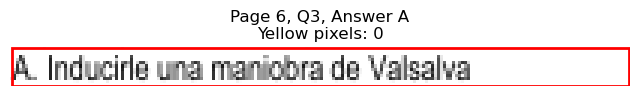

Page 6, Q3 - B: Detected box: x0=56.6, y0=240.8, x1=184.6, y1=253.5
Page 6, Q3, B: Yellow pixels: 0
Page 6, Q3, B: Total non-white pixels: 668
Page 6, Q3, B: Yellow percentage: 0.0%


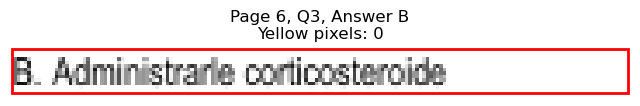

Page 6, Q3 - C: Detected box: x0=315.4, y0=228.2, x1=421.9, y1=240.9
Page 6, Q3, C: Yellow pixels: 0
Page 6, Q3, C: Total non-white pixels: 683
Page 6, Q3, C: Yellow percentage: 0.0%


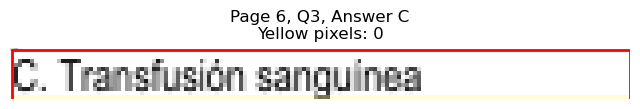

Page 6, Q3 - D: Detected box: x0=315.4, y0=240.8, x1=541.2, y1=253.5
Page 6, Q3, D: Yellow pixels: 2072
Page 6, Q3, D: Total non-white pixels: 3164
Page 6, Q3, D: Yellow percentage: 65.5%


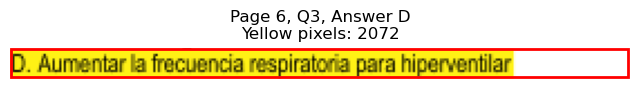


Page 6, Q3 - Selected Answer: D (based on yellow pixel count)
Page 6, Q4 - A: Detected box: x0=56.6, y0=291.4, x1=101.9, y1=304.0
Page 6, Q4, A: Yellow pixels: 1111
Page 6, Q4, A: Total non-white pixels: 1344
Page 6, Q4, A: Yellow percentage: 82.7%


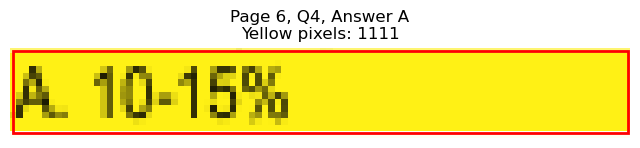

Page 6, Q4 - B: Detected box: x0=56.6, y0=304.0, x1=101.9, y1=316.6
Page 6, Q4, B: Yellow pixels: 96
Page 6, Q4, B: Total non-white pixels: 401
Page 6, Q4, B: Yellow percentage: 23.9%


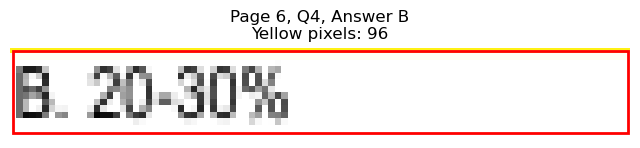

Page 6, Q4 - C: Detected box: x0=315.4, y0=291.4, x1=348.4, y1=304.0
Page 6, Q4, C: Yellow pixels: 0
Page 6, Q4, C: Total non-white pixels: 134
Page 6, Q4, C: Yellow percentage: 0.0%


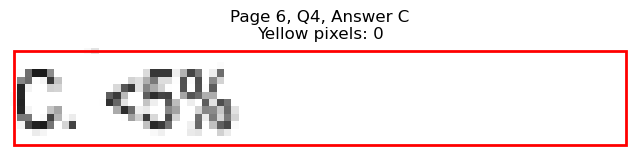

Page 6, Q4 - D: Detected box: x0=315.4, y0=304.0, x1=353.3, y1=316.6
Page 6, Q4, D: Yellow pixels: 0
Page 6, Q4, D: Total non-white pixels: 165
Page 6, Q4, D: Yellow percentage: 0.0%


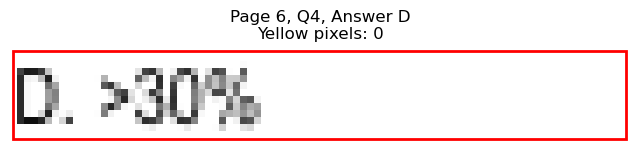


Page 6, Q4 - Selected Answer: A (based on yellow pixel count)
Page 6, Q5 - A: Detected box: x0=56.6, y0=341.9, x1=107.4, y1=354.6
Page 6, Q5, A: Yellow pixels: 1124
Page 6, Q5, A: Total non-white pixels: 1428
Page 6, Q5, A: Yellow percentage: 78.7%


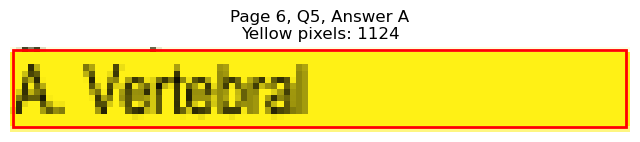

Page 6, Q5 - B: Detected box: x0=56.6, y0=354.5, x1=98.4, y1=367.2
Page 6, Q5, B: Yellow pixels: 93
Page 6, Q5, B: Total non-white pixels: 305
Page 6, Q5, B: Yellow percentage: 30.5%


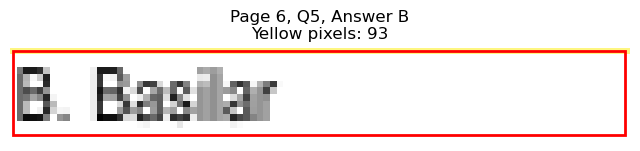

Page 6, Q5 - C: Detected box: x0=315.4, y0=341.9, x1=376.1, y1=354.6
Page 6, Q5, C: Yellow pixels: 0
Page 6, Q5, C: Total non-white pixels: 292
Page 6, Q5, C: Yellow percentage: 0.0%


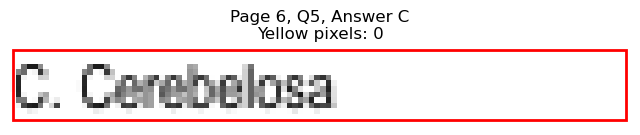

Page 6, Q5 - D: Detected box: x0=315.4, y0=354.5, x1=394.3, y1=367.2
Page 6, Q5, D: Yellow pixels: 0
Page 6, Q5, D: Total non-white pixels: 373
Page 6, Q5, D: Yellow percentage: 0.0%


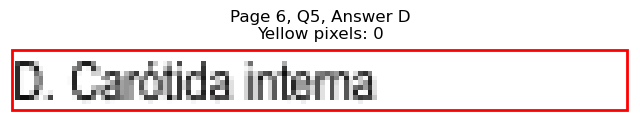


Page 6, Q5 - Selected Answer: A (based on yellow pixel count)
Page 6, Q6 - A: Detected box: x0=56.6, y0=430.2, x1=385.3, y1=442.9
Page 6, Q6, A: Yellow pixels: 3739
Page 6, Q6, A: Total non-white pixels: 4940
Page 6, Q6, A: Yellow percentage: 75.7%


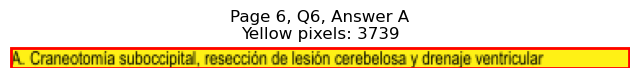

Page 6, Q6 - B: Detected box: x0=56.6, y0=442.8, x1=171.1, y1=455.5
Page 6, Q6, B: Yellow pixels: 165
Page 6, Q6, B: Total non-white pixels: 735
Page 6, Q6, B: Yellow percentage: 22.4%


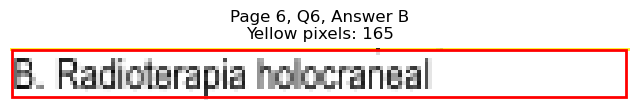

Page 6, Q6 - C: Detected box: x0=56.6, y0=455.5, x1=459.5, y1=468.1
Page 6, Q6, C: Yellow pixels: 0
Page 6, Q6, C: Total non-white pixels: 1968
Page 6, Q6, C: Yellow percentage: 0.0%


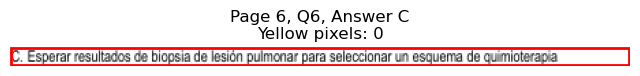

Page 6, Q6 - D: Detected box: x0=56.6, y0=468.1, x1=416.5, y1=480.7
Page 6, Q6, D: Yellow pixels: 0
Page 6, Q6, D: Total non-white pixels: 1783
Page 6, Q6, D: Yellow percentage: 0.0%


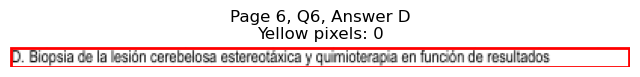


Page 6, Q6 - Selected Answer: A (based on yellow pixel count)
Page 6, Q7 - A: Detected box: x0=56.6, y0=518.6, x1=95.4, y1=531.2
Page 6, Q7, A: Yellow pixels: 0
Page 6, Q7, A: Total non-white pixels: 165
Page 6, Q7, A: Yellow percentage: 0.0%


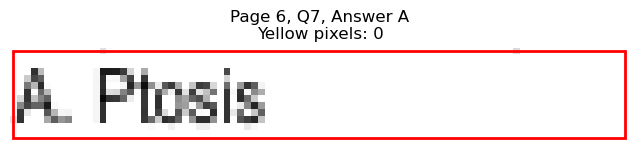

Page 6, Q7 - B: Detected box: x0=56.6, y0=531.2, x1=112.0, y1=543.8
Page 6, Q7, B: Yellow pixels: 0
Page 6, Q7, B: Total non-white pixels: 265
Page 6, Q7, B: Yellow percentage: 0.0%


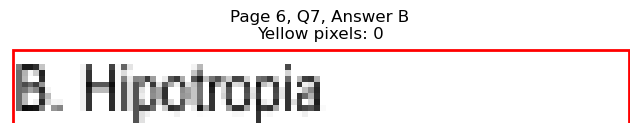

Page 6, Q7 - C: Detected box: x0=315.4, y0=518.6, x1=365.7, y1=531.2
Page 6, Q7, C: Yellow pixels: 1114
Page 6, Q7, C: Total non-white pixels: 1414
Page 6, Q7, C: Yellow percentage: 78.8%


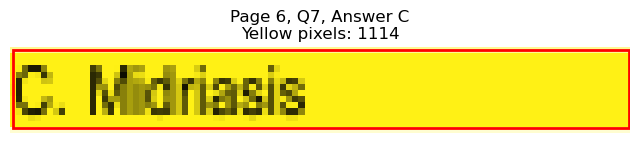

Page 6, Q7 - D: Detected box: x0=315.4, y0=531.2, x1=368.2, y1=543.8
Page 6, Q7, D: Yellow pixels: 0
Page 6, Q7, D: Total non-white pixels: 349
Page 6, Q7, D: Yellow percentage: 0.0%


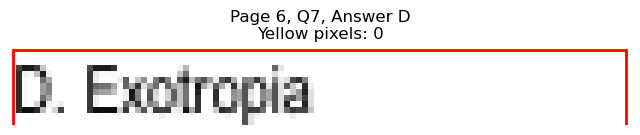


Page 6, Q7 - Selected Answer: C (based on yellow pixel count)
Page 6, Q8 - A: Detected box: x0=56.6, y0=569.1, x1=253.8, y1=581.7
Page 6, Q8, A: Yellow pixels: 0
Page 6, Q8, A: Total non-white pixels: 975
Page 6, Q8, A: Yellow percentage: 0.0%


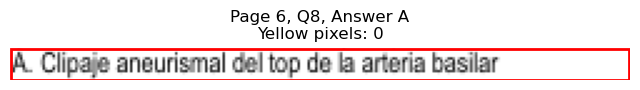

Page 6, Q8 - B: Detected box: x0=56.6, y0=581.7, x1=220.7, y1=594.3
Page 6, Q8, B: Yellow pixels: 215
Page 6, Q8, B: Total non-white pixels: 1040
Page 6, Q8, B: Yellow percentage: 20.7%


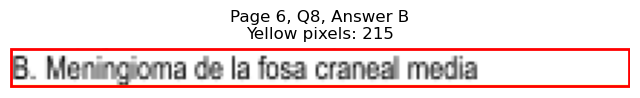

Page 6, Q8 - C: Detected box: x0=56.6, y0=594.3, x1=377.7, y1=606.9
Page 6, Q8, C: Yellow pixels: 3609
Page 6, Q8, C: Total non-white pixels: 4836
Page 6, Q8, C: Yellow percentage: 74.6%


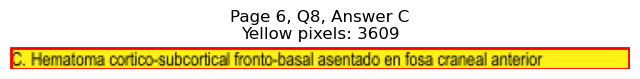

Page 6, Q8 - D: Detected box: x0=56.6, y0=606.9, x1=176.5, y1=619.5
Page 6, Q8, D: Yellow pixels: 171
Page 6, Q8, D: Total non-white pixels: 793
Page 6, Q8, D: Yellow percentage: 21.6%


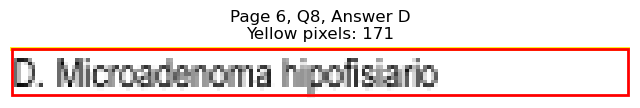


Page 6, Q8 - Selected Answer: C (based on yellow pixel count)
Page 6, Q9 - A: Detected box: x0=56.6, y0=644.8, x1=115.6, y1=657.5
Page 6, Q9, A: Yellow pixels: 110
Page 6, Q9, A: Total non-white pixels: 405
Page 6, Q9, A: Yellow percentage: 27.2%


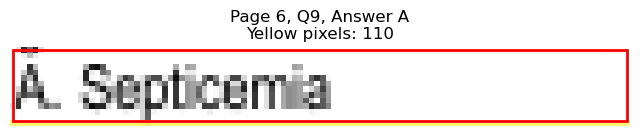

Page 6, Q9 - B: Detected box: x0=56.6, y0=657.4, x1=197.8, y1=670.1
Page 6, Q9, B: Yellow pixels: 1951
Page 6, Q9, B: Total non-white pixels: 2688
Page 6, Q9, B: Yellow percentage: 72.6%


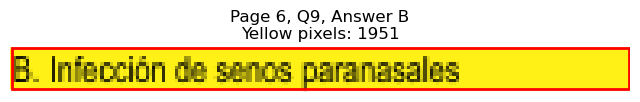

Page 6, Q9 - C: Detected box: x0=315.4, y0=644.8, x1=379.1, y1=657.5
Page 6, Q9, C: Yellow pixels: 0
Page 6, Q9, C: Total non-white pixels: 297
Page 6, Q9, C: Yellow percentage: 0.0%


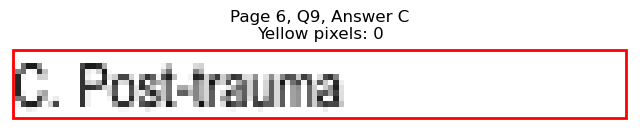

Page 6, Q9 - D: Detected box: x0=315.4, y0=657.4, x1=378.2, y1=670.1
Page 6, Q9, D: Yellow pixels: 0
Page 6, Q9, D: Total non-white pixels: 297
Page 6, Q9, D: Yellow percentage: 0.0%


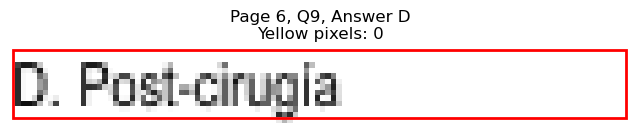


Page 6, Q9 - Selected Answer: B (based on yellow pixel count)
Page 6, Q10 - A: Detected box: x0=56.6, y0=695.4, x1=150.6, y1=708.0
Page 6, Q10, A: Yellow pixels: 0
Page 6, Q10, A: Total non-white pixels: 469
Page 6, Q10, A: Yellow percentage: 0.0%


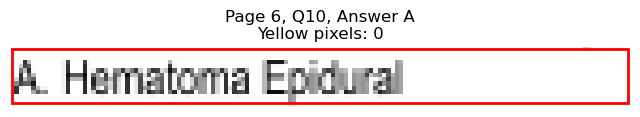

Page 6, Q10 - B: Detected box: x0=56.6, y0=708.0, x1=264.4, y1=720.6
Page 6, Q10, B: Yellow pixels: 259
Page 6, Q10, B: Total non-white pixels: 1276
Page 6, Q10, B: Yellow percentage: 20.3%


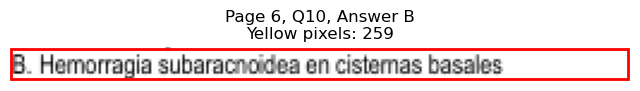

Page 6, Q10 - C: Detected box: x0=56.6, y0=720.6, x1=294.9, y1=733.2
Page 6, Q10, C: Yellow pixels: 2781
Page 6, Q10, C: Total non-white pixels: 4046
Page 6, Q10, C: Yellow percentage: 68.7%


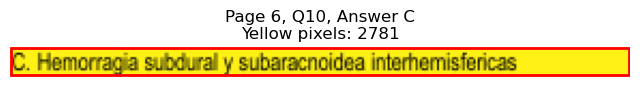

Page 6, Q10 - D: Detected box: x0=56.6, y0=733.2, x1=177.1, y1=745.8
Page 6, Q10, D: Yellow pixels: 0
Page 6, Q10, D: Total non-white pixels: 741
Page 6, Q10, D: Yellow percentage: 0.0%


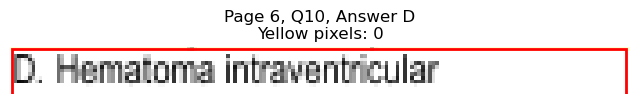


Page 6, Q10 - Selected Answer: C (based on yellow pixel count)

Page 7: Found 12 questions
Page 7, Q1 - A: Detected box: x0=56.6, y0=89.4, x1=91.8, y1=102.1
Page 7, Q1, A: Yellow pixels: 1006
Page 7, Q1, A: Total non-white pixels: 1204
Page 7, Q1, A: Yellow percentage: 83.6%


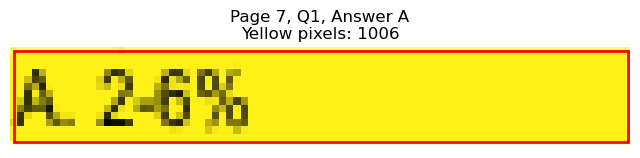

Page 7, Q1 - B: Detected box: x0=56.6, y0=102.0, x1=96.9, y1=114.7
Page 7, Q1, B: Yellow pixels: 0
Page 7, Q1, B: Total non-white pixels: 261
Page 7, Q1, B: Yellow percentage: 0.0%


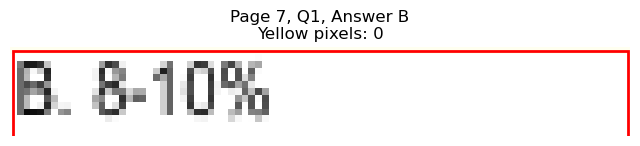

Page 7, Q1 - C: Detected box: x0=315.4, y0=89.4, x1=361.1, y1=102.1
Page 7, Q1, C: Yellow pixels: 0
Page 7, Q1, C: Total non-white pixels: 176
Page 7, Q1, C: Yellow percentage: 0.0%


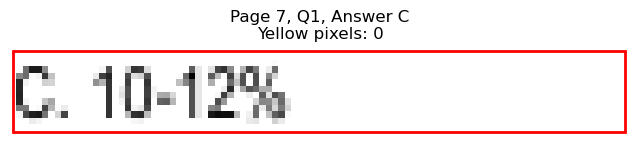

Page 7, Q1 - D: Detected box: x0=315.4, y0=102.0, x1=361.1, y1=114.7
Page 7, Q1, D: Yellow pixels: 0
Page 7, Q1, D: Total non-white pixels: 209
Page 7, Q1, D: Yellow percentage: 0.0%


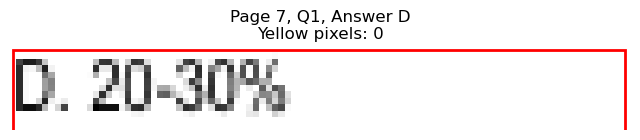


Page 7, Q1 - Selected Answer: A (based on yellow pixel count)
Page 7, Q2 - A: Detected box: x0=56.6, y0=139.9, x1=133.5, y1=152.6
Page 7, Q2, A: Yellow pixels: 0
Page 7, Q2, A: Total non-white pixels: 333
Page 7, Q2, A: Yellow percentage: 0.0%


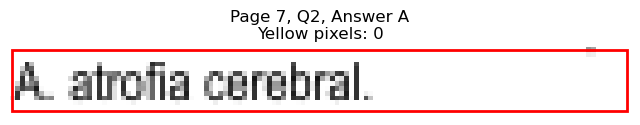

Page 7, Q2 - B: Detected box: x0=56.6, y0=152.5, x1=125.5, y1=165.2
Page 7, Q2, B: Yellow pixels: 0
Page 7, Q2, B: Total non-white pixels: 322
Page 7, Q2, B: Yellow percentage: 0.0%


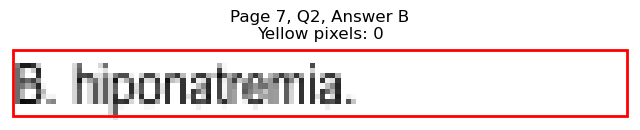

Page 7, Q2 - C: Detected box: x0=315.4, y0=139.9, x1=420.3, y1=152.6
Page 7, Q2, C: Yellow pixels: 156
Page 7, Q2, C: Total non-white pixels: 663
Page 7, Q2, C: Yellow percentage: 23.5%


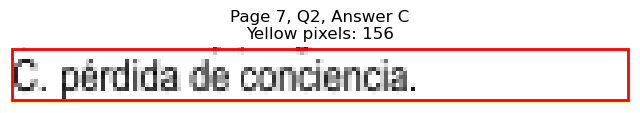

Page 7, Q2 - D: Detected box: x0=315.4, y0=152.5, x1=390.8, y1=165.2
Page 7, Q2, D: Yellow pixels: 1375
Page 7, Q2, D: Total non-white pixels: 1764
Page 7, Q2, D: Yellow percentage: 77.9%


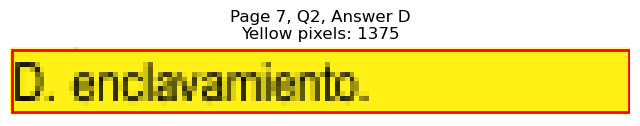


Page 7, Q2 - Selected Answer: D (based on yellow pixel count)
Page 7, Q3 - A: Detected box: x0=56.6, y0=190.3, x1=170.7, y1=203.0
Page 7, Q3, A: Yellow pixels: 0
Page 7, Q3, A: Total non-white pixels: 489
Page 7, Q3, A: Yellow percentage: 0.0%


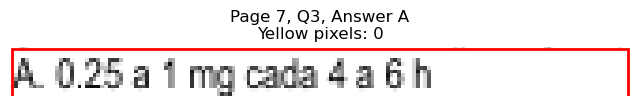

Page 7, Q3 - B: Detected box: x0=56.6, y0=202.9, x1=120.5, y1=215.6
Page 7, Q3, B: Yellow pixels: 0
Page 7, Q3, B: Total non-white pixels: 295
Page 7, Q3, B: Yellow percentage: 0.0%


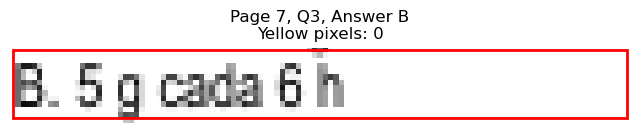

Page 7, Q3 - C: Detected box: x0=315.4, y0=190.3, x1=422.3, y1=203.0
Page 7, Q3, C: Yellow pixels: 1738
Page 7, Q3, C: Total non-white pixels: 2054
Page 7, Q3, C: Yellow percentage: 84.6%


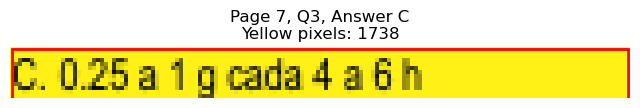

Page 7, Q3 - D: Detected box: x0=315.4, y0=202.9, x1=397.3, y1=215.6
Page 7, Q3, D: Yellow pixels: 129
Page 7, Q3, D: Total non-white pixels: 493
Page 7, Q3, D: Yellow percentage: 26.2%


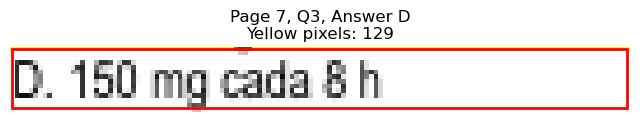


Page 7, Q3 - Selected Answer: C (based on yellow pixel count)
Page 7, Q4 - A: Detected box: x0=56.6, y0=240.8, x1=275.4, y1=253.5
Page 7, Q4, A: Yellow pixels: 0
Page 7, Q4, A: Total non-white pixels: 1045
Page 7, Q4, A: Yellow percentage: 0.0%


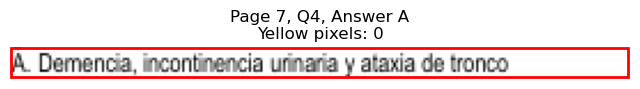

Page 7, Q4 - B: Detected box: x0=56.6, y0=253.4, x1=273.9, y1=266.1
Page 7, Q4, B: Yellow pixels: 0
Page 7, Q4, B: Total non-white pixels: 1054
Page 7, Q4, B: Yellow percentage: 0.0%


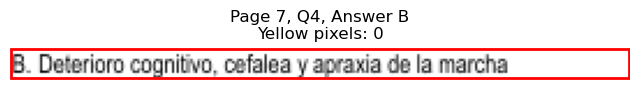

Page 7, Q4 - C: Detected box: x0=56.6, y0=266.0, x1=242.3, y1=278.7
Page 7, Q4, C: Yellow pixels: 0
Page 7, Q4, C: Total non-white pixels: 872
Page 7, Q4, C: Yellow percentage: 0.0%


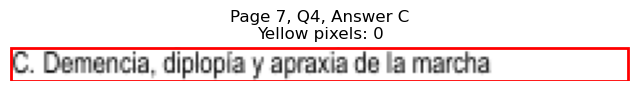

Page 7, Q4 - D: Detected box: x0=56.6, y0=278.8, x1=330.5, y1=291.4
Page 7, Q4, D: Yellow pixels: 3174
Page 7, Q4, D: Total non-white pixels: 4550
Page 7, Q4, D: Yellow percentage: 69.8%


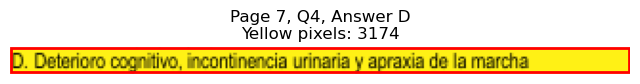


Page 7, Q4 - Selected Answer: D (based on yellow pixel count)
Page 7, Q5 - A: Detected box: x0=56.6, y0=316.6, x1=142.1, y1=329.2
Page 7, Q5, A: Yellow pixels: 0
Page 7, Q5, A: Total non-white pixels: 377
Page 7, Q5, A: Yellow percentage: 0.0%


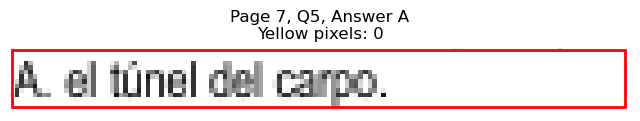

Page 7, Q5 - B: Detected box: x0=56.6, y0=329.2, x1=189.7, y1=341.8
Page 7, Q5, B: Yellow pixels: 0
Page 7, Q5, B: Total non-white pixels: 633
Page 7, Q5, B: Yellow percentage: 0.0%


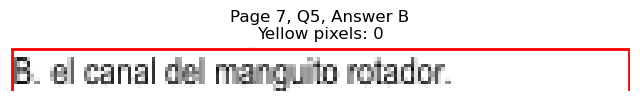

Page 7, Q5 - C: Detected box: x0=315.4, y0=316.6, x1=494.6, y1=329.2
Page 7, Q5, C: Yellow pixels: 2051
Page 7, Q5, C: Total non-white pixels: 3164
Page 7, Q5, C: Yellow percentage: 64.8%


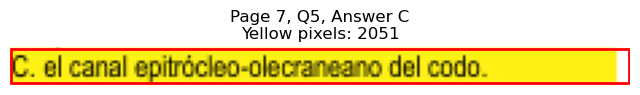

Page 7, Q5 - D: Detected box: x0=315.4, y0=329.2, x1=396.3, y1=341.8
Page 7, Q5, D: Yellow pixels: 0
Page 7, Q5, D: Total non-white pixels: 520
Page 7, Q5, D: Yellow percentage: 0.0%


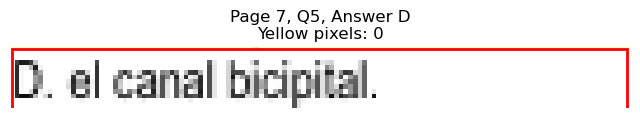


Page 7, Q5 - Selected Answer: C (based on yellow pixel count)
Page 7, Q6 - A: Detected box: x0=56.6, y0=367.1, x1=157.1, y1=379.8
Page 7, Q6, A: Yellow pixels: 0
Page 7, Q6, A: Total non-white pixels: 619
Page 7, Q6, A: Yellow percentage: 0.0%


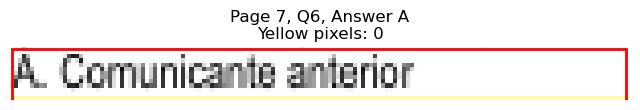

Page 7, Q6 - B: Detected box: x0=56.6, y0=379.7, x1=161.5, y1=392.4
Page 7, Q6, B: Yellow pixels: 1464
Page 7, Q6, B: Total non-white pixels: 2184
Page 7, Q6, B: Yellow percentage: 67.0%


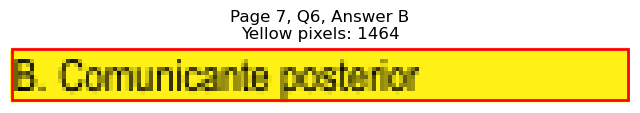

Page 7, Q6 - C: Detected box: x0=315.4, y0=367.1, x1=357.7, y1=379.8
Page 7, Q6, C: Yellow pixels: 0
Page 7, Q6, C: Total non-white pixels: 201
Page 7, Q6, C: Yellow percentage: 0.0%


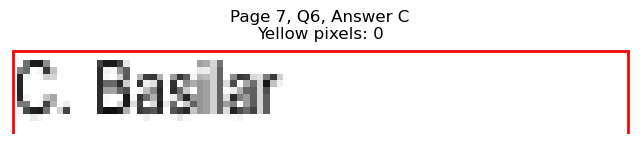

Page 7, Q6 - D: Detected box: x0=315.4, y0=379.7, x1=366.7, y1=392.4
Page 7, Q6, D: Yellow pixels: 0
Page 7, Q6, D: Total non-white pixels: 243
Page 7, Q6, D: Yellow percentage: 0.0%


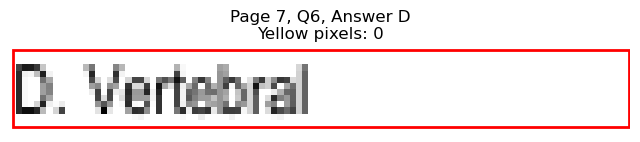


Page 7, Q6 - Selected Answer: B (based on yellow pixel count)
Page 7, Q7 - A: Detected box: x0=56.6, y0=417.6, x1=133.5, y1=430.3
Page 7, Q7, A: Yellow pixels: 0
Page 7, Q7, A: Total non-white pixels: 349
Page 7, Q7, A: Yellow percentage: 0.0%


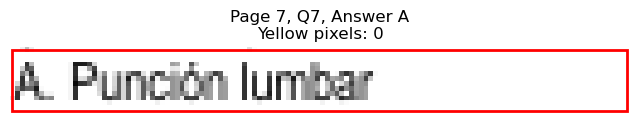

Page 7, Q7 - B: Detected box: x0=56.6, y0=430.2, x1=169.1, y1=442.9
Page 7, Q7, B: Yellow pixels: 0
Page 7, Q7, B: Total non-white pixels: 559
Page 7, Q7, B: Yellow percentage: 0.0%


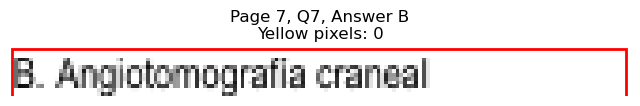

Page 7, Q7 - C: Detected box: x0=315.4, y0=417.6, x1=480.6, y1=430.3
Page 7, Q7, C: Yellow pixels: 216
Page 7, Q7, C: Total non-white pixels: 1055
Page 7, Q7, C: Yellow percentage: 20.5%


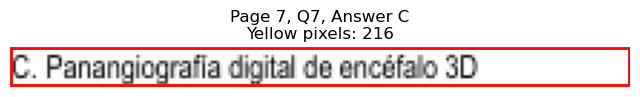

Page 7, Q7 - D: Detected box: x0=315.4, y0=430.2, x1=461.9, y1=442.9
Page 7, Q7, D: Yellow pixels: 2044
Page 7, Q7, D: Total non-white pixels: 2561
Page 7, Q7, D: Yellow percentage: 79.8%


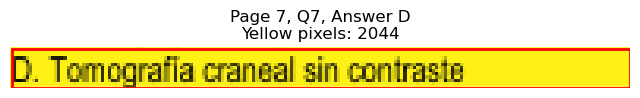


Page 7, Q7 - Selected Answer: D (based on yellow pixel count)
Page 7, Q8 - A: Detected box: x0=56.6, y0=480.8, x1=201.8, y1=493.4
Page 7, Q8, A: Yellow pixels: 196
Page 7, Q8, A: Total non-white pixels: 819
Page 7, Q8, A: Yellow percentage: 23.9%


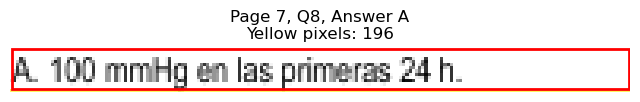

Page 7, Q8 - B: Detected box: x0=56.6, y0=493.4, x1=201.8, y1=506.0
Page 7, Q8, B: Yellow pixels: 2043
Page 7, Q8, B: Total non-white pixels: 2552
Page 7, Q8, B: Yellow percentage: 80.1%


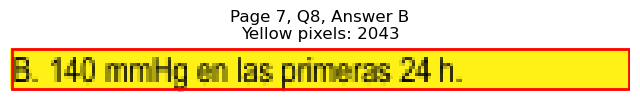

Page 7, Q8 - C: Detected box: x0=315.4, y0=480.8, x1=460.0, y1=493.4
Page 7, Q8, C: Yellow pixels: 0
Page 7, Q8, C: Total non-white pixels: 664
Page 7, Q8, C: Yellow percentage: 0.0%


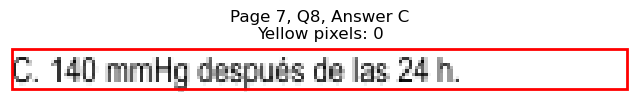

Page 7, Q8 - D: Detected box: x0=315.4, y0=493.4, x1=460.0, y1=506.0
Page 7, Q8, D: Yellow pixels: 0
Page 7, Q8, D: Total non-white pixels: 664
Page 7, Q8, D: Yellow percentage: 0.0%


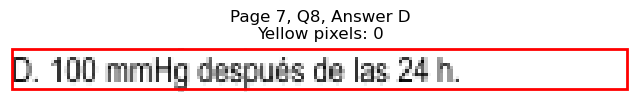


Page 7, Q8 - Selected Answer: B (based on yellow pixel count)
Page 7, Q9 - A: Detected box: x0=56.6, y0=543.8, x1=130.5, y1=556.4
Page 7, Q9, A: Yellow pixels: 0
Page 7, Q9, A: Total non-white pixels: 362
Page 7, Q9, A: Yellow percentage: 0.0%


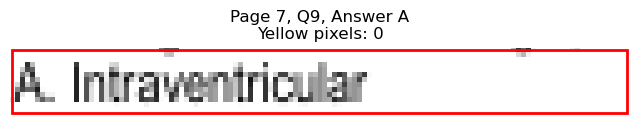

Page 7, Q9 - B: Detected box: x0=56.6, y0=556.5, x1=103.9, y1=569.1
Page 7, Q9, B: Yellow pixels: 1102
Page 7, Q9, B: Total non-white pixels: 1372
Page 7, Q9, B: Yellow percentage: 80.3%


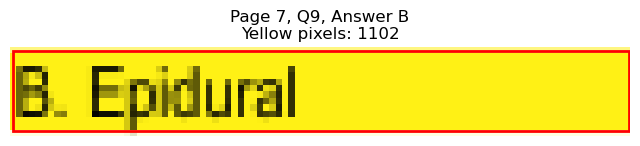

Page 7, Q9 - C: Detected box: x0=315.4, y0=543.8, x1=366.2, y1=556.4
Page 7, Q9, C: Yellow pixels: 0
Page 7, Q9, C: Total non-white pixels: 225
Page 7, Q9, C: Yellow percentage: 0.0%


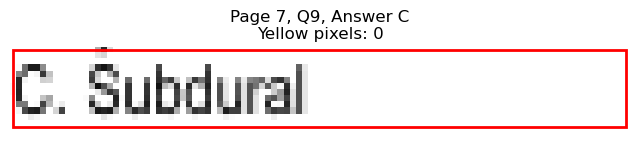

Page 7, Q9 - D: Detected box: x0=315.4, y0=556.5, x1=390.8, y1=569.1
Page 7, Q9, D: Yellow pixels: 0
Page 7, Q9, D: Total non-white pixels: 354
Page 7, Q9, D: Yellow percentage: 0.0%


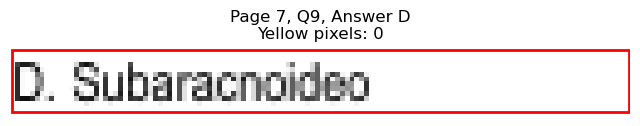


Page 7, Q9 - Selected Answer: B (based on yellow pixel count)
Page 7, Q10 - A: Detected box: x0=56.6, y0=606.9, x1=81.9, y1=619.5
Page 7, Q10, A: Yellow pixels: 0
Page 7, Q10, A: Total non-white pixels: 90
Page 7, Q10, A: Yellow percentage: 0.0%


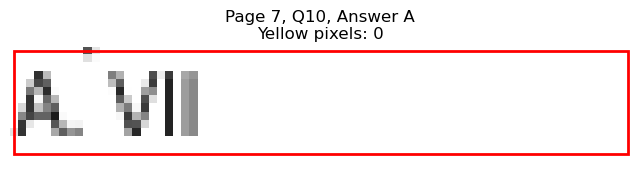

Page 7, Q10 - B: Detected box: x0=56.6, y0=619.6, x1=84.4, y1=632.3
Page 7, Q10, B: Yellow pixels: 857
Page 7, Q10, B: Total non-white pixels: 1106
Page 7, Q10, B: Yellow percentage: 77.5%


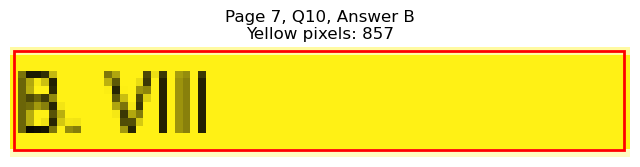

Page 7, Q10 - C: Detected box: x0=315.4, y0=606.9, x1=338.6, y1=619.5
Page 7, Q10, C: Yellow pixels: 0
Page 7, Q10, C: Total non-white pixels: 81
Page 7, Q10, C: Yellow percentage: 0.0%


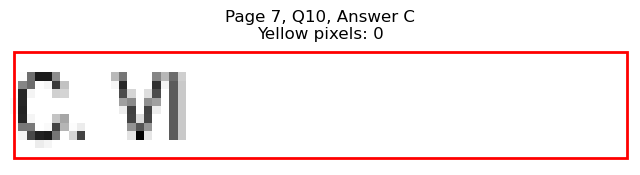

Page 7, Q10 - D: Detected box: x0=315.4, y0=619.6, x1=338.6, y1=632.3
Page 7, Q10, D: Yellow pixels: 0
Page 7, Q10, D: Total non-white pixels: 82
Page 7, Q10, D: Yellow percentage: 0.0%


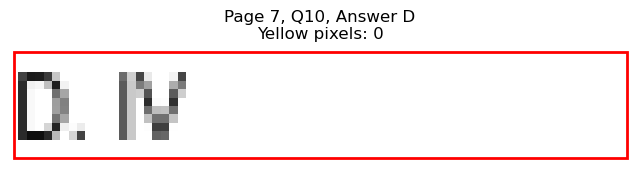


Page 7, Q10 - Selected Answer: B (based on yellow pixel count)
Page 7, Q11 - A: Detected box: x0=56.6, y0=657.4, x1=115.0, y1=670.1
Page 7, Q11, A: Yellow pixels: 0
Page 7, Q11, A: Total non-white pixels: 255
Page 7, Q11, A: Yellow percentage: 0.0%


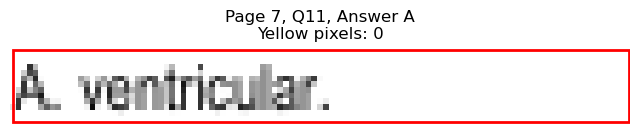

Page 7, Q11 - B: Detected box: x0=56.6, y0=670.0, x1=107.9, y1=682.7
Page 7, Q11, B: Yellow pixels: 0
Page 7, Q11, B: Total non-white pixels: 245
Page 7, Q11, B: Yellow percentage: 0.0%


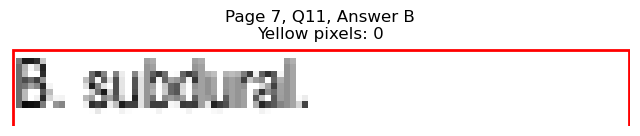

Page 7, Q11 - C: Detected box: x0=315.4, y0=657.4, x1=364.6, y1=670.1
Page 7, Q11, C: Yellow pixels: 100
Page 7, Q11, C: Total non-white pixels: 317
Page 7, Q11, C: Yellow percentage: 31.5%


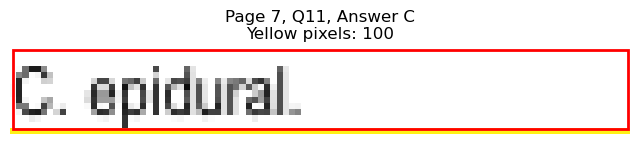

Page 7, Q11 - D: Detected box: x0=315.4, y0=670.0, x1=382.3, y1=682.7
Page 7, Q11, D: Yellow pixels: 1320
Page 7, Q11, D: Total non-white pixels: 1534
Page 7, Q11, D: Yellow percentage: 86.0%


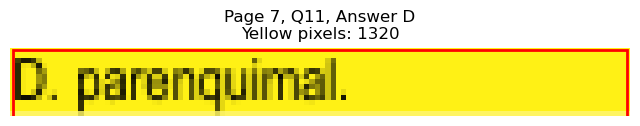


Page 7, Q11 - Selected Answer: D (based on yellow pixel count)
Page 7, Q12 - A: Detected box: x0=56.6, y0=708.0, x1=88.8, y1=720.6
Page 7, Q12, A: Yellow pixels: 975
Page 7, Q12, A: Total non-white pixels: 1162
Page 7, Q12, A: Yellow percentage: 83.9%


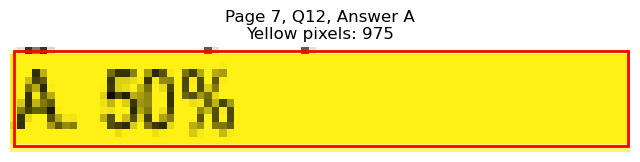

Page 7, Q12 - B: Detected box: x0=56.6, y0=720.6, x1=88.8, y1=733.2
Page 7, Q12, B: Yellow pixels: 83
Page 7, Q12, B: Total non-white pixels: 231
Page 7, Q12, B: Yellow percentage: 35.9%


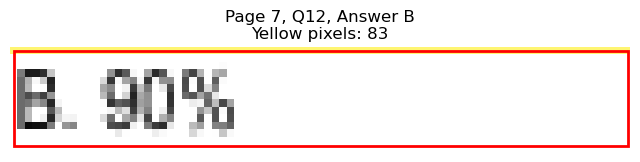

Page 7, Q12 - C: Detected box: x0=315.4, y0=708.0, x1=348.1, y1=720.6
Page 7, Q12, C: Yellow pixels: 0
Page 7, Q12, C: Total non-white pixels: 134
Page 7, Q12, C: Yellow percentage: 0.0%


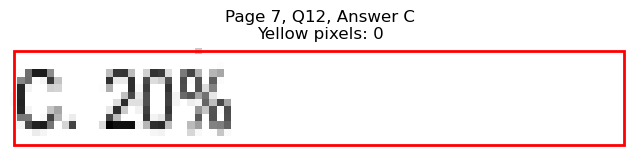

Page 7, Q12 - D: Detected box: x0=315.4, y0=720.6, x1=348.1, y1=733.2
Page 7, Q12, D: Yellow pixels: 0
Page 7, Q12, D: Total non-white pixels: 123
Page 7, Q12, D: Yellow percentage: 0.0%


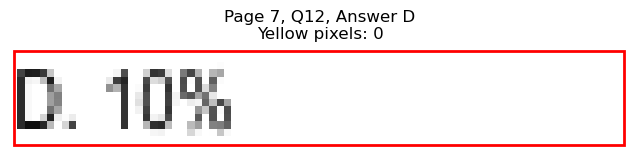


Page 7, Q12 - Selected Answer: A (based on yellow pixel count)

Page 8: Found 11 questions
Page 8, Q1 - A: Detected box: x0=56.6, y0=89.4, x1=127.5, y1=102.1
Page 8, Q1, A: Yellow pixels: 0
Page 8, Q1, A: Total non-white pixels: 329
Page 8, Q1, A: Yellow percentage: 0.0%


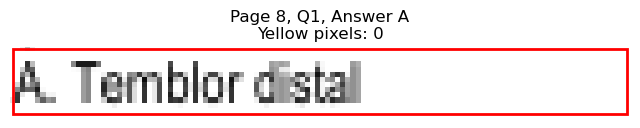

Page 8, Q1 - B: Detected box: x0=56.6, y0=102.0, x1=108.4, y1=114.7
Page 8, Q1, B: Yellow pixels: 0
Page 8, Q1, B: Total non-white pixels: 254
Page 8, Q1, B: Yellow percentage: 0.0%


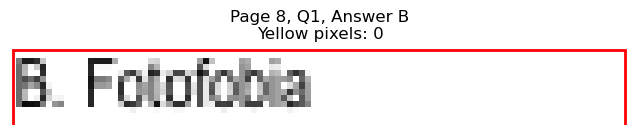

Page 8, Q1 - C: Detected box: x0=315.4, y0=89.4, x1=377.7, y1=102.1
Page 8, Q1, C: Yellow pixels: 1256
Page 8, Q1, C: Total non-white pixels: 1582
Page 8, Q1, C: Yellow percentage: 79.4%


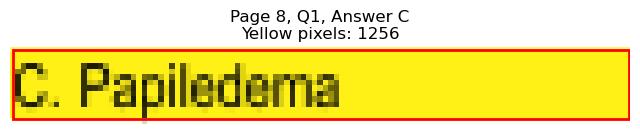

Page 8, Q1 - D: Detected box: x0=315.4, y0=102.0, x1=358.6, y1=114.7
Page 8, Q1, D: Yellow pixels: 0
Page 8, Q1, D: Total non-white pixels: 303
Page 8, Q1, D: Yellow percentage: 0.0%


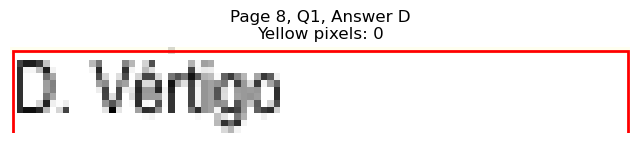


Page 8, Q1 - Selected Answer: C (based on yellow pixel count)
Page 8, Q2 - A: Detected box: x0=56.6, y0=152.5, x1=293.4, y1=165.2
Page 8, Q2, A: Yellow pixels: 0
Page 8, Q2, A: Total non-white pixels: 1148
Page 8, Q2, A: Yellow percentage: 0.0%


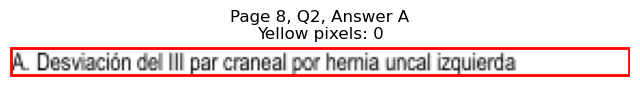

Page 8, Q2 - B: Detected box: x0=56.6, y0=165.1, x1=261.9, y1=177.8
Page 8, Q2, B: Yellow pixels: 0
Page 8, Q2, B: Total non-white pixels: 1246
Page 8, Q2, B: Yellow percentage: 0.0%


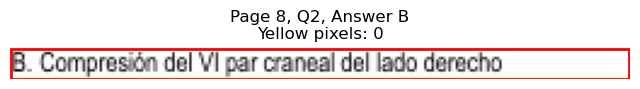

Page 8, Q2 - C: Detected box: x0=56.6, y0=177.7, x1=311.1, y1=190.4
Page 8, Q2, C: Yellow pixels: 2746
Page 8, Q2, C: Total non-white pixels: 4284
Page 8, Q2, C: Yellow percentage: 64.1%


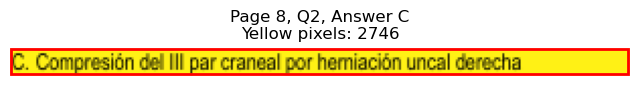

Page 8, Q2 - D: Detected box: x0=56.6, y0=190.3, x1=194.2, y1=203.0
Page 8, Q2, D: Yellow pixels: 3
Page 8, Q2, D: Total non-white pixels: 843
Page 8, Q2, D: Yellow percentage: 0.4%


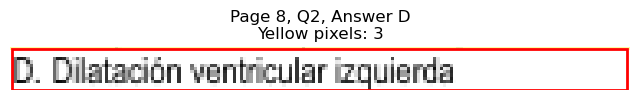


Page 8, Q2 - Selected Answer: C (based on yellow pixel count)
Page 8, Q3 - A: Detected box: x0=56.6, y0=253.4, x1=179.7, y1=266.1
Page 8, Q3, A: Yellow pixels: 1812
Page 8, Q3, A: Total non-white pixels: 2436
Page 8, Q3, A: Yellow percentage: 74.4%


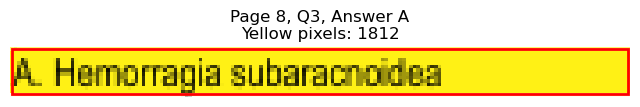

Page 8, Q3 - B: Detected box: x0=56.6, y0=266.0, x1=187.6, y1=278.7
Page 8, Q3, B: Yellow pixels: 0
Page 8, Q3, B: Total non-white pixels: 807
Page 8, Q3, B: Yellow percentage: 0.0%


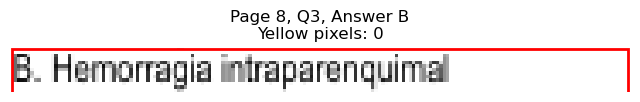

Page 8, Q3 - C: Detected box: x0=315.4, y0=253.4, x1=447.4, y1=266.1
Page 8, Q3, C: Yellow pixels: 0
Page 8, Q3, C: Total non-white pixels: 692
Page 8, Q3, C: Yellow percentage: 0.0%


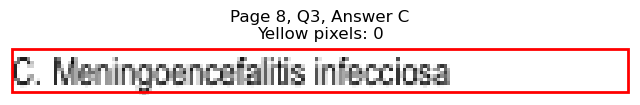

Page 8, Q3 - D: Detected box: x0=315.4, y0=266.0, x1=463.9, y1=278.7
Page 8, Q3, D: Yellow pixels: 0
Page 8, Q3, D: Total non-white pixels: 762
Page 8, Q3, D: Yellow percentage: 0.0%


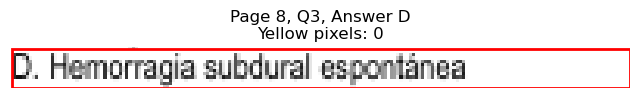


Page 8, Q3 - Selected Answer: A (based on yellow pixel count)
Page 8, Q4 - A: Detected box: x0=56.6, y0=304.0, x1=75.9, y1=316.6
Page 8, Q4, A: Yellow pixels: 0
Page 8, Q4, A: Total non-white pixels: 139
Page 8, Q4, A: Yellow percentage: 0.0%


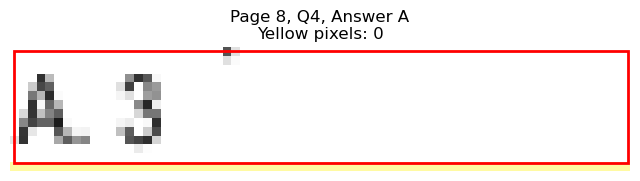

Page 8, Q4 - B: Detected box: x0=56.6, y0=316.6, x1=75.9, y1=329.2
Page 8, Q4, B: Yellow pixels: 786
Page 8, Q4, B: Total non-white pixels: 980
Page 8, Q4, B: Yellow percentage: 80.2%


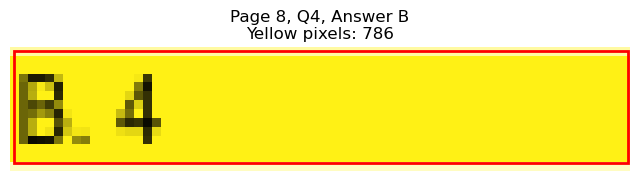

Page 8, Q4 - C: Detected box: x0=315.4, y0=304.0, x1=335.1, y1=316.6
Page 8, Q4, C: Yellow pixels: 0
Page 8, Q4, C: Total non-white pixels: 69
Page 8, Q4, C: Yellow percentage: 0.0%


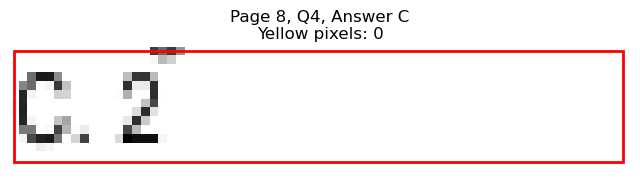

Page 8, Q4 - D: Detected box: x0=315.4, y0=316.6, x1=335.1, y1=329.2
Page 8, Q4, D: Yellow pixels: 0
Page 8, Q4, D: Total non-white pixels: 53
Page 8, Q4, D: Yellow percentage: 0.0%


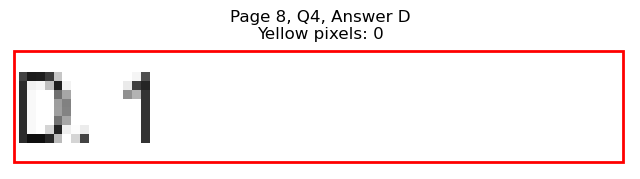


Page 8, Q4 - Selected Answer: B (based on yellow pixel count)
Page 8, Q5 - A: Detected box: x0=56.6, y0=367.1, x1=209.2, y1=379.8
Page 8, Q5, A: Yellow pixels: 0
Page 8, Q5, A: Total non-white pixels: 783
Page 8, Q5, A: Yellow percentage: 0.0%


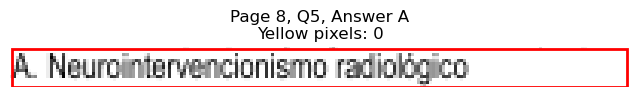

Page 8, Q5 - B: Detected box: x0=56.6, y0=379.7, x1=156.6, y1=392.4
Page 8, Q5, B: Yellow pixels: 0
Page 8, Q5, B: Total non-white pixels: 501
Page 8, Q5, B: Yellow percentage: 0.0%


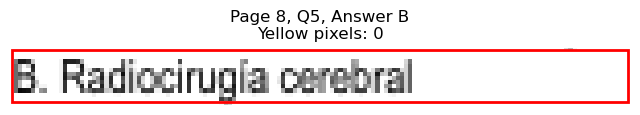

Page 8, Q5 - C: Detected box: x0=315.4, y0=367.1, x1=400.7, y1=379.8
Page 8, Q5, C: Yellow pixels: 2
Page 8, Q5, C: Total non-white pixels: 555
Page 8, Q5, C: Yellow percentage: 0.4%


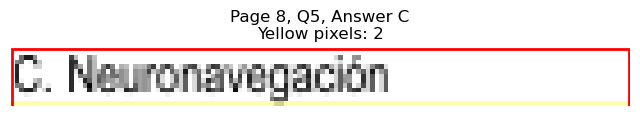

Page 8, Q5 - D: Detected box: x0=315.4, y0=379.7, x1=476.5, y1=392.4
Page 8, Q5, D: Yellow pixels: 1927
Page 8, Q5, D: Total non-white pixels: 2968
Page 8, Q5, D: Yellow percentage: 64.9%


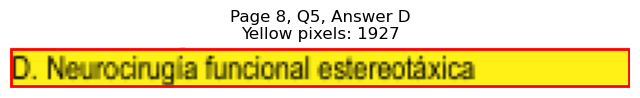


Page 8, Q5 - Selected Answer: D (based on yellow pixel count)
Page 8, Q6 - A: Detected box: x0=56.6, y0=417.6, x1=99.9, y1=430.3
Page 8, Q6, A: Yellow pixels: 0
Page 8, Q6, A: Total non-white pixels: 215
Page 8, Q6, A: Yellow percentage: 0.0%


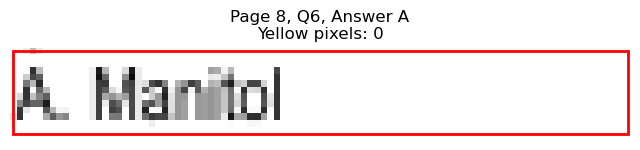

Page 8, Q6 - B: Detected box: x0=56.6, y0=430.2, x1=118.5, y1=442.9
Page 8, Q6, B: Yellow pixels: 0
Page 8, Q6, B: Total non-white pixels: 293
Page 8, Q6, B: Yellow percentage: 0.0%


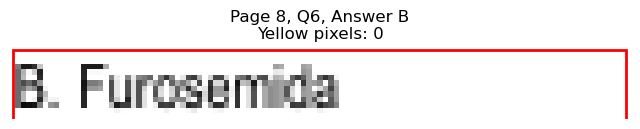

Page 8, Q6 - C: Detected box: x0=315.4, y0=417.6, x1=350.1, y1=430.3
Page 8, Q6, C: Yellow pixels: 86
Page 8, Q6, C: Total non-white pixels: 222
Page 8, Q6, C: Yellow percentage: 38.7%


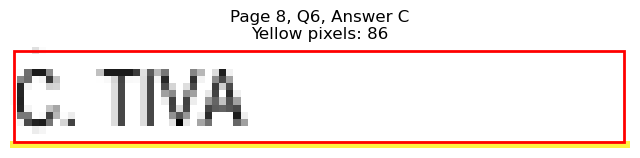

Page 8, Q6 - D: Detected box: x0=315.4, y0=430.2, x1=361.6, y1=442.9
Page 8, Q6, D: Yellow pixels: 1078
Page 8, Q6, D: Total non-white pixels: 1261
Page 8, Q6, D: Yellow percentage: 85.5%


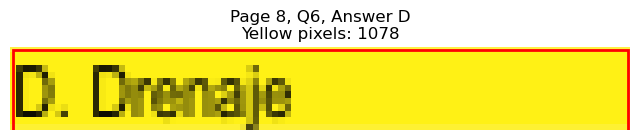


Page 8, Q6 - Selected Answer: D (based on yellow pixel count)
Page 8, Q7 - A: Detected box: x0=56.6, y0=468.1, x1=206.2, y1=480.7
Page 8, Q7, A: Yellow pixels: 2039
Page 8, Q7, A: Total non-white pixels: 2613
Page 8, Q7, A: Yellow percentage: 78.0%


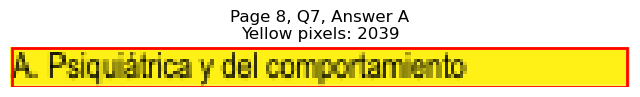

Page 8, Q7 - B: Detected box: x0=56.6, y0=480.8, x1=177.1, y1=493.4
Page 8, Q7, B: Yellow pixels: 171
Page 8, Q7, B: Total non-white pixels: 791
Page 8, Q7, B: Yellow percentage: 21.6%


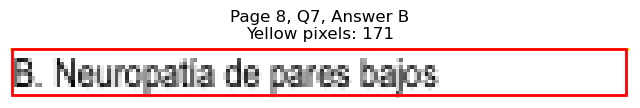

Page 8, Q7 - C: Detected box: x0=315.4, y0=468.1, x1=380.7, y1=480.7
Page 8, Q7, C: Yellow pixels: 0
Page 8, Q7, C: Total non-white pixels: 310
Page 8, Q7, C: Yellow percentage: 0.0%


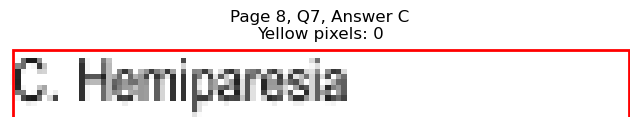

Page 8, Q7 - D: Detected box: x0=315.4, y0=480.8, x1=377.7, y1=493.4
Page 8, Q7, D: Yellow pixels: 0
Page 8, Q7, D: Total non-white pixels: 323
Page 8, Q7, D: Yellow percentage: 0.0%


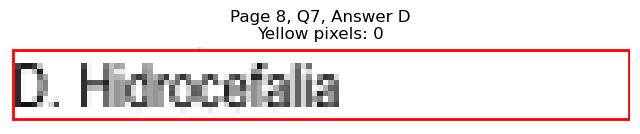


Page 8, Q7 - Selected Answer: A (based on yellow pixel count)
Page 8, Q8 - A: Detected box: x0=56.6, y0=531.2, x1=121.5, y1=543.8
Page 8, Q8, A: Yellow pixels: 1250
Page 8, Q8, A: Total non-white pixels: 1508
Page 8, Q8, A: Yellow percentage: 82.9%


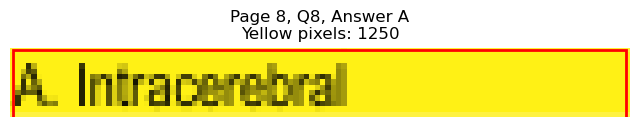

Page 8, Q8 - B: Detected box: x0=56.6, y0=543.8, x1=113.9, y1=556.4
Page 8, Q8, B: Yellow pixels: 108
Page 8, Q8, B: Total non-white pixels: 358
Page 8, Q8, B: Yellow percentage: 30.2%


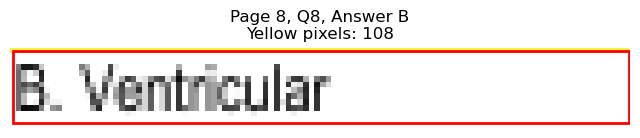

Page 8, Q8 - C: Detected box: x0=315.4, y0=531.2, x1=366.2, y1=543.8
Page 8, Q8, C: Yellow pixels: 0
Page 8, Q8, C: Total non-white pixels: 223
Page 8, Q8, C: Yellow percentage: 0.0%


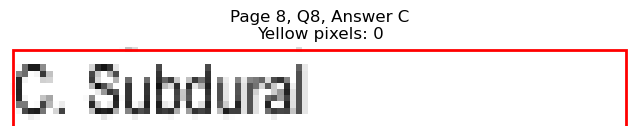

Page 8, Q8 - D: Detected box: x0=315.4, y0=543.8, x1=363.2, y1=556.4
Page 8, Q8, D: Yellow pixels: 0
Page 8, Q8, D: Total non-white pixels: 206
Page 8, Q8, D: Yellow percentage: 0.0%


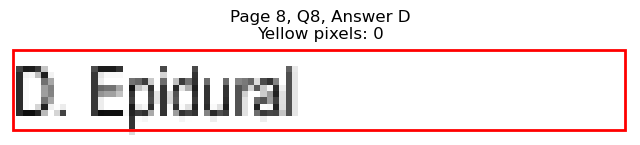


Page 8, Q8 - Selected Answer: A (based on yellow pixel count)
Page 8, Q9 - A: Detected box: x0=56.6, y0=581.7, x1=235.4, y1=594.3
Page 8, Q9, A: Yellow pixels: 230
Page 8, Q9, A: Total non-white pixels: 1101
Page 8, Q9, A: Yellow percentage: 20.9%


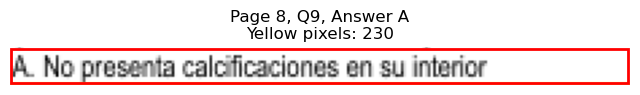

Page 8, Q9 - B: Detected box: x0=56.6, y0=594.3, x1=288.0, y1=606.9
Page 8, Q9, B: Yellow pixels: 2819
Page 8, Q9, B: Total non-white pixels: 3679
Page 8, Q9, B: Yellow percentage: 76.6%


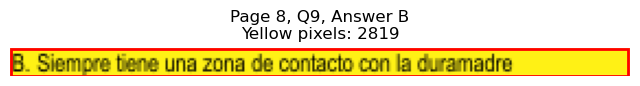

Page 8, Q9 - C: Detected box: x0=56.6, y0=606.9, x1=161.5, y1=619.5
Page 8, Q9, C: Yellow pixels: 154
Page 8, Q9, C: Total non-white pixels: 663
Page 8, Q9, C: Yellow percentage: 23.2%


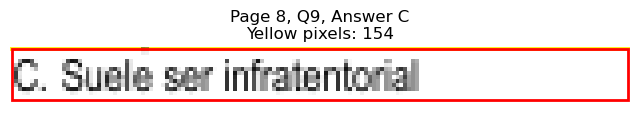

Page 8, Q9 - D: Detected box: x0=56.6, y0=619.6, x1=154.6, y1=632.3
Page 8, Q9, D: Yellow pixels: 0
Page 8, Q9, D: Total non-white pixels: 444
Page 8, Q9, D: Yellow percentage: 0.0%


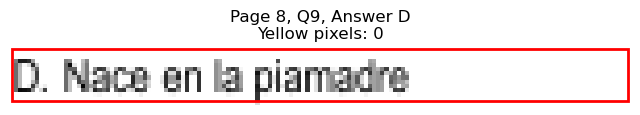


Page 8, Q9 - Selected Answer: B (based on yellow pixel count)
Page 8, Q10 - A: Detected box: x0=56.6, y0=657.4, x1=168.6, y1=670.1
Page 8, Q10, A: Yellow pixels: 0
Page 8, Q10, A: Total non-white pixels: 565
Page 8, Q10, A: Yellow percentage: 0.0%


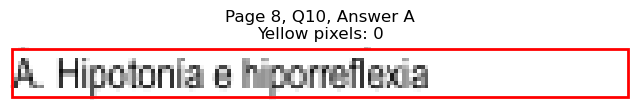

Page 8, Q10 - B: Detected box: x0=56.6, y0=670.0, x1=173.1, y1=682.7
Page 8, Q10, B: Yellow pixels: 0
Page 8, Q10, B: Total non-white pixels: 578
Page 8, Q10, B: Yellow percentage: 0.0%


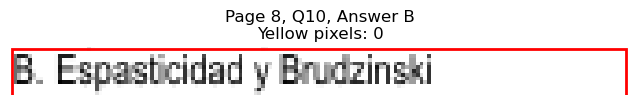

Page 8, Q10 - C: Detected box: x0=315.4, y0=657.4, x1=448.4, y1=670.1
Page 8, Q10, C: Yellow pixels: 184
Page 8, Q10, C: Total non-white pixels: 822
Page 8, Q10, C: Yellow percentage: 22.4%


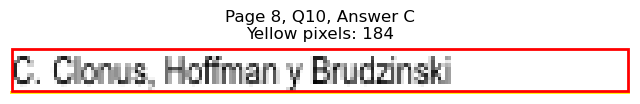

Page 8, Q10 - D: Detected box: x0=315.4, y0=670.0, x1=479.0, y1=682.7
Page 8, Q10, D: Yellow pixels: 2143
Page 8, Q10, D: Total non-white pixels: 2795
Page 8, Q10, D: Yellow percentage: 76.7%


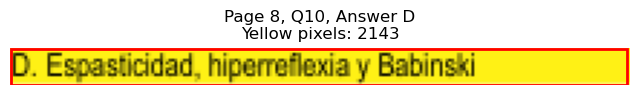


Page 8, Q10 - Selected Answer: D (based on yellow pixel count)
Page 8, Q11 - A: Detected box: x0=56.6, y0=733.2, x1=192.6, y1=745.8
Page 8, Q11, A: Yellow pixels: 0
Page 8, Q11, A: Total non-white pixels: 849
Page 8, Q11, A: Yellow percentage: 0.0%


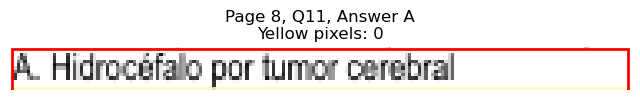

Page 8, Q11 - B: Detected box: x0=56.6, y0=745.8, x1=259.4, y1=758.4
Page 8, Q11, B: Yellow pixels: 2130
Page 8, Q11, B: Total non-white pixels: 3164
Page 8, Q11, B: Yellow percentage: 67.3%


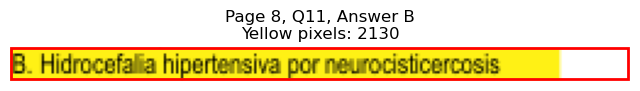

Page 8, Q11 - C: Detected box: x0=315.4, y0=733.2, x1=491.0, y1=745.8
Page 8, Q11, C: Yellow pixels: 0
Page 8, Q11, C: Total non-white pixels: 836
Page 8, Q11, C: Yellow percentage: 0.0%


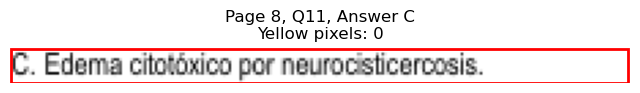

Page 8, Q11 - D: Detected box: x0=315.4, y0=745.8, x1=480.5, y1=758.4
Page 8, Q11, D: Yellow pixels: 0
Page 8, Q11, D: Total non-white pixels: 805
Page 8, Q11, D: Yellow percentage: 0.0%


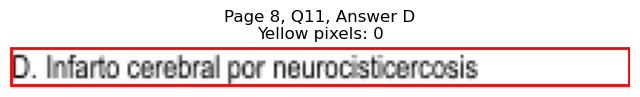


Page 8, Q11 - Selected Answer: B (based on yellow pixel count)

Page 9: Found 11 questions
Page 9, Q1 - A: Detected box: x0=56.6, y0=89.4, x1=248.8, y1=102.1
Page 9, Q1, A: Yellow pixels: 2189
Page 9, Q1, A: Total non-white pixels: 3164
Page 9, Q1, A: Yellow percentage: 69.2%


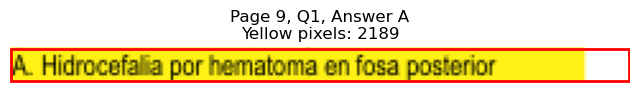

Page 9, Q1 - B: Detected box: x0=56.6, y0=102.0, x1=215.7, y1=114.7
Page 9, Q1, B: Yellow pixels: 0
Page 9, Q1, B: Total non-white pixels: 1001
Page 9, Q1, B: Yellow percentage: 0.0%


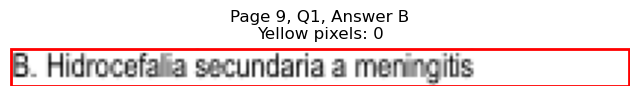

Page 9, Q1 - C: Detected box: x0=315.4, y0=89.4, x1=443.8, y1=102.1
Page 9, Q1, C: Yellow pixels: 0
Page 9, Q1, C: Total non-white pixels: 639
Page 9, Q1, C: Yellow percentage: 0.0%


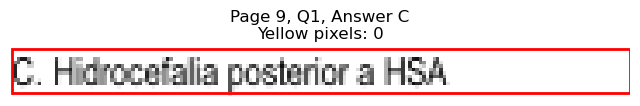

Page 9, Q1 - D: Detected box: x0=315.4, y0=102.0, x1=414.3, y1=114.7
Page 9, Q1, D: Yellow pixels: 0
Page 9, Q1, D: Total non-white pixels: 472
Page 9, Q1, D: Yellow percentage: 0.0%


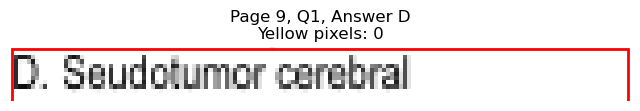


Page 9, Q1 - Selected Answer: A (based on yellow pixel count)
Page 9, Q2 - A: Detected box: x0=56.6, y0=165.1, x1=182.2, y1=177.8
Page 9, Q2, A: Yellow pixels: 0
Page 9, Q2, A: Total non-white pixels: 626
Page 9, Q2, A: Yellow percentage: 0.0%


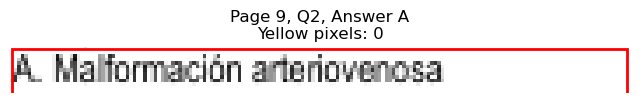

Page 9, Q2 - B: Detected box: x0=56.6, y0=177.7, x1=168.6, y1=190.4
Page 9, Q2, B: Yellow pixels: 0
Page 9, Q2, B: Total non-white pixels: 532
Page 9, Q2, B: Yellow percentage: 0.0%


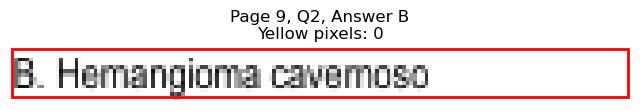

Page 9, Q2 - C: Detected box: x0=315.4, y0=165.1, x1=438.4, y1=177.8
Page 9, Q2, C: Yellow pixels: 2
Page 9, Q2, C: Total non-white pixels: 748
Page 9, Q2, C: Yellow percentage: 0.3%


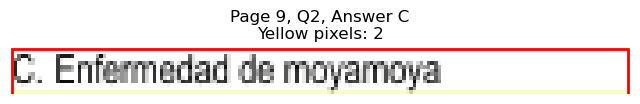

Page 9, Q2 - D: Detected box: x0=315.4, y0=177.7, x1=397.3, y1=190.4
Page 9, Q2, D: Yellow pixels: 1315
Page 9, Q2, D: Total non-white pixels: 1862
Page 9, Q2, D: Yellow percentage: 70.6%


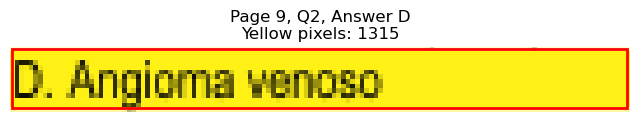


Page 9, Q2 - Selected Answer: D (based on yellow pixel count)
Page 9, Q3 - A: Detected box: x0=56.6, y0=215.6, x1=145.0, y1=228.3
Page 9, Q3, A: Yellow pixels: 0
Page 9, Q3, A: Total non-white pixels: 399
Page 9, Q3, A: Yellow percentage: 0.0%


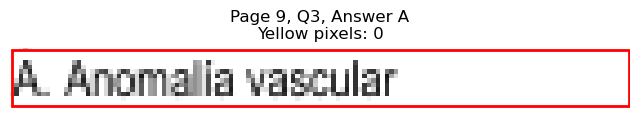

Page 9, Q3 - B: Detected box: x0=56.6, y0=228.2, x1=149.1, y1=240.9
Page 9, Q3, B: Yellow pixels: 0
Page 9, Q3, B: Total non-white pixels: 417
Page 9, Q3, B: Yellow percentage: 0.0%


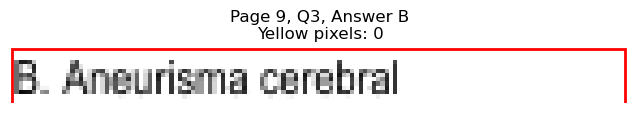

Page 9, Q3 - C: Detected box: x0=315.4, y0=215.6, x1=410.8, y1=228.3
Page 9, Q3, C: Yellow pixels: 1359
Page 9, Q3, C: Total non-white pixels: 2044
Page 9, Q3, C: Yellow percentage: 66.5%


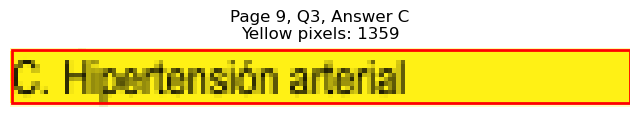

Page 9, Q3 - D: Detected box: x0=315.4, y0=228.2, x1=441.4, y1=240.9
Page 9, Q3, D: Yellow pixels: 0
Page 9, Q3, D: Total non-white pixels: 800
Page 9, Q3, D: Yellow percentage: 0.0%


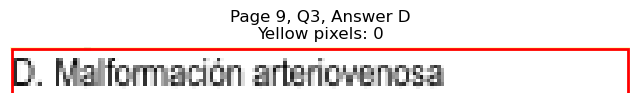


Page 9, Q3 - Selected Answer: C (based on yellow pixel count)
Page 9, Q4 - A: Detected box: x0=56.6, y0=266.0, x1=161.7, y1=278.7
Page 9, Q4, A: Yellow pixels: 0
Page 9, Q4, A: Total non-white pixels: 493
Page 9, Q4, A: Yellow percentage: 0.0%


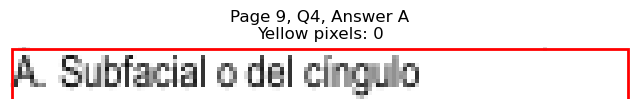

Page 9, Q4 - B: Detected box: x0=56.6, y0=278.8, x1=170.2, y1=291.4
Page 9, Q4, B: Yellow pixels: 0
Page 9, Q4, B: Total non-white pixels: 558
Page 9, Q4, B: Yellow percentage: 0.0%


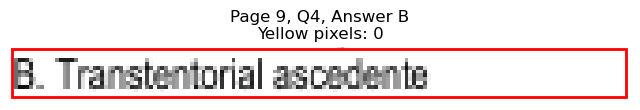

Page 9, Q4 - C: Detected box: x0=315.4, y0=266.0, x1=439.4, y1=278.7
Page 9, Q4, C: Yellow pixels: 1801
Page 9, Q4, C: Total non-white pixels: 2275
Page 9, Q4, C: Yellow percentage: 79.2%


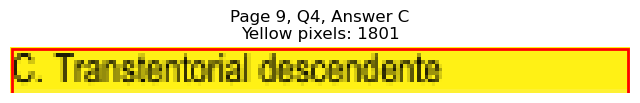

Page 9, Q4 - D: Detected box: x0=315.4, y0=278.8, x1=492.6, y1=291.4
Page 9, Q4, D: Yellow pixels: 225
Page 9, Q4, D: Total non-white pixels: 1129
Page 9, Q4, D: Yellow percentage: 19.9%


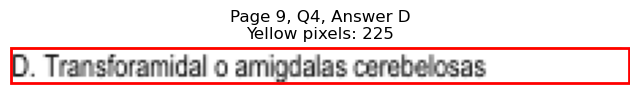


Page 9, Q4 - Selected Answer: C (based on yellow pixel count)
Page 9, Q5 - A: Detected box: x0=56.6, y0=316.6, x1=177.6, y1=329.2
Page 9, Q5, A: Yellow pixels: 172
Page 9, Q5, A: Total non-white pixels: 742
Page 9, Q5, A: Yellow percentage: 23.2%


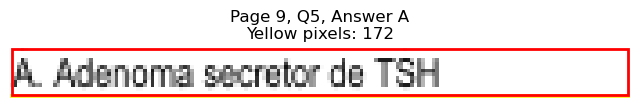

Page 9, Q5 - B: Detected box: x0=56.6, y0=329.2, x1=123.5, y1=341.8
Page 9, Q5, B: Yellow pixels: 1283
Page 9, Q5, B: Total non-white pixels: 1534
Page 9, Q5, B: Yellow percentage: 83.6%


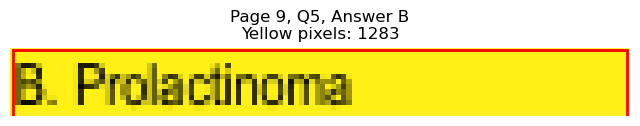

Page 9, Q5 - C: Detected box: x0=315.4, y0=316.6, x1=515.7, y1=329.2
Page 9, Q5, C: Yellow pixels: 0
Page 9, Q5, C: Total non-white pixels: 917
Page 9, Q5, C: Yellow percentage: 0.0%


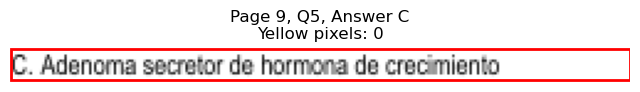

Page 9, Q5 - D: Detected box: x0=315.4, y0=329.2, x1=416.3, y1=341.8
Page 9, Q5, D: Yellow pixels: 0
Page 9, Q5, D: Total non-white pixels: 445
Page 9, Q5, D: Yellow percentage: 0.0%


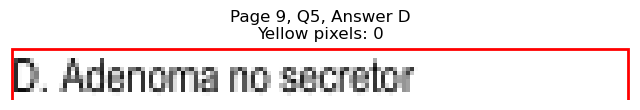


Page 9, Q5 - Selected Answer: B (based on yellow pixel count)
Page 9, Q6 - A: Detected box: x0=56.6, y0=379.7, x1=177.6, y1=392.4
Page 9, Q6, A: Yellow pixels: 0
Page 9, Q6, A: Total non-white pixels: 552
Page 9, Q6, A: Yellow percentage: 0.0%


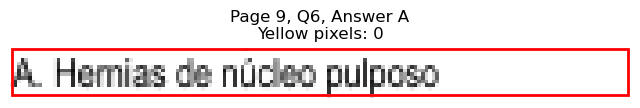

Page 9, Q6 - B: Detected box: x0=56.6, y0=392.3, x1=185.7, y1=405.0
Page 9, Q6, B: Yellow pixels: 0
Page 9, Q6, B: Total non-white pixels: 674
Page 9, Q6, B: Yellow percentage: 0.0%


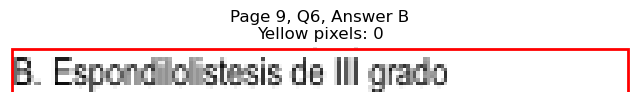

Page 9, Q6 - C: Detected box: x0=315.4, y0=379.7, x1=434.8, y1=392.4
Page 9, Q6, C: Yellow pixels: 1595
Page 9, Q6, C: Total non-white pixels: 2380
Page 9, Q6, C: Yellow percentage: 67.0%


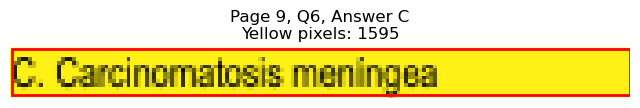

Page 9, Q6 - D: Detected box: x0=315.4, y0=392.3, x1=449.5, y1=405.0
Page 9, Q6, D: Yellow pixels: 0
Page 9, Q6, D: Total non-white pixels: 829
Page 9, Q6, D: Yellow percentage: 0.0%


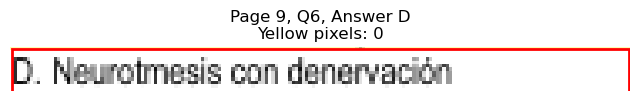


Page 9, Q6 - Selected Answer: C (based on yellow pixel count)
Page 9, Q7 - A: Detected box: x0=56.6, y0=442.8, x1=78.4, y1=455.5
Page 9, Q7, A: Yellow pixels: 0
Page 9, Q7, A: Total non-white pixels: 76
Page 9, Q7, A: Yellow percentage: 0.0%


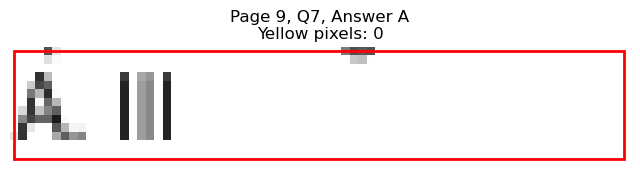

Page 9, Q7 - B: Detected box: x0=56.6, y0=455.5, x1=79.3, y1=468.1
Page 9, Q7, B: Yellow pixels: 0
Page 9, Q7, B: Total non-white pixels: 78
Page 9, Q7, B: Yellow percentage: 0.0%


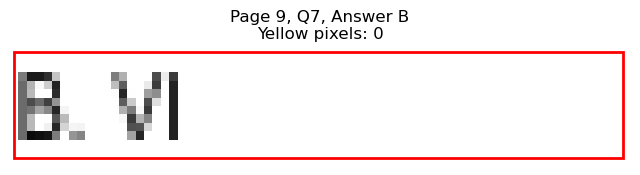

Page 9, Q7 - C: Detected box: x0=315.4, y0=442.8, x1=338.6, y1=455.5
Page 9, Q7, C: Yellow pixels: 896
Page 9, Q7, C: Total non-white pixels: 1036
Page 9, Q7, C: Yellow percentage: 86.5%


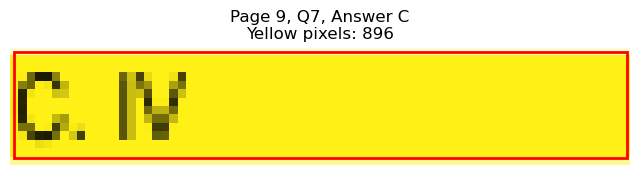

Page 9, Q7 - D: Detected box: x0=315.4, y0=455.5, x1=336.1, y1=468.1
Page 9, Q7, D: Yellow pixels: 0
Page 9, Q7, D: Total non-white pixels: 72
Page 9, Q7, D: Yellow percentage: 0.0%


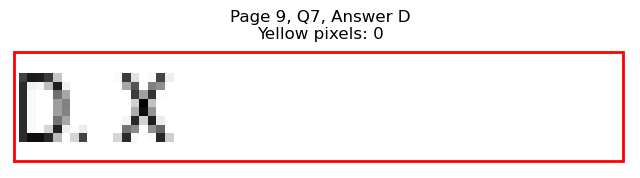


Page 9, Q7 - Selected Answer: C (based on yellow pixel count)
Page 9, Q8 - A: Detected box: x0=56.6, y0=518.6, x1=93.9, y1=531.2
Page 9, Q8, A: Yellow pixels: 1022
Page 9, Q8, A: Total non-white pixels: 1232
Page 9, Q8, A: Yellow percentage: 83.0%


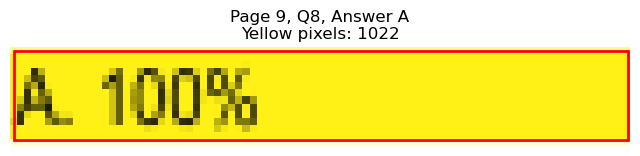

Page 9, Q8 - B: Detected box: x0=56.6, y0=531.2, x1=88.8, y1=543.8
Page 9, Q8, B: Yellow pixels: 0
Page 9, Q8, B: Total non-white pixels: 231
Page 9, Q8, B: Yellow percentage: 0.0%


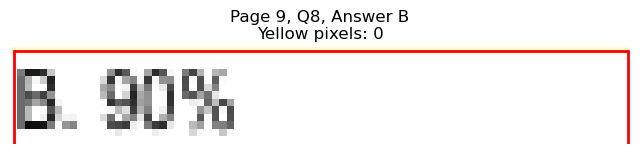

Page 9, Q8 - C: Detected box: x0=315.4, y0=518.6, x1=348.1, y1=531.2
Page 9, Q8, C: Yellow pixels: 0
Page 9, Q8, C: Total non-white pixels: 138
Page 9, Q8, C: Yellow percentage: 0.0%


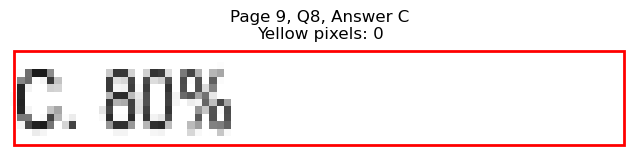

Page 9, Q8 - D: Detected box: x0=315.4, y0=531.2, x1=348.1, y1=543.8
Page 9, Q8, D: Yellow pixels: 0
Page 9, Q8, D: Total non-white pixels: 132
Page 9, Q8, D: Yellow percentage: 0.0%


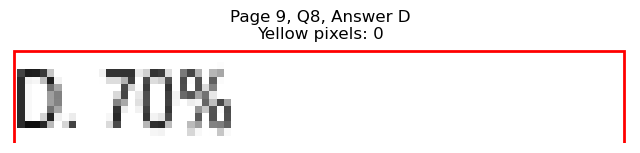


Page 9, Q8 - Selected Answer: A (based on yellow pixel count)
Page 9, Q9 - A: Detected box: x0=56.6, y0=581.7, x1=148.0, y1=594.3
Page 9, Q9, A: Yellow pixels: 0
Page 9, Q9, A: Total non-white pixels: 452
Page 9, Q9, A: Yellow percentage: 0.0%


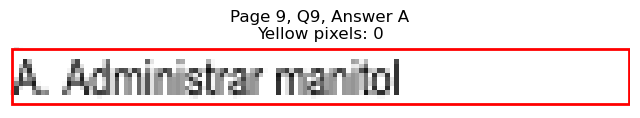

Page 9, Q9 - B: Detected box: x0=56.6, y0=594.3, x1=182.7, y1=606.9
Page 9, Q9, B: Yellow pixels: 0
Page 9, Q9, B: Total non-white pixels: 600
Page 9, Q9, B: Yellow percentage: 0.0%


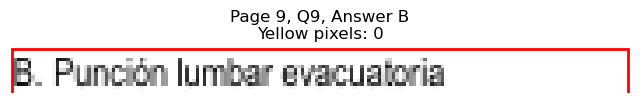

Page 9, Q9 - C: Detected box: x0=315.4, y0=581.7, x1=449.9, y1=594.3
Page 9, Q9, C: Yellow pixels: 1708
Page 9, Q9, C: Total non-white pixels: 2590
Page 9, Q9, C: Yellow percentage: 65.9%


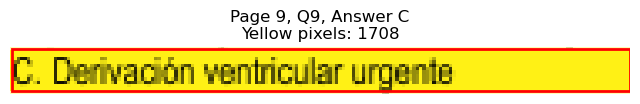

Page 9, Q9 - D: Detected box: x0=315.4, y0=594.3, x1=421.3, y1=606.9
Page 9, Q9, D: Yellow pixels: 0
Page 9, Q9, D: Total non-white pixels: 679
Page 9, Q9, D: Yellow percentage: 0.0%


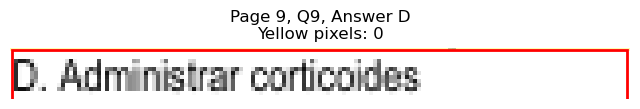


Page 9, Q9 - Selected Answer: C (based on yellow pixel count)
Page 9, Q10 - A: Detected box: x0=56.6, y0=632.2, x1=116.9, y1=644.9
Page 9, Q10, A: Yellow pixels: 0
Page 9, Q10, A: Total non-white pixels: 377
Page 9, Q10, A: Yellow percentage: 0.0%


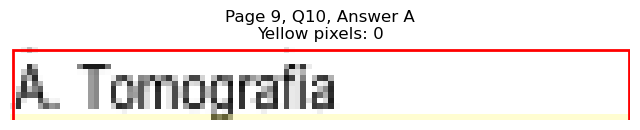

Page 9, Q10 - B: Detected box: x0=56.6, y0=644.8, x1=118.5, y1=657.5
Page 9, Q10, B: Yellow pixels: 1244
Page 9, Q10, B: Total non-white pixels: 1582
Page 9, Q10, B: Yellow percentage: 78.6%


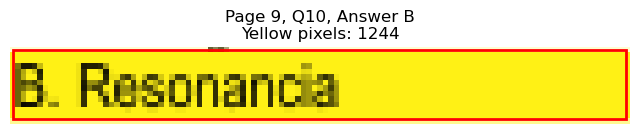

Page 9, Q10 - C: Detected box: x0=315.4, y0=632.2, x1=376.3, y1=644.9
Page 9, Q10, C: Yellow pixels: 0
Page 9, Q10, C: Total non-white pixels: 278
Page 9, Q10, C: Yellow percentage: 0.0%


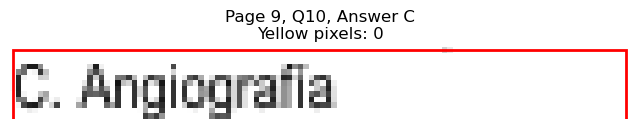

Page 9, Q10 - D: Detected box: x0=315.4, y0=644.8, x1=362.1, y1=657.5
Page 9, Q10, D: Yellow pixels: 0
Page 9, Q10, D: Total non-white pixels: 209
Page 9, Q10, D: Yellow percentage: 0.0%


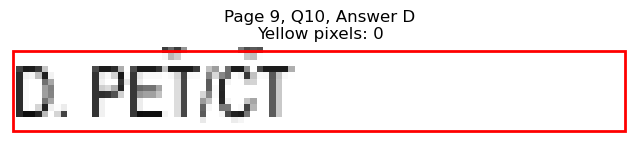


Page 9, Q10 - Selected Answer: B (based on yellow pixel count)
Page 9, Q11 - A: Detected box: x0=56.6, y0=708.0, x1=133.9, y1=720.6
Page 9, Q11, A: Yellow pixels: 1359
Page 9, Q11, A: Total non-white pixels: 1792
Page 9, Q11, A: Yellow percentage: 75.8%


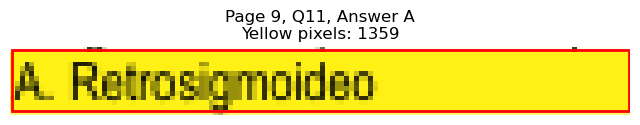

Page 9, Q11 - B: Detected box: x0=56.6, y0=720.6, x1=149.1, y1=733.2
Page 9, Q11, B: Yellow pixels: 143
Page 9, Q11, B: Total non-white pixels: 609
Page 9, Q11, B: Yellow percentage: 23.5%


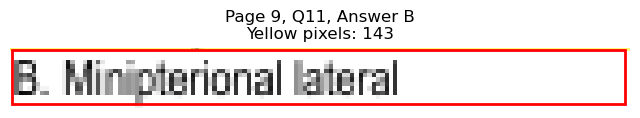

Page 9, Q11 - C: Detected box: x0=315.4, y0=708.0, x1=449.9, y1=720.6
Page 9, Q11, C: Yellow pixels: 0
Page 9, Q11, C: Total non-white pixels: 656
Page 9, Q11, C: Yellow percentage: 0.0%


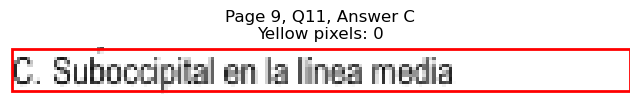

Page 9, Q11 - D: Detected box: x0=315.4, y0=720.6, x1=450.4, y1=733.2
Page 9, Q11, D: Yellow pixels: 0
Page 9, Q11, D: Total non-white pixels: 707
Page 9, Q11, D: Yellow percentage: 0.0%


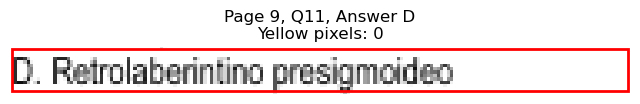


Page 9, Q11 - Selected Answer: A (based on yellow pixel count)

Page 10: Found 3 questions
Page 10, Q1 - A: Detected box: x0=56.6, y0=114.6, x1=356.1, y1=127.3
Page 10, Q1, A: Yellow pixels: 351
Page 10, Q1, A: Total non-white pixels: 1807
Page 10, Q1, A: Yellow percentage: 19.4%


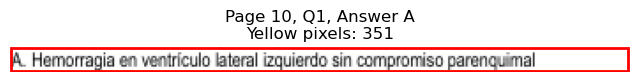

Page 10, Q1 - B: Detected box: x0=56.6, y0=127.2, x1=393.8, y1=139.9
Page 10, Q1, B: Yellow pixels: 3715
Page 10, Q1, B: Total non-white pixels: 5044
Page 10, Q1, B: Yellow percentage: 73.7%


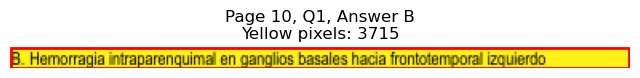

Page 10, Q1 - C: Detected box: x0=56.6, y0=139.9, x1=311.0, y1=152.6
Page 10, Q1, C: Yellow pixels: 289
Page 10, Q1, C: Total non-white pixels: 1637
Page 10, Q1, C: Yellow percentage: 17.7%


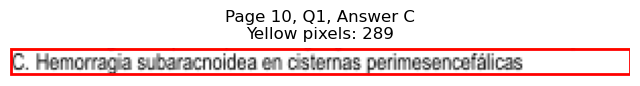

Page 10, Q1 - D: Detected box: x0=56.6, y0=152.5, x1=260.9, y1=165.2
Page 10, Q1, D: Yellow pixels: 0
Page 10, Q1, D: Total non-white pixels: 1024
Page 10, Q1, D: Yellow percentage: 0.0%


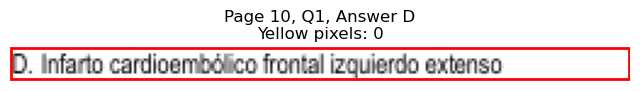


Page 10, Q1 - Selected Answer: B (based on yellow pixel count)
Page 10, Q2 - A: Detected box: x0=56.6, y0=190.3, x1=144.0, y1=203.0
Page 10, Q2, A: Yellow pixels: 0
Page 10, Q2, A: Total non-white pixels: 515
Page 10, Q2, A: Yellow percentage: 0.0%


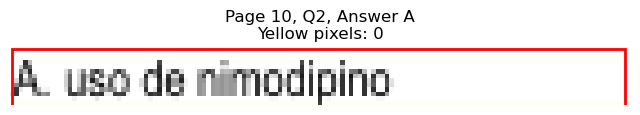

Page 10, Q2 - B: Detected box: x0=56.6, y0=202.9, x1=182.2, y1=215.6
Page 10, Q2, B: Yellow pixels: 1844
Page 10, Q2, B: Total non-white pixels: 2478
Page 10, Q2, B: Yellow percentage: 74.4%


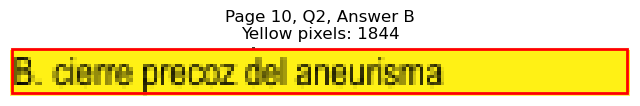

Page 10, Q2 - C: Detected box: x0=315.4, y0=190.3, x1=445.9, y1=203.0
Page 10, Q2, C: Yellow pixels: 0
Page 10, Q2, C: Total non-white pixels: 622
Page 10, Q2, C: Yellow percentage: 0.0%


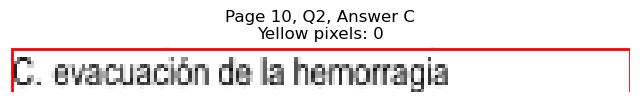

Page 10, Q2 - D: Detected box: x0=315.4, y0=202.9, x1=437.8, y1=215.6
Page 10, Q2, D: Yellow pixels: 0
Page 10, Q2, D: Total non-white pixels: 619
Page 10, Q2, D: Yellow percentage: 0.0%


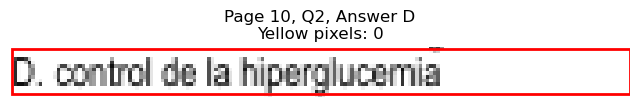


Page 10, Q2 - Selected Answer: B (based on yellow pixel count)
Page 10, Q3 - A: Detected box: x0=56.6, y0=240.8, x1=99.4, y1=253.5
Page 10, Q3, A: Yellow pixels: 1070
Page 10, Q3, A: Total non-white pixels: 1316
Page 10, Q3, A: Yellow percentage: 81.3%


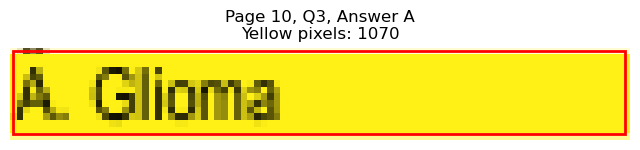

Page 10, Q3 - B: Detected box: x0=56.6, y0=253.4, x1=148.6, y1=266.1
Page 10, Q3, B: Yellow pixels: 143
Page 10, Q3, B: Total non-white pixels: 591
Page 10, Q3, B: Yellow percentage: 24.2%


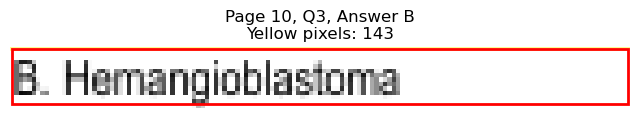

Page 10, Q3 - C: Detected box: x0=315.4, y0=240.8, x1=396.3, y1=253.5
Page 10, Q3, C: Yellow pixels: 0
Page 10, Q3, C: Total non-white pixels: 416
Page 10, Q3, C: Yellow percentage: 0.0%


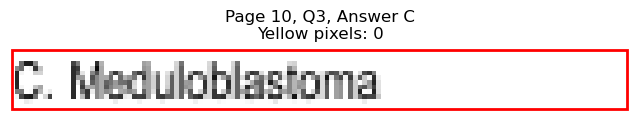

Page 10, Q3 - D: Detected box: x0=315.4, y0=253.4, x1=384.7, y1=266.1
Page 10, Q3, D: Yellow pixels: 0
Page 10, Q3, D: Total non-white pixels: 329
Page 10, Q3, D: Yellow percentage: 0.0%


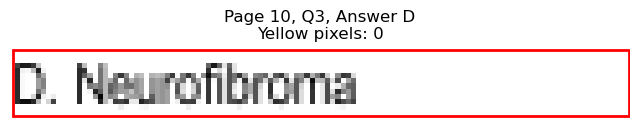


Page 10, Q3 - Selected Answer: A (based on yellow pixel count)


In [6]:
questions_df = extract_questions(pdf_path = pdf_file)
answers_df = extract_answers(pdf_path = pdf_file)
correct_answers_df = extract_correct_answers(pdf_path = pdf_file)

In [7]:
questions_df

question
0   Mujer de 66 años usuaria de corticoides y AINE...
1   ¿Cuál es el punto más prominente del hueso occ...
2   La TC craneal tiene una sensibilidad de detecc...
3   Niño de 15 años, con cefalea post TEC. TC de c...
4   Varón de 69 años, ingresa por cefalea persiste...
..                                                ...
95  ¿Cuál es la prueba más sensible para diagnósti...
96  Mujer adulta, con dolor tipo quemazón en hemic...
97  Varón de 84 años con antecedentes de fibrilaci...
98  En el tratamiento de la HSA, el riesgo de resa...
99      ¿Cuál es el tumor intramedular más frecuente?

[100 rows x 1 columns]

In [8]:
answers_df

option_A  \
0                                 Fractura traumática   
1                                            Asterion   
2                                                100%   
3                               Edema cerebral difuso   
4                                        Osteosarcoma   
..                                                ...   
95                                         Tomografía   
96                                     Retrosigmoideo   
97  Hemorragia en ventrículo lateral izquierdo sin...   
98                                  uso de nimodipino   
99                                             Glioma   

                                             option_B  \
0                           Fractura por osteoporosis   
1                                       Opistocranion   
2                                                 50%   
3                                Lesión axonal difusa   
4                                      Adenocarcinoma   
..                                                ...   
95                                         Resonancia   
96                              Minipterional lateral   
97  Hemorragia intraparenquimal en ganglios basale...   
98                        cierre precoz del aneurisma   
99                                   Hemangioblastoma   

                                             option_C  \
0                                          Metástasis   
1                                               Inion   
2                                                 40%   
3                                     Infarto lacunar   
4                                             Linfoma   
..                                                ...   
95                                        Angiografía   
96                     Suboccipital en la línea media   
97  Hemorragia subaracnoidea en cisternas perimese...   
98                        evacuación de la hemorragia   
99                                     Meduloblastoma   

                                            option_D  
0                            Fractura en tallo verde  
1                                            Pterion  
2                                                30%  
3                                 Aneurisma arterial  
4                                           Melanoma  
..                                               ...  
95                                            PET/CT  
96                     Retrolaberintino presigmoideo  
97  Infarto cardioembólico frontal izquierdo extenso  
98                       control de la hiperglucemia  
99                                      Neurofibroma  

[100 rows x 4 columns]

In [9]:
correct_answers_df

correct_answer
0               B
1               B
2               A
3               A
4               D
..            ...
95              B
96              A
97              B
98              B
99              A

[100 rows x 1 columns]

In [10]:
total_df = pd.concat([questions_df, answers_df, correct_answers_df], ignore_index = True, axis = 1)
total_df.columns = ["questions", "option_A", "option_B", "option_C", "option_D", "correct_answer"]
total_df

questions  \
0   Mujer de 66 años usuaria de corticoides y AINE...   
1   ¿Cuál es el punto más prominente del hueso occ...   
2   La TC craneal tiene una sensibilidad de detecc...   
3   Niño de 15 años, con cefalea post TEC. TC de c...   
4   Varón de 69 años, ingresa por cefalea persiste...   
..                                                ...   
95  ¿Cuál es la prueba más sensible para diagnósti...   
96  Mujer adulta, con dolor tipo quemazón en hemic...   
97  Varón de 84 años con antecedentes de fibrilaci...   
98  En el tratamiento de la HSA, el riesgo de resa...   
99      ¿Cuál es el tumor intramedular más frecuente?   

                                             option_A  \
0                                 Fractura traumática   
1                                            Asterion   
2                                                100%   
3                               Edema cerebral difuso   
4                                        Osteosarcoma   
..                                                ...   
95                                         Tomografía   
96                                     Retrosigmoideo   
97  Hemorragia en ventrículo lateral izquierdo sin...   
98                                  uso de nimodipino   
99                                             Glioma   

                                             option_B  \
0                           Fractura por osteoporosis   
1                                       Opistocranion   
2                                                 50%   
3                                Lesión axonal difusa   
4                                      Adenocarcinoma   
..                                                ...   
95                                         Resonancia   
96                              Minipterional lateral   
97  Hemorragia intraparenquimal en ganglios basale...   
98                        cierre precoz del aneurisma   
99                                   Hemangioblastoma   

                                             option_C  \
0                                          Metástasis   
1                                               Inion   
2                                                 40%   
3                                     Infarto lacunar   
4                                             Linfoma   
..                                                ...   
95                                        Angiografía   
96                     Suboccipital en la línea media   
97  Hemorragia subaracnoidea en cisternas perimese...   
98                        evacuación de la hemorragia   
99                                     Meduloblastoma   

                                            option_D correct_answer  
0                            Fractura en tallo verde              B  
1                                            Pterion              B  
2                                                30%              A  
3                                 Aneurisma arterial              A  
4                                           Melanoma              D  
..                                               ...            ...  
95                                            PET/CT              B  
96                     Retrolaberintino presigmoideo              A  
97  Infarto cardioembólico frontal izquierdo extenso              B  
98                       control de la hiperglucemia              B  
99                                      Neurofibroma              A  

[100 rows x 6 columns]

In [11]:
# Extract folder path
folder_path = os.path.dirname(pdf_file)  # Gets the directory path

# Extract filename without extension
file_name = os.path.splitext(os.path.basename(pdf_file))[0]  # Removes the .pdf extension

# Create CSV file path
csv_file = os.path.join(folder_path, f"{file_name}.csv")

# Save a sample DataFrame
total_df.to_csv(csv_file, index=False, encoding="utf-8-sig")
print(f"CSV saved at: {csv_file}")


CSV saved at: /Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2024/NEUROCIRUGÍA.csv
